# v3_slide.ipynb

A copy of base_v3_bp adapted to use gated_slide_rga_diff synapses.

In [1]:
%cd ../..
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
%load_ext Cython

In [3]:
%%cython
from draculab import *

In [4]:
##################################
####### Create the network #######
##################################

# simulation control parameters
t_pres = 30. # number of seconds to hold each set of target lengths
rand_w = True # whether to use random weights in M->C, AF->M
rand_targets = True # whether to train using a large number of random targets

# First the network object, the plant, the list of coordinates
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 10 }
P_params = {  'type' : plant_models.bouncy_planar_arm_v3,
          'mass1': 1.,
          'mass2': 1.,
          's_min' : -0.8,
          'p1' : (-0.01, 0.04),
          'p2' : (0.29, 0.03),
          'p3' : (0., 0.05),
          'p5' : (0.01, -0.05),
          'p10': (0.29, 0.03),
          'init_q1': 0.,
          'init_q2': np.pi/2.,
          'init_q1p': 0.,
          'init_q2p': 0.,
          'g': 0.0,
          'mu1': 3.,
          'mu2': 3.,
          'l_torque' : 0.01,
          'l_visco' : 0.01,
          'g_e' : 1.5*np.array([10., 20., 20., 10., 20., 20.]),
          'l0_e' : [1.]*6,
          'Ia_gain' : 2.5*np.array([3.,10.,10., 3.,10.,10.]),
          'II_gain' : 2.*np.array([3., 8., 8., 3., 8., 8.]),
          'Ib_gain' : 1.,
          'T_0' : 10.,
          'k_pe_e' : 5.,  #8
          'k_se_e' : 25., #13
          'b_e' : 5.,
          'g_s' : 0.02,
          'k_pe_s' : 2., 
          'k_se_s' : 2.,
          'g_d' : 0.01,
          'k_pe_d' : .2, #.1,
          'k_se_d' : 1., #2.,
          'b_s' : .5,
          'b_d' : 2.,#3.,
          'l0_s': .7,
          'l0_d': .8,
          'fs' : 0.1,
          'se_II' : 0.5,
          'cd' : 0.5,
          'cs' : 0.5,
          'tau' : 0.1   # ficticious time constant used in create_freqs_steps
           }
net = network(net_params)
P = net.create(1, P_params)
arm = net.plants[P]

# We organize the spinal connections through 4 types of symmetric relations
# these lists are used to set intraspinal connections and test connection matrices
antagonists = [(0,3), (1,2), (4,5)]
part_antag = [(0,2),(0,5), (3,4), (1,3)]
synergists = [(0,1), (0,4), (2,3), (3,5)]
part_syne = [(1,4), (2,5)]
self_conn = [(x,x) for x in range(6)]

antagonists += [(p[1],p[0]) for p in antagonists]
part_antag += [(p[1],p[0]) for p in part_antag]
synergists += [(p[1],p[0]) for p in synergists]
part_syne += [(p[1],p[0]) for p in part_syne]
all_pairs = [(i,j) for i in range(6) for j in range(6)]
#unrelated = set(all_pairs) - set(antagonists) - set(part_antag) - set(synergists) - set(part_syne) - set(self_conn)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# UNIT PARAMETER DICTIONARIES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
par_heter = 0.001 # range of heterogeneity as a fraction of the original value
#randz1 = lambda : (1. + par_heter*(np.random.rand()-0.5))
randz6 = lambda : (1. + par_heter*(np.random.rand(6)-0.5))
randz12 = lambda : (1. + par_heter*(np.random.rand(12)-0.5))
randz18 = lambda : (1. + par_heter*(np.random.rand(18)-0.5))
randz36 = lambda : (1. + par_heter*(np.random.rand(36)-0.5))

ACT_params = {'type' : unit_types.act,
              'tau_u' : 8.,
              'gamma' : 2.,
              'g' : 2.,
              'theta' : 1.,
              'tau_slow' : 5.,
              'y_min' : 0.2,
              'rst_thr' : 0.1,
              'init_val' : 0. }
spf_sum_min = .4 # value where no corrections are needed anymore
y_min = 1./(1. + np.exp(-ACT_params['g']*(spf_sum_min - ACT_params['theta'])))
ACT_params['y_min'] = y_min

init_AF = [0.16, 0.39, 0.30, 0.20, 0.37, 0.32, 0.03, -0.13, 0.34,
           0.16, 0.09, 0.13, 0.14, -0.15, 0.61, 0.39, 0.20, 0.26]
AF_params = {'type' : unit_types.chwr_linear, #logarithmic,
             'init_val' : [max(v,0.) for v in init_AF] + [max(-v,0.) for v in init_AF],
             'tau' : 0.02 * randz36(),
             'tau_fast': 0.1,
             'tau_mid' : 1.,
             'tau_slow' : 400., # using a slow value, so init_val is important
             'delay' : 0.1,
             'thresh' : 0. } #-.1
AL_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.6 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.1 * randz6(),
             'tau' : 0.05 * randz6() }
CE_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
             'thresh' : 0. * randz6(),
             'slope' : 1.5 * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.1, #0.02 * randz6(),
             'tau_fast': 0.1,
             'tau_mid' : 1.,
             'tau_slow' : 10.,
             'custom_inp_del' : 15, # placeholder values
             'custom_inp_del2': 30,
             'del_mod_max' : 80, # 0.4 seconds
             'del_mod_min' : -20, # -0.1 seconds
             'integ_amp' : 0.5, #.5,
             'integ_decay' : 1.,
             'adapt_amp' : 10., #8.,
             'delay' : 0.2,
             'des_out_w_abs_sum' : 1. }
CI_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
             'thresh' : 0.5 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.05, #0.01 * randz6(), #0.02 * randz6(),
             'tau_fast': 0.1,
             'tau_mid' : 1.,
             'tau_slow' : 10.,
             'custom_inp_del' : 15, # placeholder values
             'custom_inp_del2': 30,
             'del_mod_max' : 80, # 0.4 seconds
             'del_mod_min' : -20, # -0.1 seconds
             'integ_amp' : 0.5, #.5,
             'integ_decay' : 1.,
             'adapt_amp' : 10., #8.,
             'delay' : 0.2,
             'des_out_w_abs_sum' : 1. }
M_params = {'type' : unit_types.gated_out_norm_am_sig,
            'thresh' : 0. * randz12(),
            'slope' : 3. * randz12(),
            'init_val' : 0.2 * randz12(),
            'delay' : 0.2,
            'tau_fast': 0.1,
            'tau_mid': 1.,
            'tau_slow' : 2.,
            'tau' : 0.01 * randz12(),
            'p0_inp' : 0.0,
            'des_out_w_abs_sum' : 2. }
SF_params = {'type' : unit_types.sigmoidal,
             #'thresh' : np.array([0.]*12),
             'thresh' : np.array([-0.02, -0.01, 0.03, -0.02, -0.02, -0.02, -0.02, -0.01, 0.03, -0.02, -0.02, -0.02]),
             #'slope' : np.array([np.log(5.)]*12), #np.array([np.log(9.)]*12),
             'slope' : 20.*np.array([1.36, 1.38, 1.43, 1.36, 1.36, 1.35, 1.36, 1.38, 1.43, 1.36, 1.36, 1.35]),
             'init_val' : 0.2 * randz12(),
             'tau' : 0.03 * randz12() } 
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'tau_fast' : 0.02,
             'tau_mid' : 0.1,
             'function' : lambda t: None }
SP_CHG_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.25,
              'slope' : 9.,
              'init_val' : 0.1,
              'tau' : 0.01 }
SPF_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.4 * randz12(),
              'slope' : 6. * randz12(),
              'init_val' : 0.3 * randz12(),
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.02 * randz12() }
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONNECTION DICTIONARIES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# ACT to CE,CI ------------------------------------------------
ACT__CE_conn = {'rule' : "all_to_all",
                'delay' : 0.02 } 
ACT__CE_syn = {'type' : synapse_types.static,
               'inp_ports' : 4,
               'init_w' : 1. }
ACT__CI_conn = {'rule' : "all_to_all",
                'delay' : 0.02 } 
ACT__CI_syn = {'type' : synapse_types.static,
               'inp_ports' : 4,
               'init_w' : 1. }
# AF to CE, CI --------------------------------------------------
AF__CE_conn = {'rule' : 'all_to_all',
               'delay' : 0.02 }
AF__CE_syn = {'type' : synapse_types.gated_inp_sel,
              'aff_port' : 2,
              'inp_ports' : 2,
              'error_port' : 0,
              'normalize' : True,
              'w_sum' : 2.,
              'lrate' : 0., #10.,
              'extra_steps' : 1,
              'init_w' : 0.005 }
AF__CI_conn = {'rule' : 'all_to_all',
               'delay' : 0.02 }
AF__CI_syn = {'type' : synapse_types.gated_inp_sel,
              'aff_port' : 2,
              'inp_ports' : 2,
              'error_port' : 0,
              'normalize' : True,
              'w_sum' : 2.,
              'lrate' : 0., #10.,
              'extra_steps' : 1,
              'init_w' : 0.005 }
# AF to M ------------------------------------------------
## Creating a test matrix
if not rand_w:
    # Initializing manually
    AF_M = np.zeros((36, 12)) # rows are source, columns target
    for src in range(36):
        for trg in range(12):
            src_pop = src%6 #src's population
            trg_pop = trg%6 #trg's population
            if src%18 < 6: # if the afferent is tension, don't reverse signs
                sig = 1
            else:
                sig = -1
            if src > 17: sig = -sig # if 'negative' afferent reverse sign
            for pair in antagonists:
                if pair == (src_pop, trg_pop):
                    AF_M[src, trg] = sig*0.2
                    break
            else: 
                for pair in part_antag:
                    if pair == (src_pop, trg_pop):
                        AF_M[src, trg] = sig*0.1
                        break
                else: 
                    for pair in synergists:
                        if pair == (src_pop, trg_pop):
                            AF_M[src, trg] = sig*-0.2
                            break
                    else: 
                        for pair in synergists:
                            if pair == (src_pop, trg_pop):
                                AF_M[src, trg] = sig*-0.2
                                break
                        else: 
                            for pair in part_syne:
                                if pair == (src_pop, trg_pop):
                                    AF_M[src, trg] = sig*-0.1
                                    break
                            else:
                                if src_pop == trg_pop:
                                    AF_M[src, trg] = sig*-0.3
else:
    #AF_M = 0.2*(np.random.random((12,12)) - 0.5) # random initial connections!!!!!
    AF_M = 0.2*(np.random.random((12,36)) - 0.5) # random initial connections!!!!!
AF__M_conn = {'rule' : 'all_to_all',
             'delay' : 0.02 }
AF__M_syn = {'type' : synapse_types.gated_diff_inp_sel,
            'aff_port' : 0,
            'error_port' : 1,
            'normalize' : True,
            'w_sum' : 10.,
            'inp_ports' : 0, # afferent for out_norm_am_sig
            'input_type' : 'pred', # if using inp_corr
            'lrate' : 15., #10.
            'extra_steps' : None, # placeholder value; filled below,
            'init_w' : AF_M.flatten() }
# AF to SF ------------------------------------------------
AF__SF_dubya = [0.57, 0.56, 0.56, 0.57, 0.55, 0.55, 0.57, 0.56, 0.56, 0.57, 0.55, 0.55]
AFe__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
AFe__SF_syn = {'type' : synapse_types.static,
             #'init_w' : .5*np.array([ 39.73, 15.03,  9.66, 116.47, 8.63,  63.68, 20.88, 9.69, 5.86, 67.98, 5.44, 57.38]) }
             #'init_w' : np.array([15.07516819, 20.60577773,  6.32821777, 14.08991768,  5.69679834,  8.89424814,
             #                       7.68013805, 13.46076843,  3.87962611,  7.1693345,   3.5817668,   5.8075114 ])
              'init_w' : np.array(AF__SF_dubya)}
AFi__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
AFi__SF_syn = {'type' : synapse_types.static,
             #'init_w' : .5*np.array([-162.42, -9.56, -15.19, -50.0, -88.47, -9.73, -67.67, -5.85, -9.96, -23.55, -50.63, -5.81])}
              #'init_w' : np.array([-15.36496074,  -5.96985989, -21.78133701, -18.88200345, -11.38248201,
              #            -6.93261446,  -7.53984025,  -3.68499008, -14.59079011,  -9.22649886,  -7.03063956,  -4.19297924])
              'init_w' : -np.array(AF__SF_dubya)}
# AL to P ------------------------------------------------
AL__P_conn = {'inp_ports' : list(range(6)),
             'delays': 0.01 }
AL__P_syn = {'type': synapse_types.static,
            'init_w' : 1. }
# CE, CI to AL ----------------------------------------------
CE__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__AL_syn = {'type' : synapse_types.static,
              'init_w' : [1., 1., 1., 1., 1., 1.] }
CI__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__AL_syn = {'type' : synapse_types.static,
              'init_w' : -1. }
# CE,CI to CE,CI  ------------------------------------------------
CE__CI_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__CE_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__CI_syn = {'type' : synapse_types.static,
              'inp_ports' : 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
              'init_w' : 1. }
CI__CE_syn = {'type' : synapse_types.static, #static, #corr_inh,
              'inp_ports' : 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
              'lrate' : .0,
              'des_act' : 0.5,
              'init_w' : -4. }
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.015 }
C__C_syn_antag = {'type' : synapse_types.static, #bcm,
                  'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                  'init_w' : 2., #16.,
                  'lrate' : 1.,
                  'des_act' : .5 }
C__C_syn_p_antag = {'type' : synapse_types.static, #bcm,
                  'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                  'init_w' : .5, # 8.,
                  'lrate' : 1.,
                  'des_act' : 0.2 }
C__C_syn_syne = {'type' : synapse_types.static,
                 'inp_ports': 1,
                 'lrate' : 1.,
                 'init_w' : .5 }
C__C_syn_p_syne = {'type' : synapse_types.static,
                   'inp_ports': 1,
                   'lrate' : 1.,
                   'init_w' : 0.2 }
C__C_syn_null_lat = {'type' : synapse_types.static, # connection with static weight zero
                   'inp_ports': 1,
                   'lrate' : 1.,
                   'init_w' : 0. }
C__C_syn_null_aff = {'type' : synapse_types.static, # connection with static weight zero
                   'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                   'lrate' : 1.,
                   'init_w' : 0. }

# M to CE,CI ----------------------------------------------
# creating a test matrix
if not rand_w:
    # initializing manually
    M_CE = np.array(
        [[ 0.2,  0.1, -0.1, -0.2,  0.1, -0.1],
         [ 0.1,  0.2, -0.2, -0.1,  0.1,  0.0],
         [-0.1, -0.2,  0.2,  0.1,  0.0,  0.0],
         [-0.2, -0.1,  0.1, -0.2, -0.1,  0.1],
         [ 0.1,  0.0,  0.0, -0.1,  0.3, -0.2],
         [-0.1,  0.0,  0.0,  0.1, -0.2,  0.3],
         [ 0.2,  0.1, -0.1, -0.2,  0.1, -0.1],
         [ 0.1,  0.2, -0.2, -0.1,  0.1,  0.0],
         [-0.1, -0.2,  0.2,  0.1,  0.0,  0.0],
         [-0.2, -0.1,  0.1, -0.2, -0.1,  0.1],
         [ 0.1,  0.0,  0.0, -0.1,  0.3, -0.2],
         [-0.1,  0.0,  0.0,  0.1, -0.2,  0.3]])
    M_CI = -M_CE 
else:
    M_CE = 0.4*(np.random.random((12,6)) - 0.5) # random initial connections!!!!!
    M_CI = 0.4*(np.random.random((12,6)) - 0.5) # random initial connections!!!!!

M__CE_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__CE_syn = {'type' : synapse_types.gated_slide_rga_diff,
             'inp_ports' : 0,
             'lrate' : 60.,#1.,
             'del_mod_tau' : .01,
             'w_sum' : 3.,
             'w_thresh' : 0.05,
             'w_decay': 0.005,
             'w_tau' : 60.,
             'init_w' : M_CE.flatten() }
M__CI_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__CI_syn = {'type' : synapse_types.gated_slide_rga_diff,
             'inp_ports' : 0,
             'lrate' : 60., #1.,
             'del_mod_tau' : .01,
             'w_sum' : 3.,
             'w_thresh' : 0.05,
             'w_tau' : 60.,
             'w_decay': 0.005,
             'init_w' : M_CI.flatten() }
# P to AF  ---------------------------------------------------
idx_aff = np.arange(22,40) # indexes for afferent output in the arm
P__AF_conn = {'port_map' : [[(p,0)] for p in idx_aff],
             'delays' : 0.02 }
Pe__AF_syn = {'type' : synapse_types.static,
              'init_w' : [1.]*18 } 
Pi__AF_syn = {'type' : synapse_types.static,
            'init_w' :  [-1.]*18 }
# SF, SP to SPF ------------------------------------------------
SFe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -1. }
SPe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
# SP to SP_CHG ------------------------------------------------
SP__SP_CHG_conn = {'rule' : 'all_to_all',
                    'delay' : 0.01}
SP__SP_CHG_syn = {'type' : synapse_types.chg,
                  'init_w' : 0.,
                  'lrate' : 20. }
# SP_CHG to CE, CI ------------------------------------------------
SP_CHG__CE_conn = {'rule' : "all_to_all",
                  'delay' : 0.02 }
SP_CHG__CE_syn = {'type' : synapse_types.static,
                  'inp_ports' : 3,
                  'init_w' : 1. }
SP_CHG__CI_conn = {'rule' : "all_to_all",
                   'delay' : 0.02 }
SP_CHG__CI_syn = {'type' : synapse_types.static,
                  'inp_ports' : 3,
                  'init_w' : 1. }
# SP_CHG to ACT ------------------------------------------------
SP_CHG__ACT_conn = {'rule' : "all_to_all",
                   'delay' : 0.02 }
SP_CHG__ACT_syn = {'type' : synapse_types.static,
                  'inp_ports' : 1,
                  'init_w' : 1. }
# SP_CHG to M ------------------------------------------------
SP_CHG__M_conn = {'rule' : "all_to_all",
                  'delay' : 0.02 }
SP_CHG__M_syn = {'type' : synapse_types.static,
                  'inp_ports' : 2,
                  'init_w' : 1. }
# SPF to ACT ------------------------------------------------
SPF__ACT_conn = {'rule' : "all_to_all",
                 'delay' : 0.02 }
SPF__ACT_syn = {'type' : synapse_types.static,
                'inp_ports' : 0,
                'init_w' : 1. }
# SPF to M  ------------------------------------------------
SPF__M_conn = {'rule': 'one_to_one',
               'delay': 0.01 }
SPF__M_syn = {'type' : synapse_types.static, #synapse_types.inp_corr,
              'inp_ports' : 1,
              'lrate' : 0.,
              'input_type' : 'error', # if using inp_corr
              'init_w' : 1. }

#*************************************************************
# Setting the right delay for AF-->M
f = 1. # going to estimate the extra delay of error inputs wrt afferent inputs at M
w = 2.*np.pi*f
sf_del = np.arctan(np.mean(SF_params['tau'])*w)/w
spf_del = np.arctan(np.mean(SPF_params['tau'])*w)/w
delay = spf_del + sf_del + AFe__SF_conn['delay'] + SFe__SPF_conn['delay']
steps = int(round(delay/net.min_delay))
AF_params['delay'] = AF_params['delay'] + (
                     net_params['min_delay'] * (np.ceil(delay/net_params['min_delay']) + 1))
AF__M_syn['extra_steps'] = steps
#*************************************************************
# utilitiy function for the M-->C delays used in the rga rule
def approx_del(f):
    """ Returns an estimate fo the optimal delay for rga learning.
    
        We assume that the important loop for the learning rule in the C units
        is the one going through C-AL-P-AF-M-C.
        We also assume the delays to/from CI are the same as the ones for CE.
        
        Args:
            f : oscillation frequency of E-I pair in C, in Hertz
        Returns:
            2-tuple : (time_del, del_steps)
            time_del : A float with the time delay.
            del_steps : time delay as integer number of min_del steps.
    """
    w = 2.*np.pi*f
    al_del = np.arctan(np.mean(AL_params['tau'])*w)/w
    p_del = np.arctan(np.mean(P_params['tau'])*w)/w
    af_del = np.arctan(np.mean(AF_params['tau'])*w)/w
    m_del = np.arctan(np.mean(M_params['tau'])*w)/w
    D = [CE__AL_conn['delay'], AL__P_conn['delays'], np.mean(P__AF_conn['delays']),
         AF__M_conn['delay'], M__CE_conn['delay'] ]
    time_del = al_del + p_del + af_del + m_del + sum(D)
    del_steps = int(np.ceil(time_del/net_params['min_delay']))
    time_del = del_steps*net_params['min_delay']
    del_steps -= 1 # because this is an index, and indexes start at 0
    return time_del, del_steps
############## Approximating the delays for the rga rule #############
######## Using the utility function (for rga synapses)
# time_del, del_steps = approx_del(0.01) #0.65 was approximate CE/CI frequency observed in simulations
# #time_del, del_steps = (1., 200-1)
# CE_params['delay'] = time_del
# CI_params['delay'] = time_del
# M_params['delay'] = time_del
# CE_params['custom_inp_del'] = del_steps
# CI_params['custom_inp_del'] = del_steps
######## Using the two custom delays (for rga_diff synapses)
dely1 = 0.3 #0.25
dely2 = 0.4 #0.75 # we need dely2 > dely1
del_steps1 = int(np.ceil(dely1/net_params['min_delay'])) - 1
del_steps2 = int(np.ceil(dely2/net_params['min_delay'])) - 1
CE_params['delay'] = dely2 + CE_params['del_mod_max'] * net_params['min_delay']
CI_params['delay'] = dely2 + CI_params['del_mod_max'] * net_params['min_delay']
M_params['delay'] = dely2
CE_params['custom_inp_del'] = del_steps1
CI_params['custom_inp_del'] = del_steps1
CE_params['custom_inp_del2'] = del_steps2
CI_params['custom_inp_del2'] = del_steps2
#*************************************************************

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CREATING UNITS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ACT = net.create(1, ACT_params)
AF = net.create(36, AF_params)
AL = net.create(6, AL_params)
CE = net.create(6, CE_params)
CI = net.create(6, CI_params)
M = net.create(12, M_params)
SF = net.create(12, SF_params)
SP = net.create(12, SP_params)
SP_CHG = net.create(1, SP_CHG_params)
SPF = net.create(12, SPF_params)

# SET THE PATTERNS IN SP -----------------------------------------------------
# list with hand coordinates [x,y] (meters)
if rand_targets is False:
    hand_coords = [[0.3, 0.45], 
                   [0.35, 0.4],
                   [0.4, 0.35],
                   [0.35, 0.3],
                   [0.3, 0.25],
                   [0.25, 0.3],
                   [0.2, 0.35],
                   [0.25, 0.4]]
                   #[-0.1, 0.3],
                   #[-0.1, 0.35]] # experimental extra coordinates
else:
    # creating a list of random coordinates to use as targets
    min_s_ang = -0.1 # minimum shoulder angle
    max_s_ang = 0.8  # maximum shoulder angle
    min_e_ang = 0.2 # minimum elbow angle
    max_e_ang = 2.3 # maximum elbow angle
    n_coords = 1000 # number of coordinates to generate
    l_arm = net.plants[P].l_arm # upper arm length
    l_farm = net.plants[P].l_farm # forearm length
    hand_coords = [[0.,0.] for _ in range(n_coords)]
    s_angs = (np.random.random(n_coords)+min_s_ang)*(max_s_ang-min_s_ang)
    e_angs = (np.random.random(n_coords)+min_e_ang)*(max_e_ang-min_e_ang)
    for i in range(n_coords):
        hand_coords[i][0] = l_arm*np.cos(s_angs[i]) + l_farm*np.cos(s_angs[i]+e_angs[i]) # x-coordinate
        hand_coords[i][1] = l_arm*np.sin(s_angs[i]) + l_farm*np.sin(s_angs[i]+e_angs[i]) # y-coordinate

# list with muscle lengths corresponding to the hand coordinates
m_lengths = []
for coord in hand_coords:
    m_lengths.append(arm.coords_to_lengths(coord))
m_lengths = np.array(m_lengths)
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# We need to translate these lengths to corresponding SF activity levels.
# For that it is necessary to recreate all their transformations
# The first transformation is from length to Ia, II afferent activity.
### OUT OF THE 36 AFFERENT SIGNALS, WE TAKE THE Ia AND II ###
par = net.plants[P].m_params
# steady state tensions in the static and dynamic bag fibers (no gamma inputs)
Ts_ss = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
         par['k_pe_s']*(m_lengths - par['l0_s']))
Td_ss = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
         par['k_pe_d']*(m_lengths - par['l0_d']))
# steady state afferent outputs (no gamma inputs)
Ia_ss = par['fs']*(Ts_ss/par['k_se_s']) + (1.-par['fs'])*(Td_ss/par['k_se_d'])
II_ss = par['se_II']*(Ts_ss/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss
Ia_ss *= par['Ia_gain']
II_ss *= par['II_gain']
Ia_II_ss = np.concatenate((Ia_ss, II_ss), axis=1)
# Next transformation is through the chwr_linear afferent units
Pe__AF_ws = np.array(Pe__AF_syn['init_w'][6:18])
Pi__AF_ws = np.array(Pi__AF_syn['init_w'][6:18])
# time averages
#Ia_II_avgs = np.array([0.09, 0.06, 0.19, 0.10, 0.14, 0.07, 0.25, 0.16, 0.36, 0.29, 0.27, 0.19])
#Ia_II_avgs = np.array([0.09, 0.09, 0.13, 0.11, 0.09, 0.12, 0.25, 0.21, 0.26, 0.29, 0.20, 0.26])
#Ia_II_avgs = np.array([u.lpf_slow for u in AF[6:18]+AF[24:30]])
Ia_II_avgs = np.mean(Ia_II_ss, axis=0)  # when using hundreds of random targets
# target averages
AFe_thr = np.array([net.units[u].thresh for u in AF[6:18]])
AFi_thr = np.array([net.units[u].thresh for u in AF[24:36]])
#AF_Ia = np.maximum((Ia_ss - AF_avgs[0:6])*Pe__AF_Ia_ws - AF_thr[0:6], 0.)
#AF_II = np.maximum((II_ss - AF_avgs[6:12])*Pe__AF_II_ws - AF_thr[6:12], 0.)
AFe_Ia_II = np.maximum((Ia_II_ss - Ia_II_avgs)*Pe__AF_ws - AFe_thr, 0.)
AFi_Ia_II = np.maximum((Ia_II_ss - Ia_II_avgs)*Pi__AF_ws - AFi_thr, 0.)
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# Next is from AF to SF
SF_arg = AFe__SF_syn['init_w']*AFe_Ia_II + AFi__SF_syn['init_w']*AFi_Ia_II
SF_out = 1./ (1. + np.exp(-SF_params['slope']*(SF_arg - SF_params['thresh'])))
SF_params['init_val'] = SF_out # this might cause a smooth start
# now we set the values in SP
m_idxs = np.random.randint(len(hand_coords), size=1000) # index of all targets
    #m_idxs[0] = 0 # for testing
AF_us = [net.units[u] for u in AF]

def SF_sigmo(idx, arg):
    """ The sigmoidal function for SF unit with index SF[idx]. """
    return 1./ (1. + np.exp(-SF_params['slope'][idx]*(arg - SF_params['thresh'][idx])))

def cur_target(t):
    """ Returns the index of the target at time t. """
    return m_idxs[int(np.floor(t/t_pres))]

def make_fun(idx):
    """ create a function for the SP unit with index 'idx'. """
    return lambda t: SF_sigmo(idx, 
                        AFe__SF_syn['init_w'][idx] * (
                        max(Ia_II_ss[cur_target(t)][idx] * Pe__AF_ws[idx] - 
                        net.units[AF[6+idx]].lpf_slow_sc_inp_sum - 
                        net.units[AF[6+idx]].thresh, 0.)) +
                        AFi__SF_syn['init_w'][idx] * (
                        max(Ia_II_ss[cur_target(t)][idx] * Pi__AF_ws[idx] - 
                        net.units[AF[24+idx]].lpf_slow_sc_inp_sum - 
                        net.units[AF[24+idx]].thresh, 0.)))
    #return lambda t: SF_out[m_idxs[int(np.floor(t/t_pres))]][idx]

for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

# tracking units
M_CE_track = net.create(len(M), track_params) # to track weights from M to CE
#M_CI_track = net.create(len(M), track_params) # to track weights from M to CI
AF_M0_track = net.create(18, track_params) # to track the weights from AF to M0

xp_track = net.create(1, track_params) # del_avg_inp_deriv of C0 at port 1
up_track = net.create(1, track_params) # to track the derivative of CE0
sp_now_track = net.create(1, track_params)
sp_del_track = net.create(1, track_params)
spj_now_track = net.create(1, track_params)
spj_del_track = net.create(1, track_params)

del_mod_track = net.create(len(M), track_params) # delay modifiers' tracking

ipx_track = net.create(12, track_params) # x coordinates of insertion points
ipy_track = net.create(12, track_params) # y coordinates of insertion points

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONNECTING
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# from M to CE
net.connect(M, CE, M__CE_conn, M__CE_syn)
# from M to CI
net.connect(M, CI, M__CI_conn, M__CI_syn)
# from CE to AL
net.connect(CE, AL, CE__AL_conn, CE__AL_syn)
# from CI to AL
net.connect(CI, AL, CI__AL_conn, CI__AL_syn)
# from AL to P
net.set_plant_inputs(AL, P, AL__P_conn, AL__P_syn)
# from P to AF
net.set_plant_outputs(P, AF[0:18], P__AF_conn, Pe__AF_syn)
net.set_plant_outputs(P, AF[18:36], P__AF_conn, Pi__AF_syn)
# from AF to SF. Only Ia and II are selected
net.connect(AF[6:18], SF, AFe__SF_conn, AFe__SF_syn)
net.connect(AF[24:36], SF, AFi__SF_conn, AFi__SF_syn)
# from AF to M
## When connecting from all afferents:
net.connect(AF, M, AF__M_conn, AF__M_syn) # should be made before SPF-->M
## When connecting only from tension afferents
#net.connect(AF[0:6]+AF[18:24], M, AF__M_conn, AF__M_syn) # should be made before SPF-->M
# from AF to CE,CI
#net.connect(AF, CE, AF__CE_conn, AF__CE_syn)
#net.connect(AF, CI, AF__CI_conn, AF__CI_syn)
# from SF, SP to SPF
net.connect(SF, SPF, SFe__SPF_conn, SFe__SPF_syn) # F-P
#net.connect(SF, SPF, SFi__SPF_conn, SFi__SPF_syn)  # P-F
net.connect(SP, SPF, SPi__SPF_conn, SPi__SPF_syn) # F-P
#net.connect(SP, SPF, SPe__SPF_conn, SPe__SPF_syn)  # P-F
# from SPF to M
net.connect(SPF, M, SPF__M_conn, SPF__M_syn) # should be after AF-->M
# from SPF to ACT
net.connect(SPF, ACT, SPF__ACT_conn, SPF__ACT_syn)
# from SP to SP_CHG
net.connect(SP, SP_CHG, SP__SP_CHG_conn, SP__SP_CHG_syn)
# from SP_CHG to CE,CI
net.connect(SP_CHG, CE, SP_CHG__CE_conn, SP_CHG__CE_syn)
net.connect(SP_CHG, CI, SP_CHG__CI_conn, SP_CHG__CI_syn)
# from SP_CHG to M
net.connect(SP_CHG, M, SP_CHG__M_conn, SP_CHG__M_syn)
# from SP_CHG to ACT
net.connect(SP_CHG, ACT, SP_CHG__ACT_conn, SP_CHG__ACT_syn)
# from ACT to CE, CI
net.connect(ACT, CE, ACT__CE_conn, ACT__CE_syn)
net.connect(ACT, CI, ACT__CI_conn, ACT__CI_syn)
# intraspinal connections 
# from CE to CI, and CI to CE
#net.connect(CE, CI, CE__CI_conn, CE__CI_syn)
#net.connect(CI, CE, CI__CE_conn, CI__CE_syn)
# agonists and antagonists
for pair in all_pairs:
    if pair in synergists:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_syne)
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in part_syne:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_p_syne)
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in antagonists:
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_antag)
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in part_antag:
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_p_antag)
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in self_conn:
        net.connect([CE[pair[0]]], [CI[pair[1]]], CE__CI_conn, CE__CI_syn)
        net.connect([CI[pair[0]]], [CE[pair[1]]], CI__CE_conn, CI__CE_syn)
    else:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)

# SETTING UP WEIGHT TRACKING -- depends on the order of statements above!!!!!!
# This assumes the first connections to C are M-->C
def M_CE0_fun(idx):
    """ Creates a function to track a weight from M to CE0. """
    return lambda t: net.syns[CE[0]][idx].w
for idx in range(len(M)):
    net.units[M_CE_track[idx]].set_function(M_CE0_fun(idx))
# This assumes the first connections to M are AF-->M    
def AF_M0_fun(idx):
    """ Creates a function to track a weight from AF to M0. """
    return lambda t: net.syns[M[0]][idx].w
for idx, uid in enumerate(AF_M0_track):
    net.units[uid].set_function(AF_M0_fun(idx))

# SETTING TRACKING OF PLASTICITY FACTORS FOR MX-->CE0
X = 0 # index of the M unit we'll monitor

CE0 = net.units[CE[0]]
net.units[xp_track[0]].set_function(lambda t: CE0.double_del_avg_inp_deriv_mp[1][1])
po_de = CE0.custom_inp_del2
pre_de = CE0.custom_inp_del2 - CE0.custom_inp_del
net.units[up_track[0]].set_function(lambda t: CE0.get_lpf_fast(po_de) - CE0.get_lpf_mid(po_de))
net.units[sp_now_track[0]].set_function(lambda t: CE0.avg_inp_deriv_mp[0])
net.units[sp_del_track[0]].set_function(lambda t: CE0.double_del_avg_inp_deriv_mp[0][0])
ds = net.syns[CE[0]][X].delay_steps
net.units[spj_now_track[0]].set_function(lambda t: net.units[M[X]].get_lpf_fast(ds) - 
                                                   net.units[M[X]].get_lpf_mid(ds))
net.units[spj_del_track[0]].set_function(lambda t: CE0.double_del_inp_deriv_mp[0][0][net.syns[CE[0]][X].ddidm_idx])

# TRACKING OF DELAY MODIFIERS
M_syns = [syn for syn in net.syns[CE[0]] if syn.preID in M]
def del_mod_fun(idx):
    """ Creates a function to track a delay modifier. """
    return lambda t: M_syns[idx].del_mod
for idx, uid in enumerate(del_mod_track):
    net.units[uid].set_function(del_mod_fun(idx))

# TRACKING OF INSERTION POINTS (for the arm animation)
# make the source units track the tensions
def create_xtracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][0]
def create_ytracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][1]
for idx, uid in enumerate(ipx_track):
    net.units[uid].set_function(create_xtracker(P, idx))
for idx, uid in enumerate(ipy_track):
    net.units[uid].set_function(create_ytracker(P, idx))

In [5]:
# Load a saved weights file
import pickle
#fname = 'b_v3-bp_weights_2020-01-08__11_08_08'
fname = 'b_v3-bp_weights_2020-03-03__10_59_49'
with open(fname, 'rb') as f:
    read_ws = pickle.load(f)
    f.close()

for syn_list, w_list in zip(net.syns, read_ws):
    for idx, syn in enumerate(syn_list):
        syn.w = w_list[idx]

In [15]:
# removing feedback to compare with Fink et al.
for uid in CE+CI:
    syn_list = net.syns[uid]
    for syn in syn_list:
        if syn.preID in AF:
            #syn.w = 0.
            syn.alpha = .1
            syn.normalize = True

In [ ]:
start_time = time.time()
times, data, plant_data  = net.flat_run(300.)
#times, data, plant_data  = net.run(40.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)
#Execution time is 8.687349319458008 seconds  << before sc_inp_sum_mp, flat_run(5.)

In [ ]:
# reducing the scope of the plots
data_back = data
times_back = times
plant_data_back = [np.array([])]
plant_data_back[0] = plant_data[0]

first_idx=100*200
second_idx=115*200
times = times[first_idx:second_idx]
data = data[:, first_idx:second_idx]
plant_data[0] = plant_data[0][first_idx:second_idx,:]

In [29]:
# recover the data
data = data_back
plant_data[0] = plant_data_back[0]
times = times_back

Searching base parameters...
* TESTING `gated_diff_inp_sel` SYNAPSES IN AF__M CONNECTIONS.
* Reduced tau_slow from 500 to 400 in AF
* Changed tau_fast and tau_mid in AF. Currently 0.1 and 1.0 respectively
* Restored BCM C__C connections
* Set ACT_params['tau_u'] from 5 to 8
* Changed delay in M__C plasticity rule (e.g. time_del, del_steps = approx_del(0.2))
* Set k_pe_e=8 , k_se_e=13, because correlations were not very informative
* Changed tau_fast from 0.01 to 0.1, and tau_mid from 0.05 to 1.0 in CE,CI, and M, because the differentiation was too fast. Also, things seemed unstable, so I changed mu1 and mu2 from 0.01 to 0.1 in arm_params.
* Set weight normalization in AF__M, and set w_sum = 10.
* Removed AF__CE/I connections
* Reduced learning rate in M__C from 50 to 10.
* Changed k_se_e from 13 to 20
* Increased 'g_e' from 10 to 20.
* Commented out the weight normalization lines in the source code of the gated_rga synapse. Arm got stuck, so I removed that.
* Changed AL_params, moving 'thresh' from 0.3 to  0.2, and 'slope' from 2 to 2.5.

---
* Set non-random AF__M and M__C connections.
* Changed AF__M lrate from 20 to 10. Normalize is set to False.
* Increased viscous friction mu1, mu2 from 0.1 to 1
* Reduced amplitude of adaptation from 8 to 4 in CE, from 8 to 6 in CI. Restored below.
* Set static C__C antagonists connections with init_w=16 for antagonints, init_w=8 for partial antagonists. Arm got stuck, and I blame it on C having WTA dynamics, with either flexors or extensors winning.
* Set CI__CE weights from -1.5 to -2. Arm still stuck.
* Restored adaptation amplitudes of 8 in both CE and CI
* Restored AF__C feedback connections, changing w_sum from 0.3 to 2, and lrate from 5 to 10. Changed below.
* Set AF__M normalization to True, w_sum to 10.
* Increased w_sum in M__CE from 2 to 3.
* Changed slope of CI from 2 to 1.5, thresh from 0.5 to 0.6
---
* USING GATED_BP_RGA SYNAPSES AT M__C, w_thresh=0.05, w_decay=0.005
* Removed AF__C connections
* Set C connections following guidelines from W-C_test1. Namely:
 * CE_params['slope']=1.5, CE_params['thresh']=0, CE_params['integ_amp']=0.1, CE_params['integ_decay']=0.01 CE_params['adapt_amp']=8.
 * CI_params['slope']=2., CI_params['thresh']=0.5, CE_params['integ_amp']=0., CE_params['adapt_amp']=8.
 * CE__CI_syn['init_w']=1, CI__CE_syn['init_w']=-2
 * C__C_syn_antag['init_w']=1., static synapse; C__C_syn_p_antag['init_w']=0.2, static synapse.
 * C__C_syn_syne['init_w']=0.5, static synapse; C__C_syn_p_syne['init_w']=0.2, static synapse
 * M__CE_syn['w_sum']=3, M__CI_syn['w_sum']=3
 * M__params['des_out_w_abs_sum'] = 3.
* Using all-to-all connections in C in order to enhance the RGA rule.
* Using the new integral decay model. integ_amp=0., integ_decay=0.05.
* Changed lrate from 10 to 1 in M__CE and M__CI.
* Changed tau_slow in CE, CI in order to make adaptation last longer.
---
* Set C unit port connectivity so averages are within CE/CI populations.
---
* Have a new M__C initialization. Set lrate from 1 to 0 for M__CE/CI.
* Set a new AF__M initialization. lrate was changed from 10 to 0.
* Changed init_w in SPF__M from 2 to 1. 
* Changed AL_params thresh from 0.2 to 0.4, slope from 2.5 to 2
* Increased M__CI wsum from 3 to 4.  
Currently there are oscillations due to excessive gain in the loop.
* Changed thresh in AF_params from -0.1 to 0
* Changed M_params tau from 0.01 to 0.2 This was COUNTERPRODUCTIVE. Gotta reduce the delays in the loop. Set it back to 0.01.
* Changed CI_params tau from 0.5 to 0.02.
* Changed P_params mu1 and mu2 from 1 to 2. Changed below.
* Changed SP_CHG_params thresh from 0.3 to 0.25
* Changed CE/CI_params integ_decay from 0.01 to 0.2
* Restored P_params mu1 and mu2 from 2 to 1.
* Changed tau_slow in CE/CI_params from 20 to 10, because such slow adaptation is probably not necessary.
---
* Using gated_rga_diff synapses in M__C connections. The error has become really small, but not because the hand is on the target, but because for most afferent signals SP>SF, so SPF is negative.
* Setting SF_params[slope]=3.*[...] from 1.5*[...], and thresh=0.+[...] from 0.1+[...]. Oscillations.
* Changed mu1, mu2 from 1 to 2. Reversed.
___
* Creating inhibitory connections from the 'negative' Ia and II AF units to the SF units, and adjusting the corresponding code for the SP functions.

The network seemed in the right dynamic range, but it did not learn to reach. The animation suggests that the weights were OK, but the gain in the control loop is to high, causing oscillations.

* Reducing AF_params['tau_slow'] from 400 to 40, reducing mass1/2 of arm from 1 to 0.2 . Oscilllations are there.
* Setting AF_params['tau_slow'] at 100, set mass1/2 of arm at 2 . Oscilllations are there.
* Set mass to 1, increase ACT_params tau_u from 8 to 18, in case the oscillations come from the adaptation. This killed movement. Set tau_u back to 8.
* Increase tau in CE and CI by a factor of 20.
* Set 'k_pe_e' from 8 to 2. Not helping. Set back to 8.
* Changed 'g_e' from 20 to 10.
* Changed adapt_amp in CE/CI from 8 to 4.
* Changed des_out_w_abs_sum in  M from 3 to 1.
* Add AF__C connections with lrate=0, init_w=0.005. Increased g_e in the arm from 10 to 20. After 400 seconds changed the alpha value of the AF__C synapses to .1. This didn't remove the oscillations.
* Set g_e from 20 to 40, mu1/2 from 2 to 8 in the arm.
* Reset g_e at 20, mu1/2 at 2. Removed AF__C connections. Reduced SF_params['slope'] from log(9) to log(7).
* Changed the AFe__SF and AFi__SF weights using a calculation with updated averages for the Ia and II signals (the Ia_II_avgs array).
* Changed 'k_pe_e' : from 8 to 2.
* Divided the AFe__SF and AFi__SF weights by 2. Curiously the oscillations may be bigger, so to further investigate I multiplied the weights by 0.2 instead of 0.5. Hmm, oscillations are large.
* Multiplied AFe__SF and AFi__SF weights by 2. Still large oscillations. Seting AFe/i__SF to 0.1, SF slope to log(5).
* Running with non-random initial weights. Reaching was stable, but it was very lazy, with gaps between hand and target sometimes.
* Multiplied AFe/i__SF times 0.3 instead of 0.1.
* Here's an effort to achieve oscillations around the target: Changing AF tau_slow from 100 to 400. Decreased tau in CE/CI by a factor of 5, leading to 0.1 and 0.05 respectively. Set k_pe_e from 2 to 4. mu1/2 from 2 to 3. Multiplied AFe/i__SF time 0.5 instead of 0.3. Changed des_out_w_abs_sum in M_params from 1 to 2. Starting from random weights. No luck.
* Running with no noise in the M__C synapses. It seemed like it was learning, but at some point it got stuck at small alngles, and didn't manage to do well again in 4000 seconds.
* Ran with smaller gains for muscles 0 and 3. e.g. g_e=[10., 20., 20., 10., 20., 20.]. Shoulder angle too low.
* Changed delays for the rga_diff rule: dely1 from 0.25 to 0.1, dely2 from 0.75 to 0.4. Arm is getting stuck.
* Set CE/CI adapt_amp from 4 to 10. Changed CE integ_amp from 0.1 to 0.
### It can reach, but just a little.
* Set CE integ_amp from 0 0.05, increased learning rates by 50%, from 5 to 8 in M__C, from 10 to 15 in AF__M. The shoulder angle was constantly off!
* Running with random targets. Not so good.
* Running with random targets and non-random weights. Reaching kept getting better for the first 800 seconds.
* Doing a long (8000 s) simulation with random weights. No reaching.
* Set dely1=0.3, dely2=0.4.
* Changed M__CI 'w_sum' from 4 to 3.
* Set CE integ_amp from 0.05 to 0. Shoulder stays close to minimum angle.
* Changed s_min from -0.4 to -0.8.
* Increaesed lrate in M__CE, M__CI, from 8 to 40. After ~3000 seconds the arm was doing some basic reaching with ACT rarely activating, but the shoulder angle was constantly off, oscillating around 0.5 radians.
* Set CE, CI integ_amp from 0 to 0.1. Will the shoulder go back to minimum angle? YES. Shoulder went back to minimal angle. It seems likely that integ_amp is related to the minimal angle problem.
* Set CE, CI integ_amp from 0.1 to 0.01.  
Ran for 6000 seconds, and from 4000 or so the arm was mostly at the minimal shoulder angle, and with a stiff elbow.
* Changed 'k_pe_e' from 4 to 8., and 'k_se_e' from 20 to 40 in order to produce a stiffer arm, which will probably move away from the minimal angles.  
Shoulder was close to the minimal angle, and elbow didn't move that much neither. Movements were crisper, though.
* Set CE, CI integ_amp to 0.5. 
It looks very promising, and the oscillations are in the right ranges. It doesn't hold good weights stable according to -Copy1, so currently looking at making the integration faster/slower.
* Changed 'integ_decay' from 0.2 to 1. in CE/CI.  
**Hand gets close to the target**. Reaching is still exceedingly slow, though. Running again for a longer span.  
After 5500 seconds of simulation the reaching stayed lazy. Observing the muscle contractions during reaching it seems like muscle activation recruits too much antagonists and inhibition. Saved the weights of this simulation as `b_v3-bp_weights_2020-03-03__10_59_49`.
* Reducing init_w in CI__CE from -3 to -2. Also, initialized weights using `b_v3-bp_weights_2020-03-03__10_59_49`.  
Elbow went down to minimal angle.
* Increased CI__CE from -2 to -4.  
Elbow got stuck near minimum angle.

At this point I have really good parameters at Copy2, so I'll try to emulate that:
* Change mu1,2 from 3 to 2; lrate at M__C from 40 to 80.  
After 3000 seconds it was looking very promising, with quick oscillations close to the target, and M__C weights separating into two groups. But the damn thing crashed. Running again...
Looks like the loop's gain is too much. 
* Reverting mu1,2 to 3.  
**Arm is currently reaching,** but it tends to slow down when close to the target.
* Change 'init_w' in C__C_syn_syne from 0.5 to 1, in C__C_syn_antag from 2 to 2.5, in C__C_syn_p_antag from .5 to .8, in C__C_syn_p_syne from 0.2 to 0.4.  
Elbow was close to minimum angle, would shoot up and return.
* Taking the bold premise that the antagonist oscillation was not going far enough to reduce the dominance of the shoulder abductors, I reduced mu1/2 from 3 to 1.  
Lots of swinging back and fort by the arm. But I got the impression that at least the learning might have been good, so after 2000 seconds I set mu1/2 from 1 to 3, and continued simulating. It got better, but still swinged.

As with v3-Copy2, I'll explore the possibility that the limited range of motion is because the muscle spring constants are too high. First I need to roll back previous changes.
* Set mu1/2 to 3, 'init_w' in C__C_syn_syne from 1 to .5, in C__C_syn_antag from 2.5 to 2., in C__C_syn_p_antag from .8 to .5, in C__C_syn_p_syne from 0.4 to 0.2, 'k_pe_e' from 8 to 5.,'k_se_e' from 40 to 25.  
Shoulder was stuck near minimum angle, elbow was stiff too.
* Restore strength to biarticular biceps and triceps, e.g. 'g_e' : [20., 20., 20., 20., 20., 20.].  
This really clamped the shoulder at its minimum angle.
* Set AFe/AFi__SF to the values recommended by the specialized cell. Set SF slope to log(9).  
Still shoulder close to minimum angle.
* Set 'g_e' : [10., 20., 20., 10., 20., 20.], SF slope to log(5).  
Shoulder stuck close to minimum angle.
* Run with non-random initial weights.  
Reaching looked lazy, but it was there.
* Increased the gains by 50% ('g_e' : 1.5*np.array([10., 20., 20., 10., 20., 20.])), and ran with non_random initial weights.
---
### Added gated_slide_rga_diff synapses
---
* Testing with no parameters modified.  
Shoulder got stuck at an anglo a bit above 1 radian.
* Setting AF__SF weights, SF thresh, and SF slope using the second criterion of the specialized cell.

[0.04004182 0.01756161 0.20760333 0.20181367 0.04962255 0.17324901
 0.03140108 0.01902143 0.19284437 0.34976881 0.04666285 0.21688915]
[0.02345546 0.00985898 0.08987814 0.06979172 0.02341404 0.07254718
 0.01764635 0.01018601 0.07595607 0.106915   0.02732295 0.07095617]


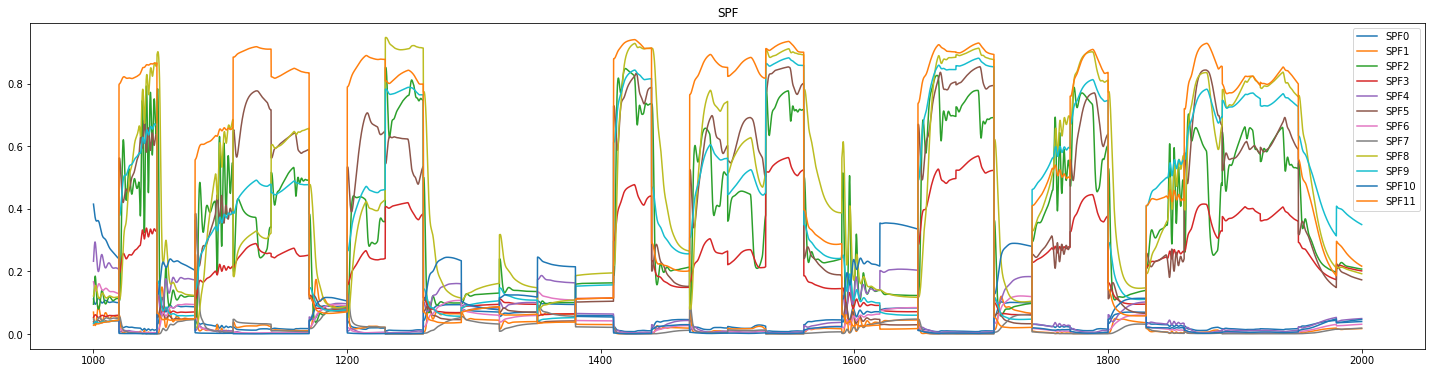

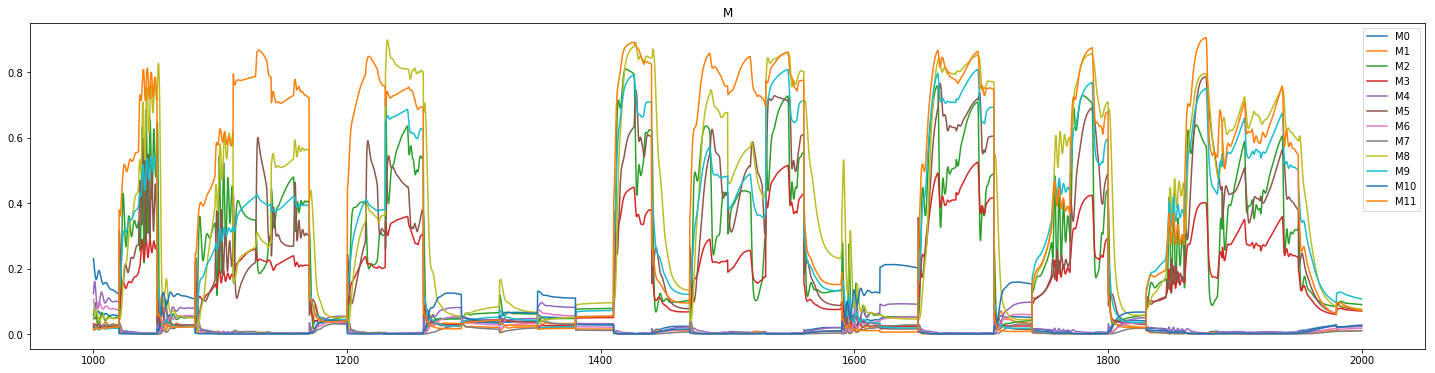

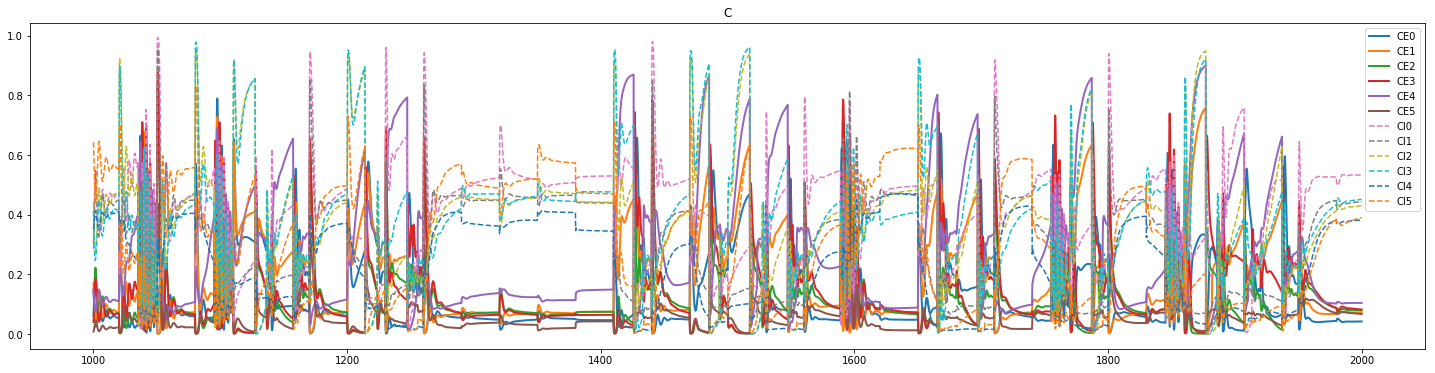

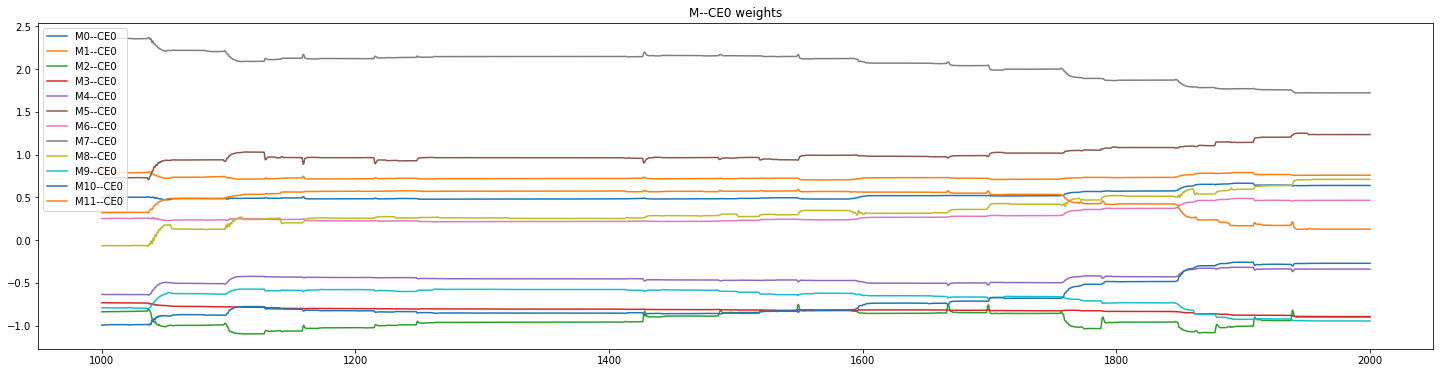

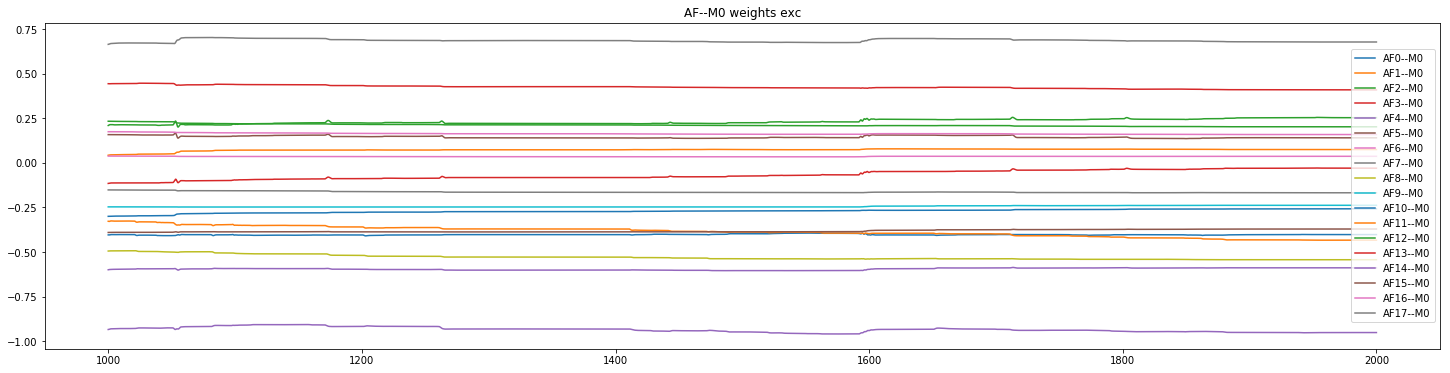

In [11]:
arm_activs = plant_data[P]
# SPF
fs = (25,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
SPF_legends = ['SPF'+str(i) for i in range(len(SPF))]
plt.legend(SPF_legends)
plt.title('SPF')
print(SPF_data[:,-1])

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
M_legends = ['M'+str(i) for i in range(len(M))]
plt.legend(M_legends)
plt.title('M')
print(M_data[:,-1])

# C
C_fig = plt.figure(figsize=fs)
CE_data = np.array(data[CE])
CI_data = np.array(data[CI])
plt.plot(times, CE_data.transpose(), linewidth=2)
plt.plot(times, CI_data.transpose(), '--')
C_legends = ['CE'+str(i) for i in range(len(CE))]
C_legends += ['CI'+str(i) for i in range(len(CI))]
plt.legend(C_legends)
plt.title('C')

# M--CE0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_CE_track])
plt.plot(times, w_track_data.transpose())
M_CE0_legends = ['M'+str(i)+'--CE0' for i in range(len(M_CE_track))]
plt.legend(M_CE0_legends)
plt.title('M--CE0 weights')

# AF--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[AF_M0_track[0:18]])
plt.plot(times, w_track_data2.transpose())
AF_M0_legends = ['AF'+str(i)+'--M0' for i in range(len(AF_M0_track[:18]))]
plt.legend(AF_M0_legends)
plt.title('AF--M0 weights exc')
"""
W_fig3 = plt.figure(figsize=fs)
w_track_data3 = np.array(data[AF_M0_track[18:]])
plt.plot(times, w_track_data3.transpose())
AF_M0_legends2 = ['AF'+str(i)+'--M0' for i in range(len(AF_M0_track[18:]))]
plt.legend(AF_M0_legends2)
plt.title('AF--M0 weights inh')
"""

plt.show()

shoulder angle: 0.689131, shoulder vel: 1.672150
AFe_data:
[8.52670477e-24 1.74484990e-23 3.61705366e-18 4.52013164e-20
 1.15464549e-21 5.20722607e-18 2.16205734e-02 3.22776502e-02
 3.83345620e-21 9.62921951e-21 4.30722768e-02 1.84226363e-20
 4.16017751e-02 4.78396315e-02 5.03464834e-18 9.39253122e-20
 6.78107605e-02 1.12649105e-21]
AFi_data:
[6.01177011e-02 1.49058739e-01 6.47835981e-02 5.52798272e-02
 1.85188071e-01 7.08204120e-02 5.50368172e-21 3.26197384e-20
 3.12924083e-02 2.09158941e-02 3.79498475e-20 4.64116899e-02
 1.75033873e-19 2.35593828e-17 4.69082404e-02 4.04778685e-02
 3.84438706e-21 7.31122396e-02]


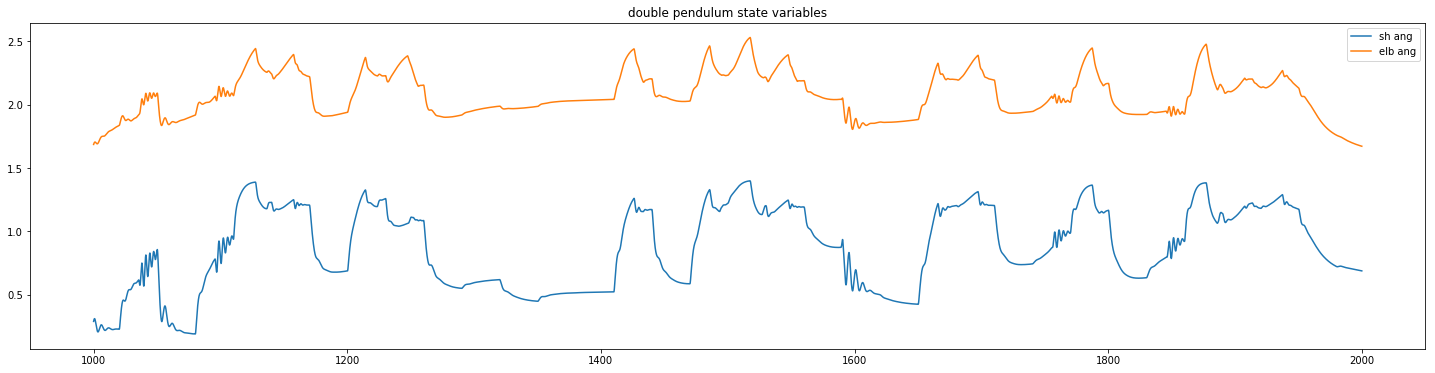

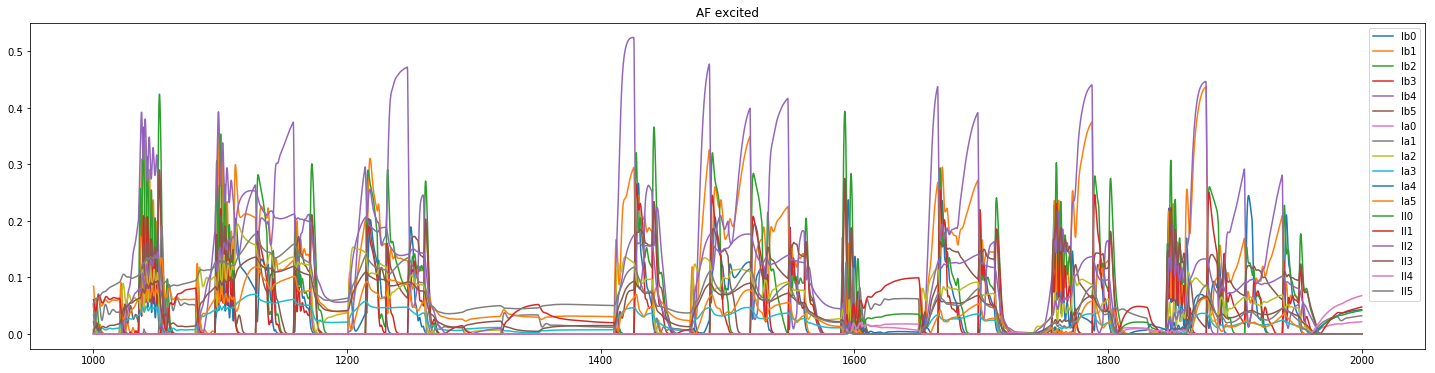

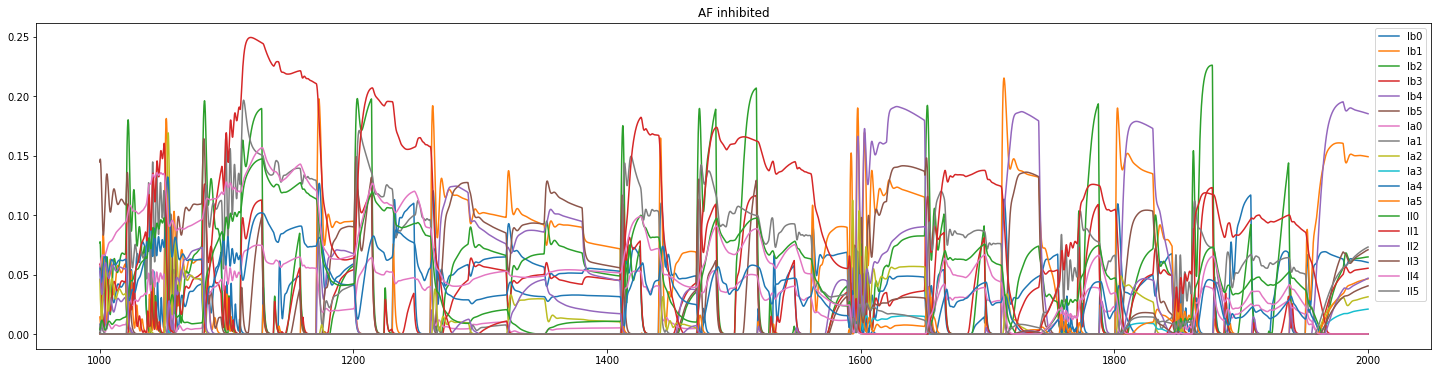

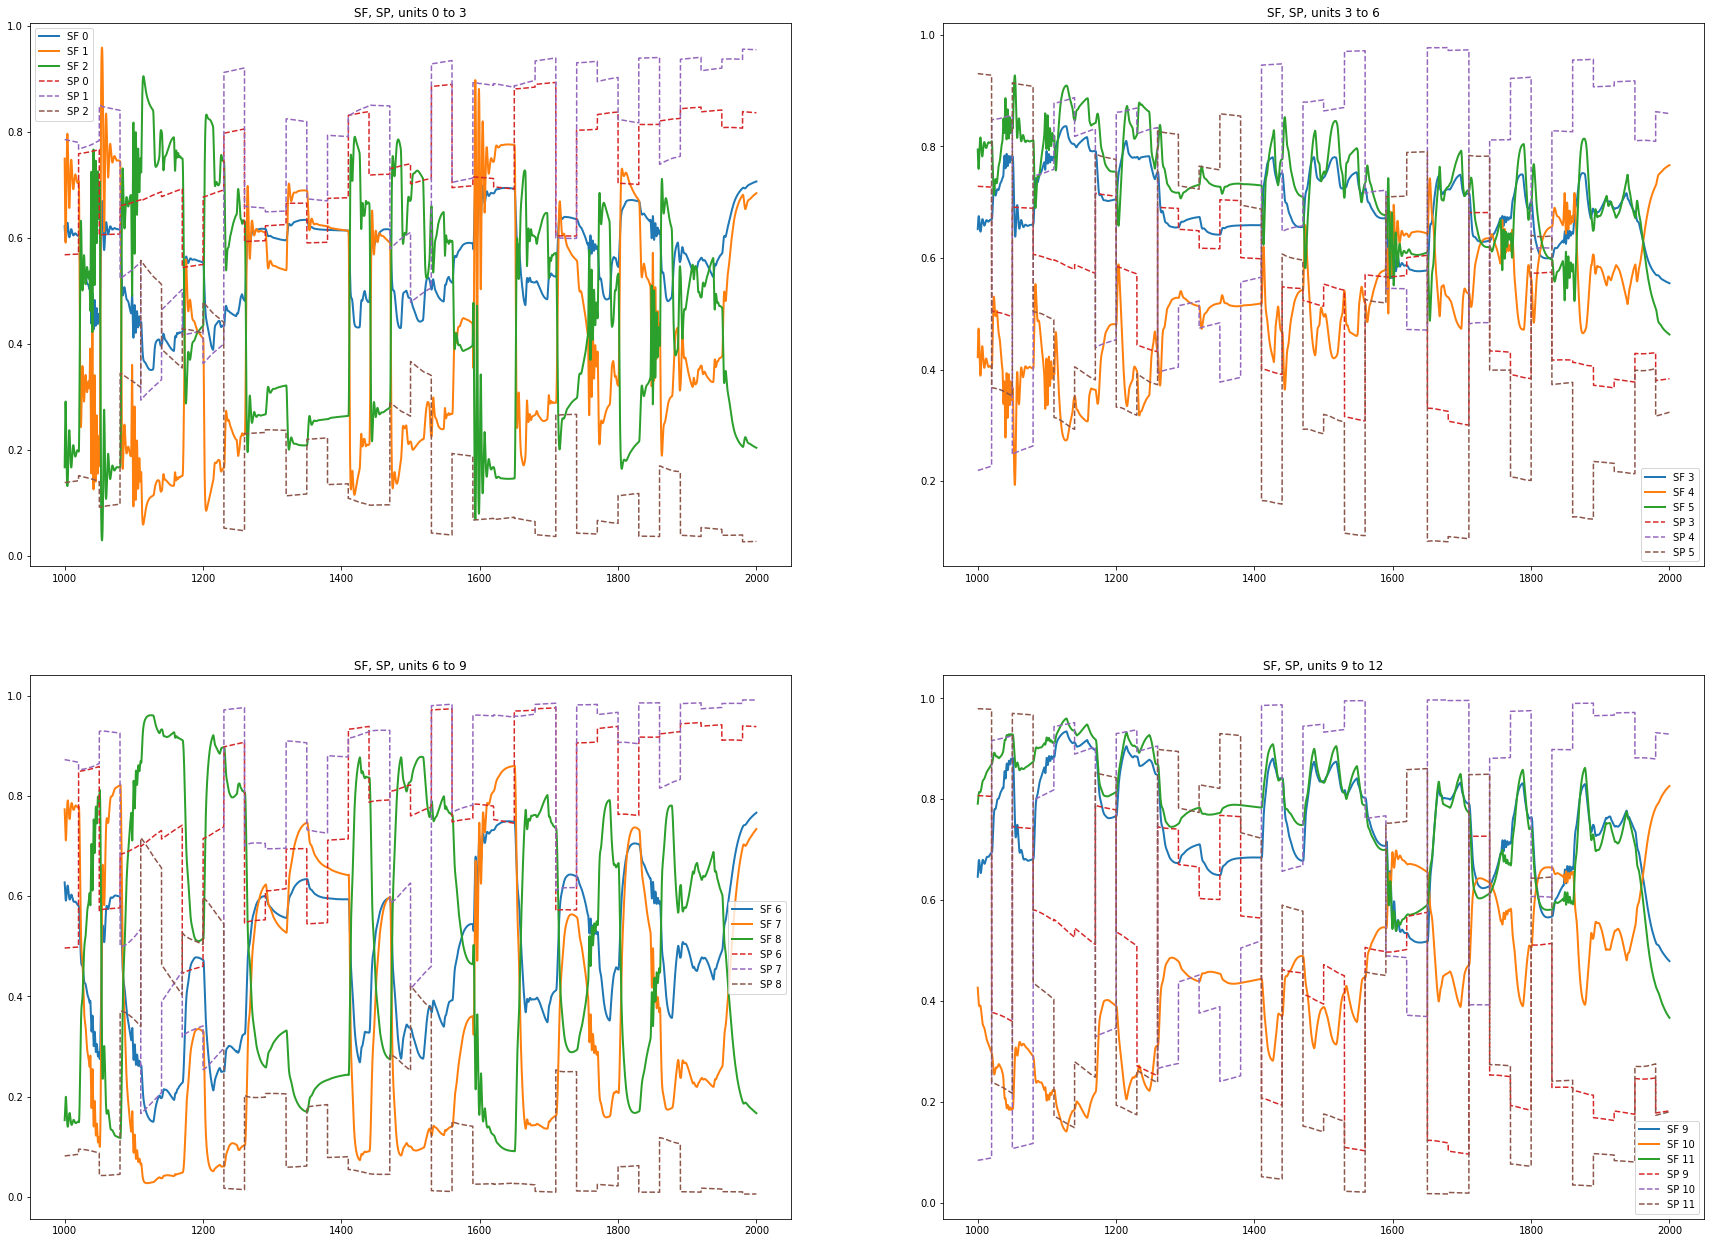

SF = 
[0.70663475 0.68452776 0.20440528 0.55473531 0.76641346 0.46281012
 0.76650907 0.73399104 0.16674162 0.47918795 0.82606904 0.36695301]
SP = 
[0.83620428 0.95515741 0.02772754 0.38367025 0.85872591 0.32354561
 0.93828656 0.99133644 0.00554654 0.18274662 0.92876169 0.18099788]


In [12]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[P][:,0:4:2]
plt.plot(times, P_state)
#plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.legend(['sh ang', 'elb ang',])
plt.title('double pendulum state variables')
print("shoulder angle: %f, shoulder vel: %f" % (P_state[-1,0],P_state[-1,1]))

# AF plus
AFe_fig = plt.figure(figsize=fs)
AFe_data = np.array(data[AF[0:18]])
plt.plot(times, AFe_data.transpose())
AF_legends = ['Ib' + str(i) for i in range(6)] + \
             ['Ia' + str(i) for i in range(6)] + \
             ['II' + str(i) for i in range(6)]
plt.legend(AF_legends)
plt.title('AF excited')
print('AFe_data:')
print(AFe_data[:,-1])

# AF minus
AFi_fig = plt.figure(figsize=fs)
AFi_data = np.array(data[AF[18:36]])
plt.plot(times, AFi_data.transpose())
AF_legends = ['Ib' + str(i) for i in range(6)] + \
             ['Ia' + str(i) for i in range(6)] + \
             ['II' + str(i) for i in range(6)]
plt.legend(AF_legends)
plt.title('AF inhibited')
print('AFi_data:')
print(AFi_data[:,-1])

fs = (30,10)
# SF, SP
SF_fig, axs = plt.subplots(2, 2, figsize=(fs[0], 2.2*fs[1]))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
for row in range(2):
    for col in range(2):
        ax = axs[row][col]
        base = 3*col + 6*row
        ax.plot(times, SF_data[base:base+3, :].transpose(), linewidth=2)
        ax.plot(times, SP_data[base:base+3, :].transpose(), '--')
        ax.set_title('SF, SP, units %d to %d' % (base, base+3))
        SF_legends = ['SF '+ str(base+i) for i in range(3)]
        SP_legends = ['SP '+ str(base+i) for i in range(3)]
        ax.legend(SF_legends + SP_legends)

plt.show()
print('SF = ')
print(SF_data[:,-1])
print('SP = ')
print(SP_data[:,-1])

average error: 0.340800


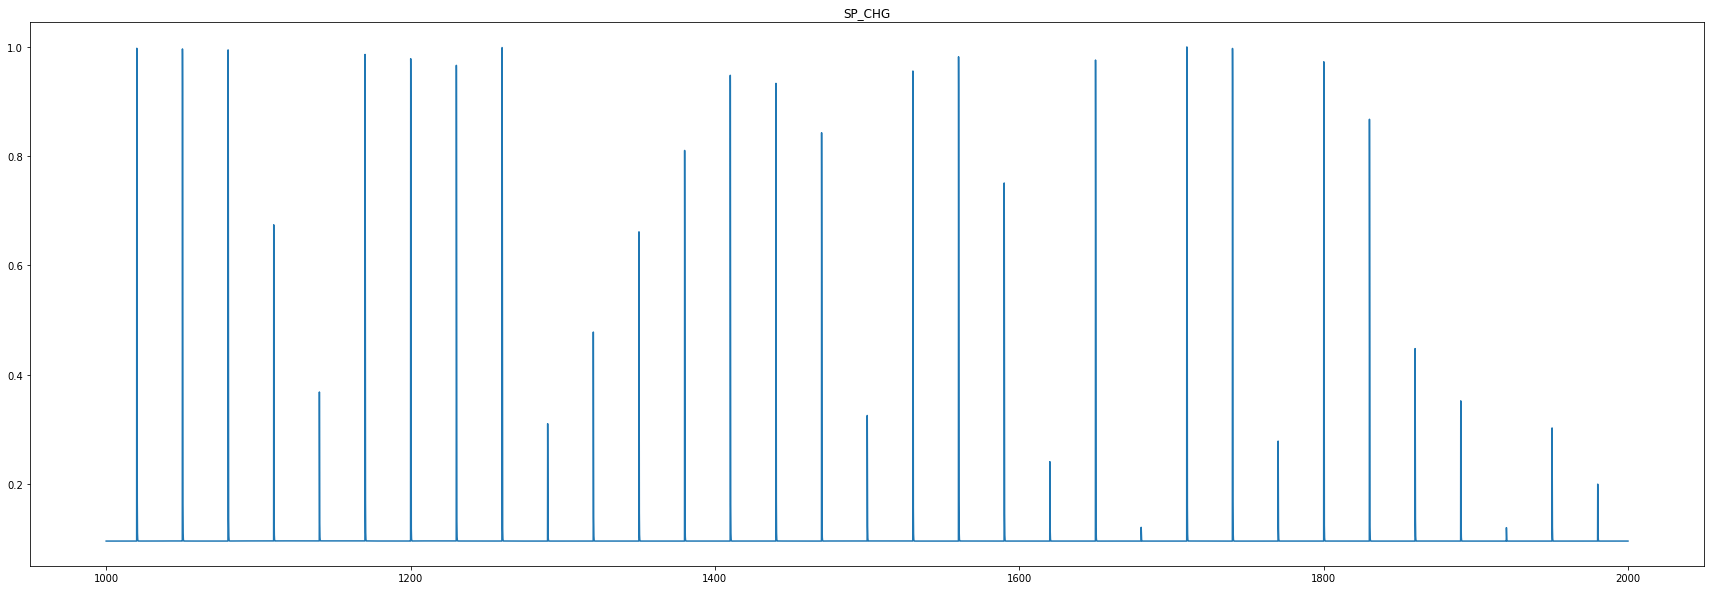

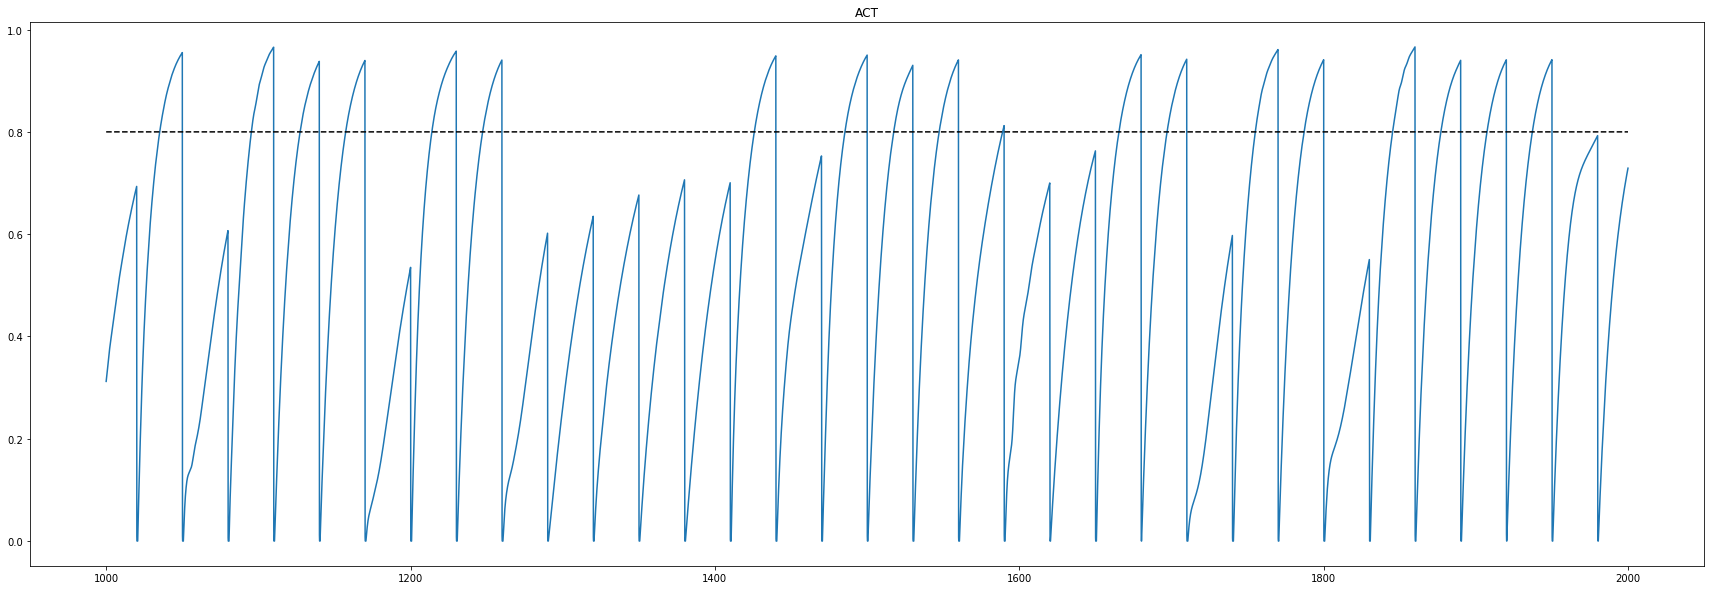

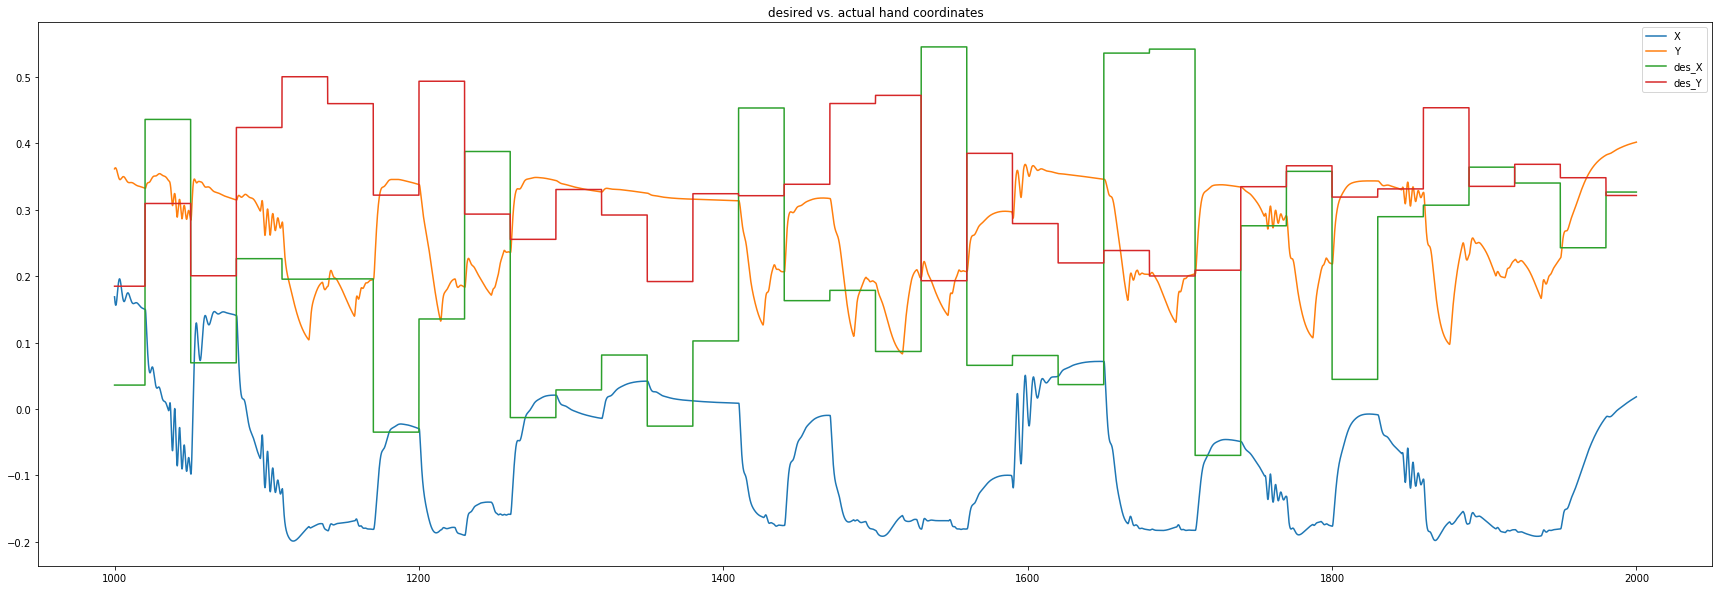

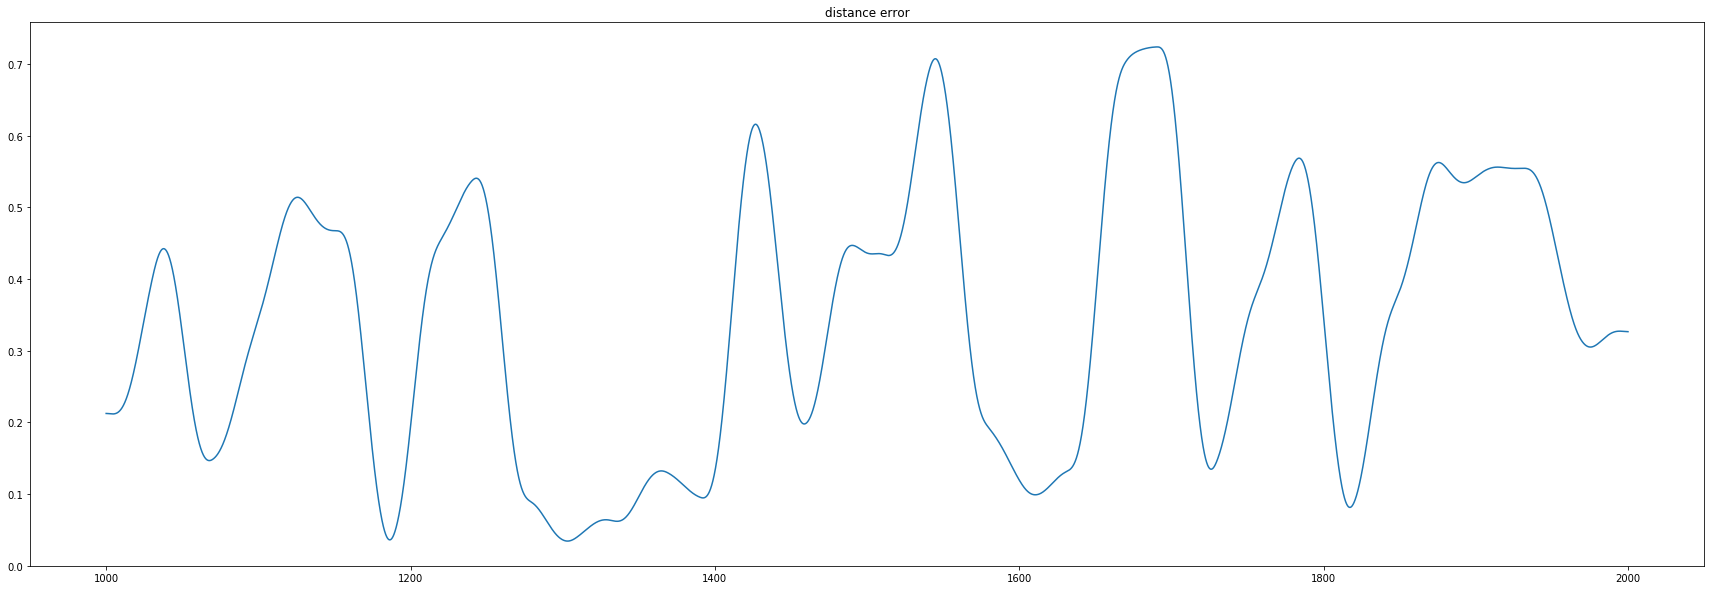

In [13]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

chg_fig = plt.figure(figsize=fs)
chg_data = np.array(data[SP_CHG])[0]
plt.plot(times, chg_data)
plt.title('SP_CHG')

act_fig = plt.figure(figsize=fs)
act_data = np.array(data[ACT])[0]
plt.plot(times, act_data)
plt.plot(times, 0.8*np.ones_like(times), 'k--')
plt.title('ACT')

plant = net.plants[P]
# modified copy-paste of plt.upd_ip_impl
q1 = arm_activs[:,0]
q2 = arm_activs[:,2]
q12 = q1+q2
c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                   c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
coord_idxs = np.floor(times/t_pres).astype(int)
des_coords = np.array(hand_coords)[m_idxs[coord_idxs],:] # desired coordinates at each moment in time
coords_fig = plt.figure(figsize=fs)
plt.plot(times, c_hand)
plt.plot(times, des_coords)
plt.title('desired vs. actual hand coordinates')
plt.legend(['X', 'Y', 'des_X', 'des_Y'])

err_fig = plt.figure(figsize=fs)
w_len = 8001
hand_error = np.linalg.norm(c_hand-des_coords, axis=1)
smooth_hand_error = smooth(hand_error, window_len=w_len)[int(np.floor(w_len/2)):-int(np.floor(w_len/2))]
plt.plot(times, smooth_hand_error)
plt.title('distance error')
avg_error = hand_error.sum()/hand_error.size
print("average error: %f" % (avg_error))

plt.show()

X=0
Delay modifiers:
[-0.06317790065929103, -0.09999682545510033, -0.09999999901846869, -0.009841062885924104, 0.20434969184880597, -0.09755848602997064, -0.06944241560351536, -0.09449768083654507, -0.08267621684922669, -0.05415250830773643, -0.06568058746148592, -0.035787612957855736]


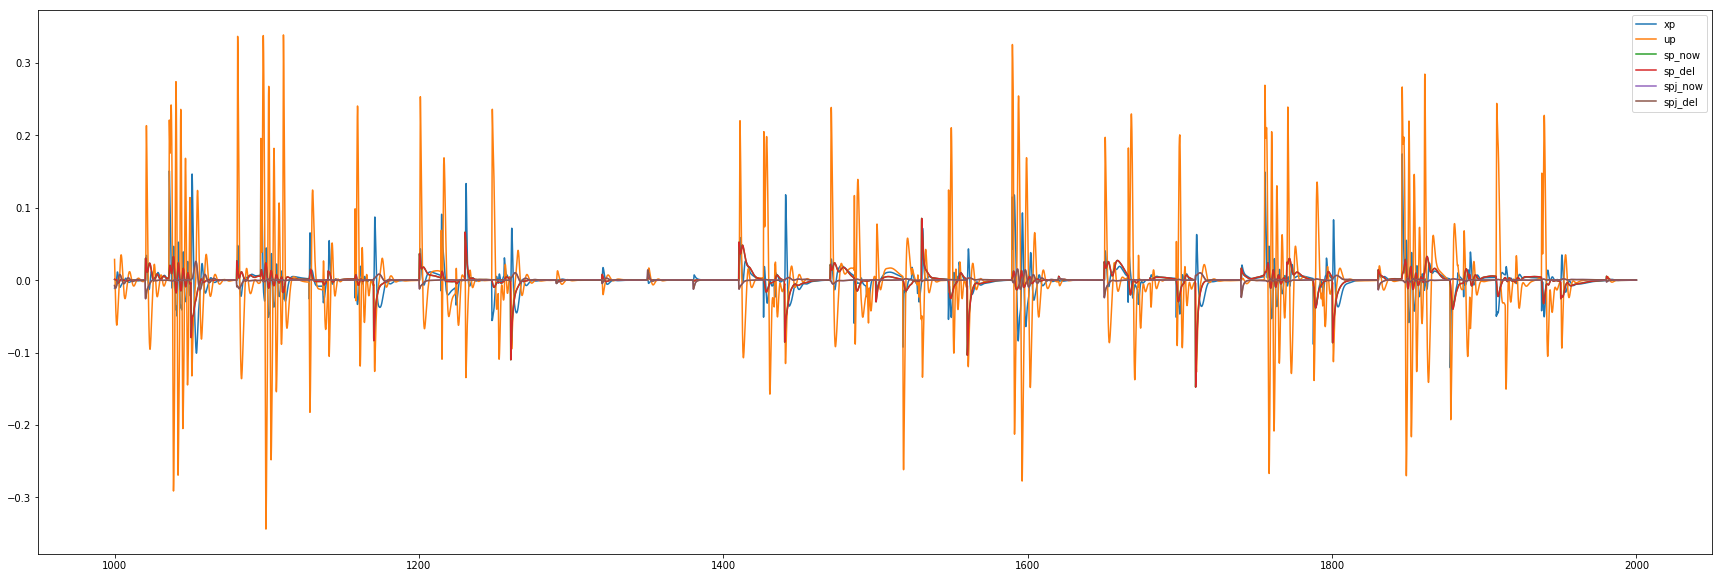

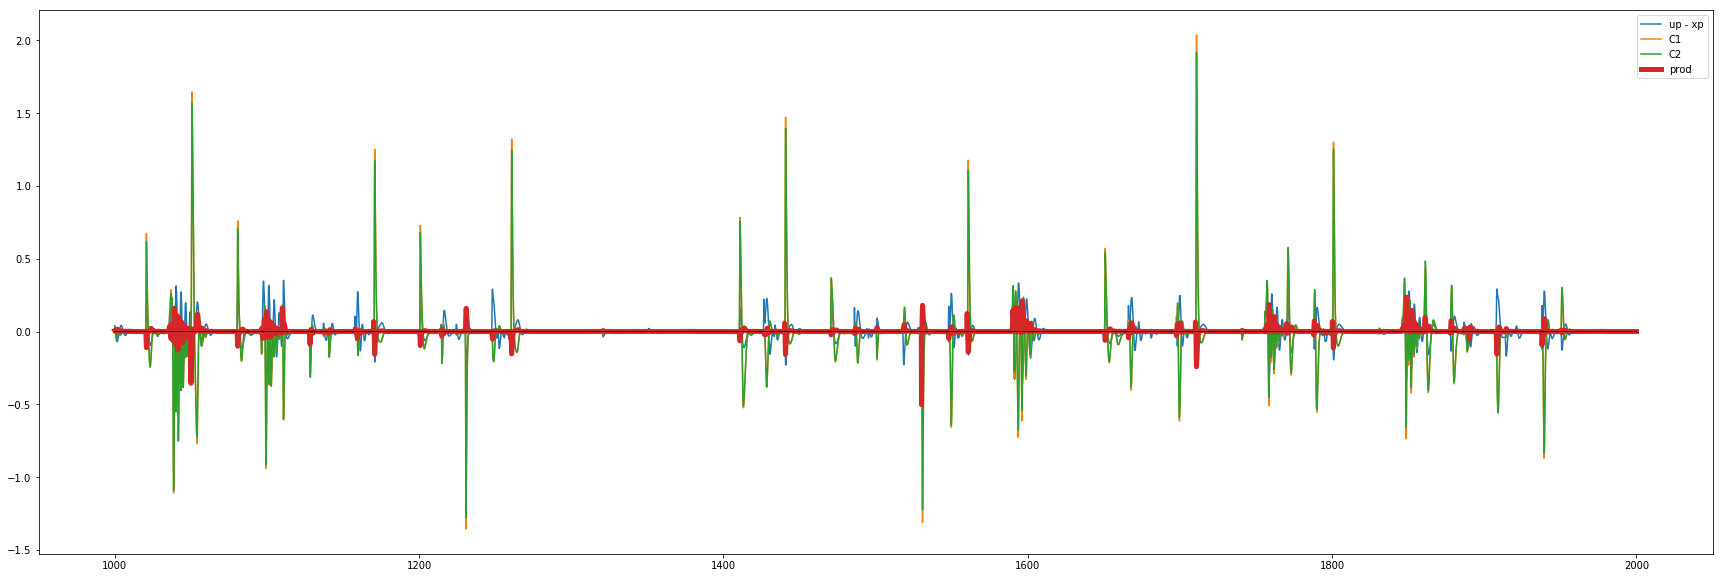

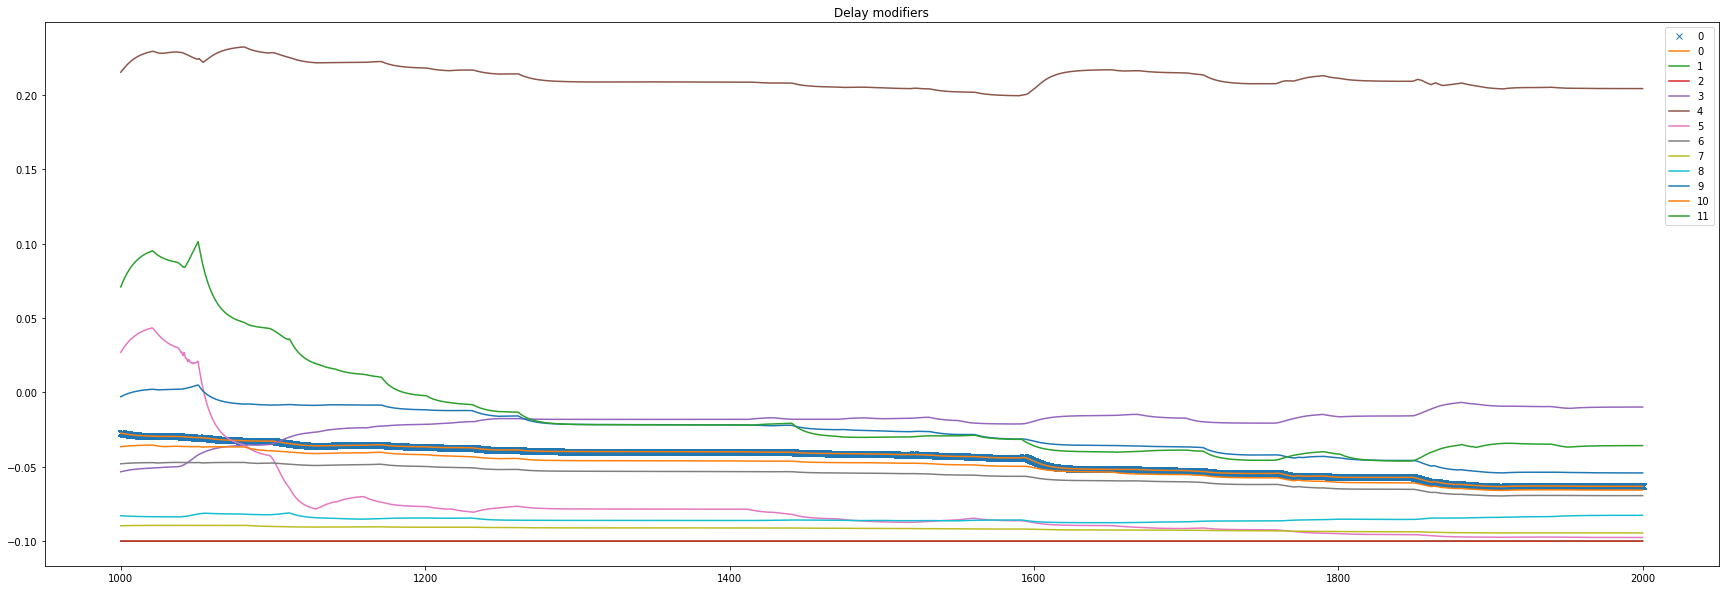

In [14]:
# plot all factors in the MX--C0 synaptic plasticity

print('X=%d' % (X))
#fs = (30,8)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_now_data = np.array(data[sp_now_track[0]])
sp_del_data = np.array(data[sp_del_track[0]])
spj_now_data = np.array(data[spj_now_track[0]])
spj_del_data = np.array(data[spj_del_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_now_data)
plt.plot(times, sp_del_data)
plt.plot(times, spj_now_data)
plt.plot(times, spj_del_data)
plt.legend(['xp', 'up', 'sp_now', 'sp_del', 'spj_now', 'spj_del'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
C2 = f1 * (sp_now_data - spj_now_data)
C1 = f1 * (sp_del_data - spj_del_data)
rule = 200. * (C2 - C1)
plt.plot(times, f1)
plt.plot(times, 100*C1)
plt.plot(times, 100*C2)
plt.plot(times, rule, linewidth=5)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'C1', 'C2', 'prod'])

del_mod_fig = plt.figure(figsize=fs)
del_mod_data = np.array(data[del_mod_track]).transpose()
plt.plot(times, del_mod_data[:,0], 'x')
plt.plot(times, del_mod_data)
plt.title('Delay modifiers')
del_mod_legends = ['0'] + [ str(i) for i in range(12)]
plt.legend(del_mod_legends)
print('Delay modifiers:')
print([syn.del_mod for syn in net.syns[CE[0]] if syn.preID in M])

plt.show()

AL_data:
[0.11155397 0.1316058  0.12090696 0.08556836 0.11696544 0.09318476]
Ib avg for muscle 0= 0.11930732640217473
Ia avg for muscle 0= 0.029170218303862613
II avg for muscle 0= 0.12624357834614583
Ib avg for muscle 1= 0.2871142461536173
Ia avg for muscle 1= -0.10707194454480654
II avg for muscle 1= -0.10620176731427423
Ib avg for muscle 2= 0.276099245993026
Ia avg for muscle 2= 0.31677037752428533
II avg for muscle 2= 0.5614530625201408
Ib avg for muscle 3= 0.12103699237910101
Ia avg for muscle 3= 0.16684085960237935
II avg for muscle 3= 0.40102075758306005
Ib avg for muscle 4= 0.25637622444256175
Ia avg for muscle 4= 0.04881124108986374
II avg for muscle 4= 0.13122682314369835
Ib avg for muscle 5= 0.2201671147264716
Ia avg for muscle 5= 0.16651311204540634
II avg for muscle 5= 0.32795123315276214


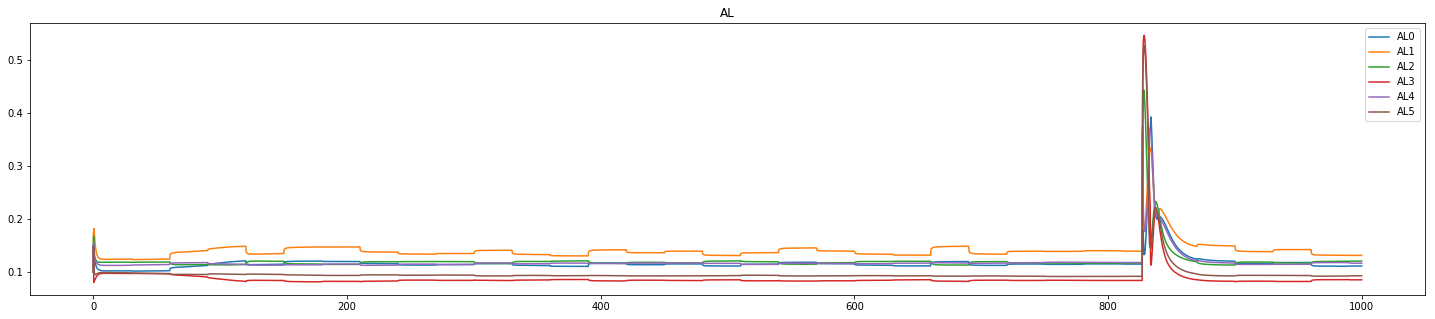

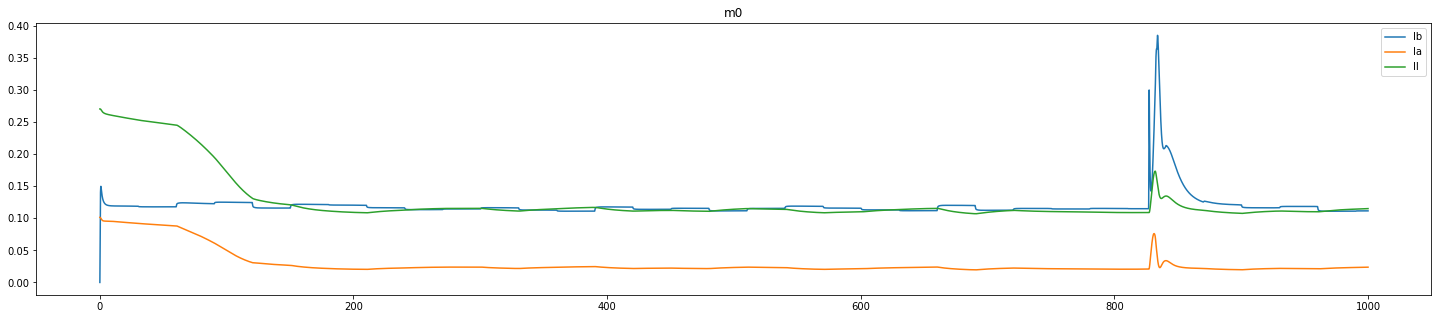

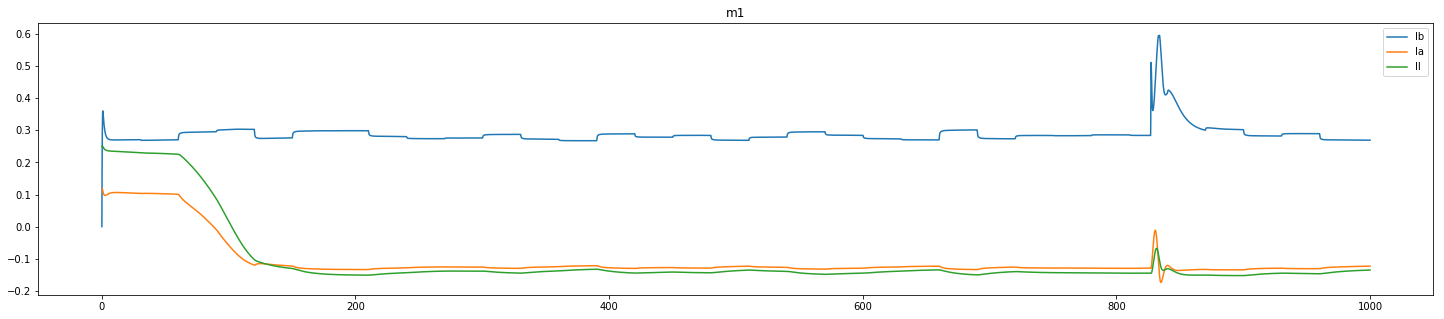

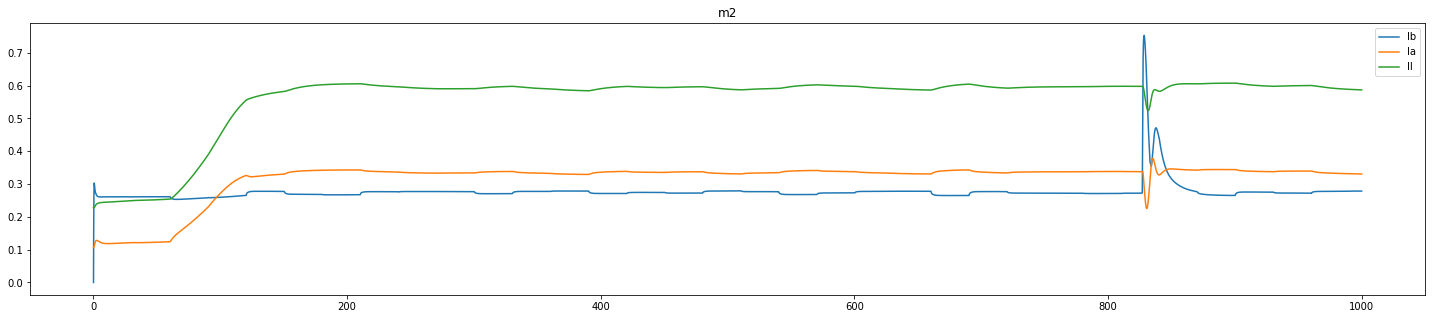

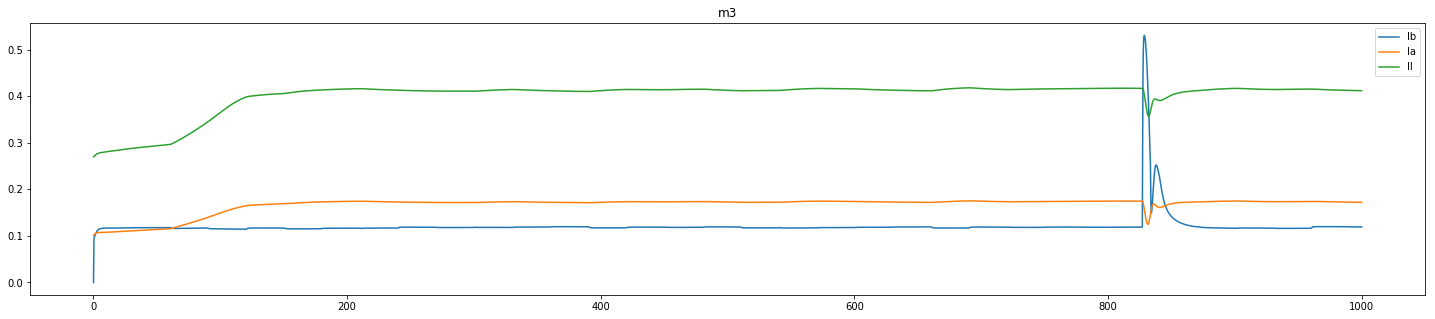

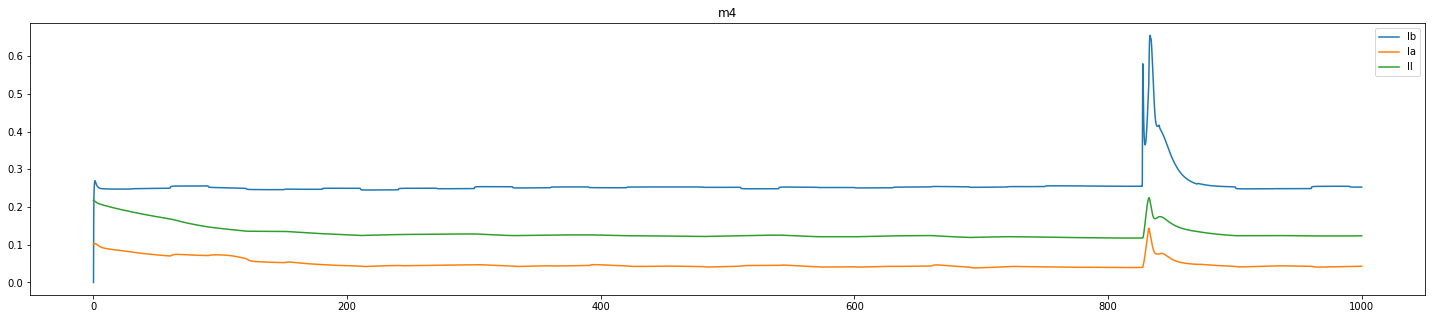

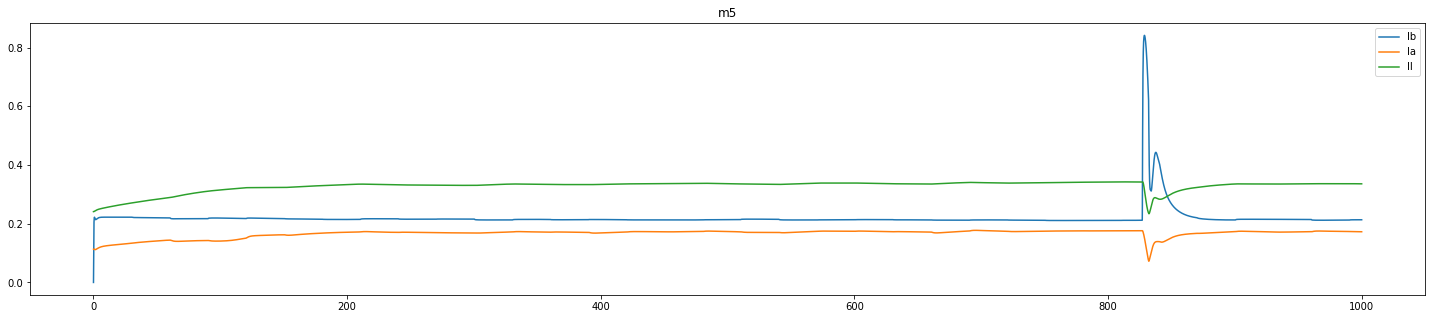

In [18]:
# Alpha units
fs2 =(25,5)
AL_fig = plt.figure(figsize=fs2)
AL_data = np.array(data[AL])
plt.plot(times, AL_data.transpose())
AL_legends = ['AL'+str(i) for i in range(len(AL))]
plt.legend(AL_legends)
plt.title('AL')
print('AL_data:')
print(AL_data[:,-1])

# plotting muscle outputs
#fs = (20,5)
legs = ['Ib', 'Ia', 'II']

for i in range(6):
    next_fig = plt.figure(figsize=fs2)
    Ib = arm_activs[:,22+i]
    Ia = arm_activs[:,28+i]
    II = arm_activs[:,34+i]
    plt.plot(times, Ib, times, Ia, times, II)
    #plt.plot(times, Ib)
    plt.legend(legs)
    plt.title('m' + str(i))
    print('Ib avg for muscle '+ str(i) + '= ' + str(np.mean(Ib)))
    print('Ia avg for muscle '+ str(i) + '= ' + str(np.mean(Ia)))
    print('II avg for muscle '+ str(i) + '= ' + str(np.mean(II)))
plt.show()

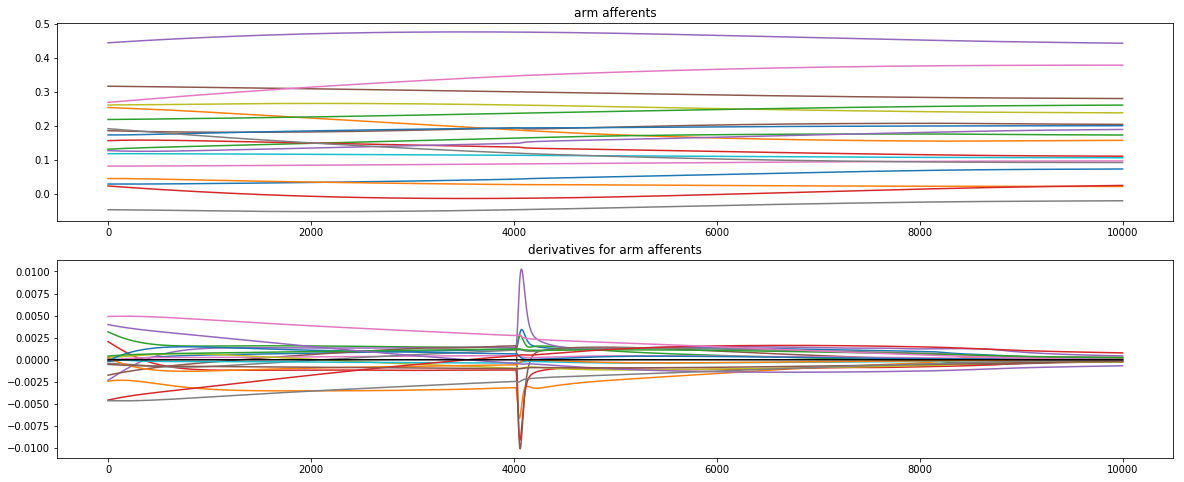

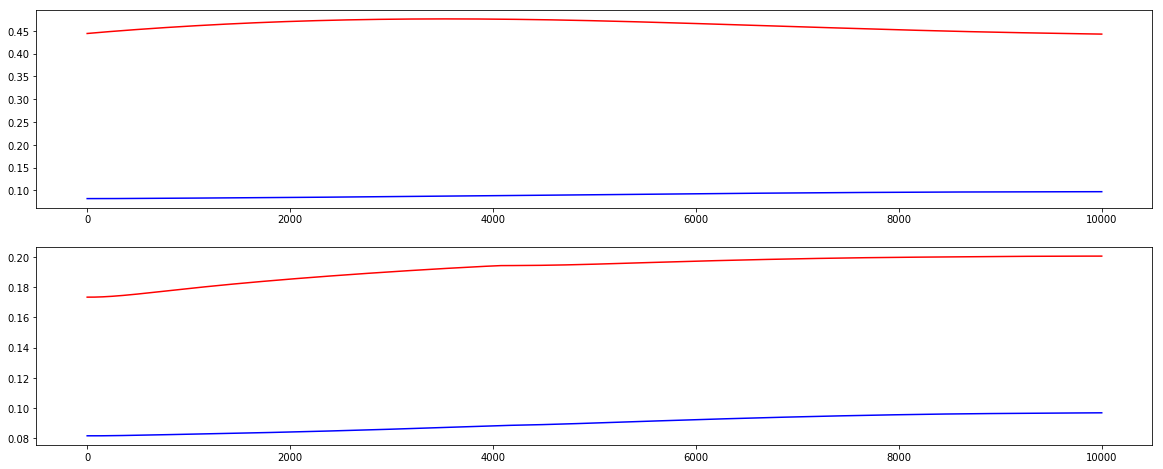

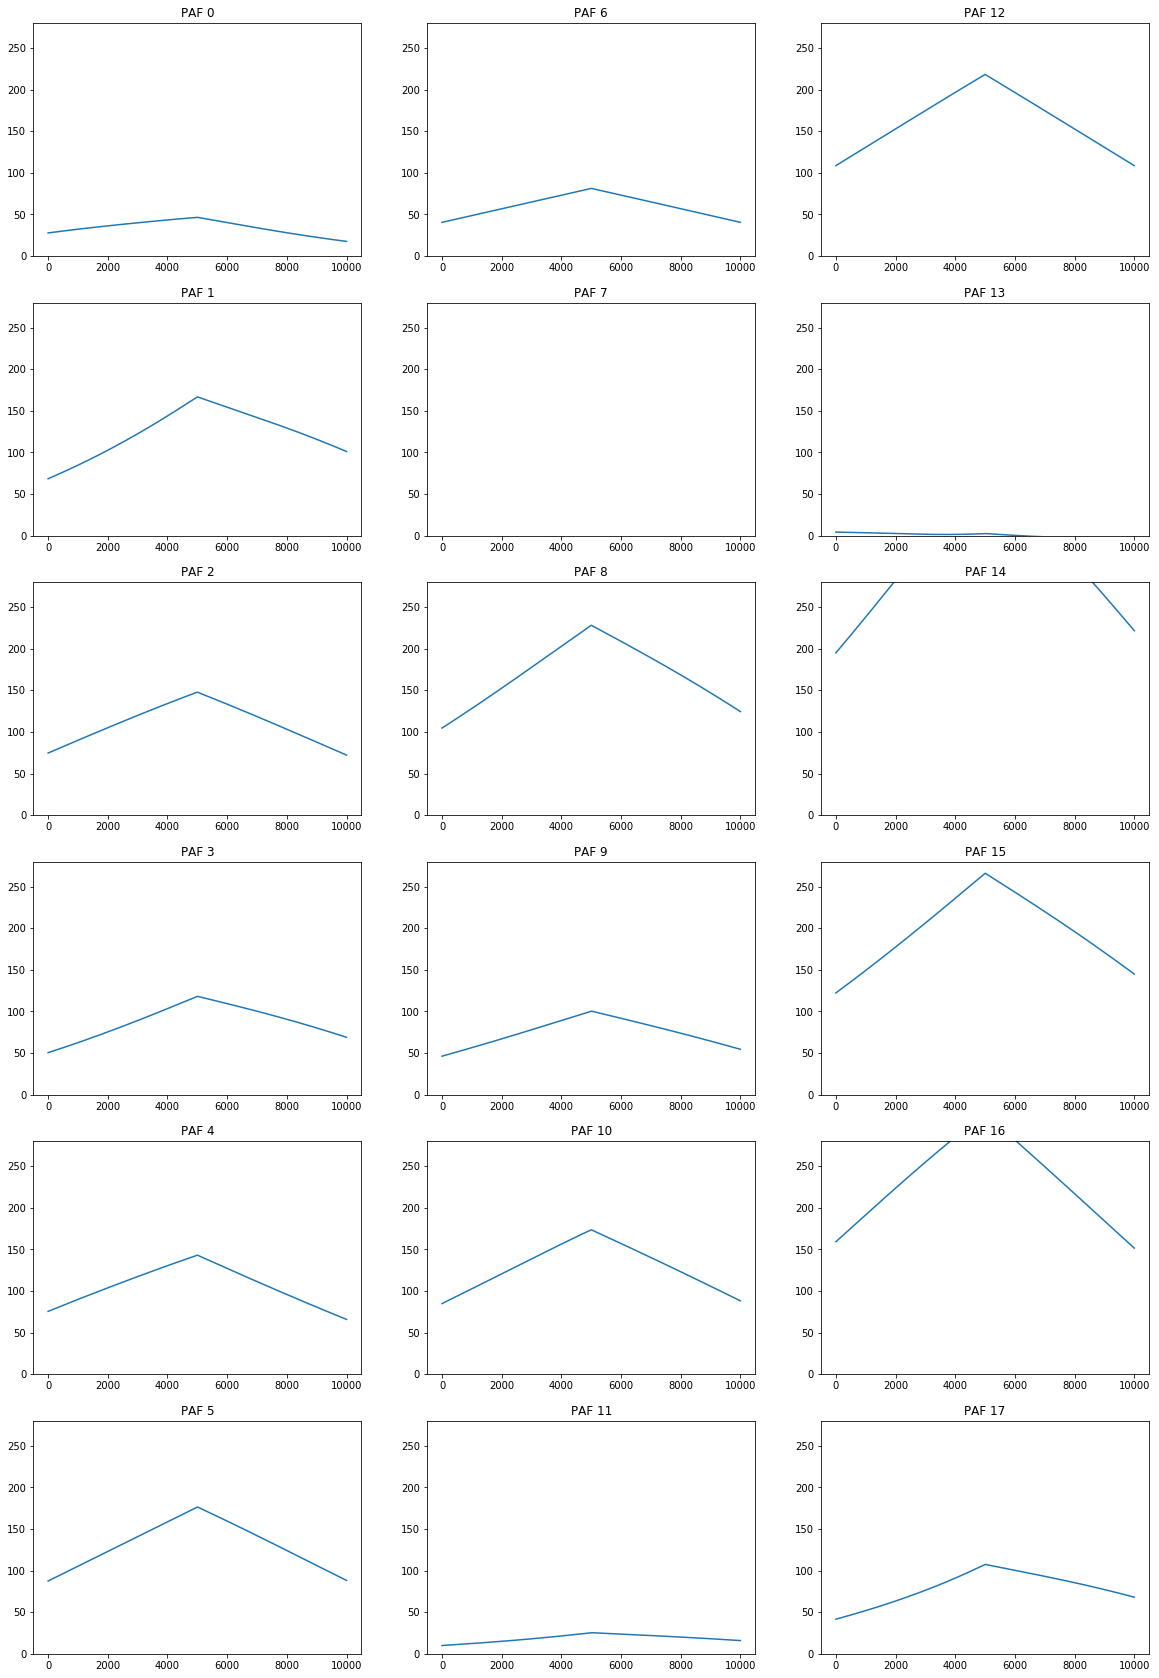

In [16]:
# ANALYSIS OF CORRELATIONS BETWEEN ARM AFFERENTS

# obtaining arm afferents and their derivatives
PAF = arm_activs[:10000, 22:40]
PAF_diff = np.gradient(PAF, axis=0) / net.min_delay
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(PAF)
axs[0].set_title('arm afferents')
axs[1].plot(PAF_diff)
axs[1].set_title('derivatives for arm afferents')
axs[1].plot(np.zeros(PAF_diff.shape[0]), 'k')

# comparing some signals
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(PAF[:,6], 'b', PAF[:,14], 'r')
axs[1].plot(PAF[:,6], 'b', PAF[:,10], 'r')

# plotting the correlation of one signal against all others
corr_fig, corr_axs = plt.subplots(6, 3, figsize=(20,30))
for col in range(3):
    for row in range(6):
        #corr = np.correlate(PAF_diff[:,6], PAF_diff[:, 6*col+row], mode='same')
        corr = np.correlate(PAF[:,6], PAF[:, 6*col+row], mode='same')
        corr_axs[row,col].plot(corr)
        corr_axs[row,col].set_ylim([0,280])
        corr_axs[row,col].set_title('PAF ' + str(6*col+row))
plt.show()

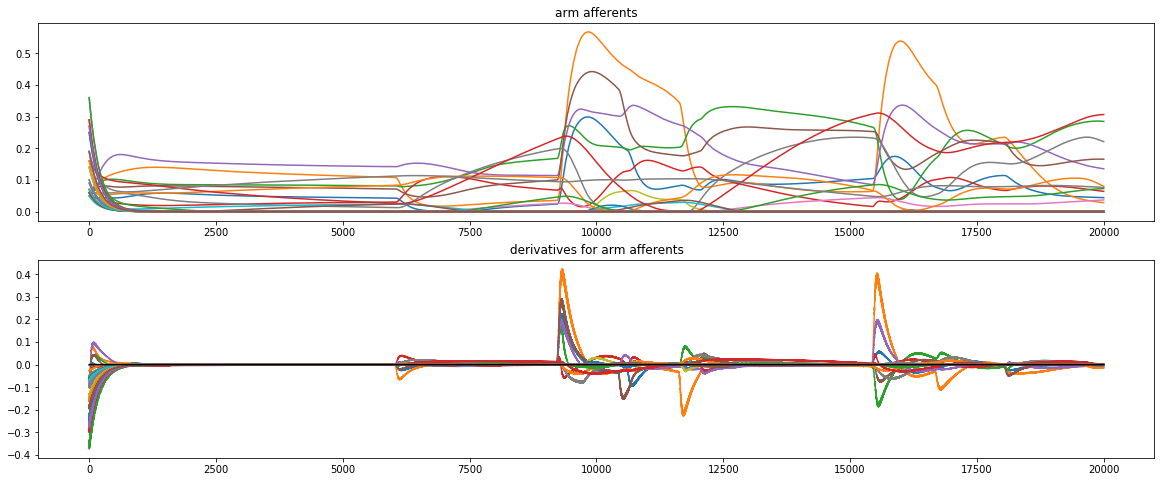

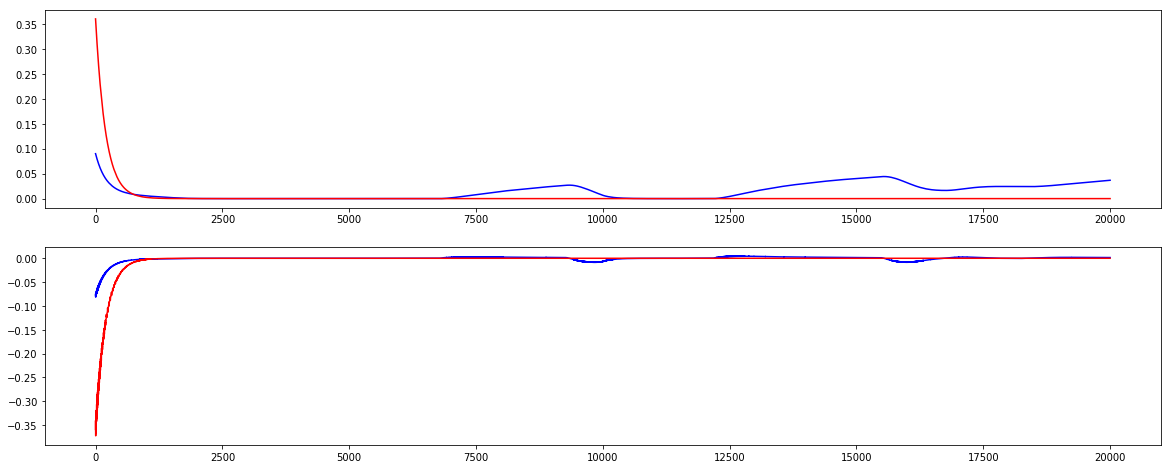

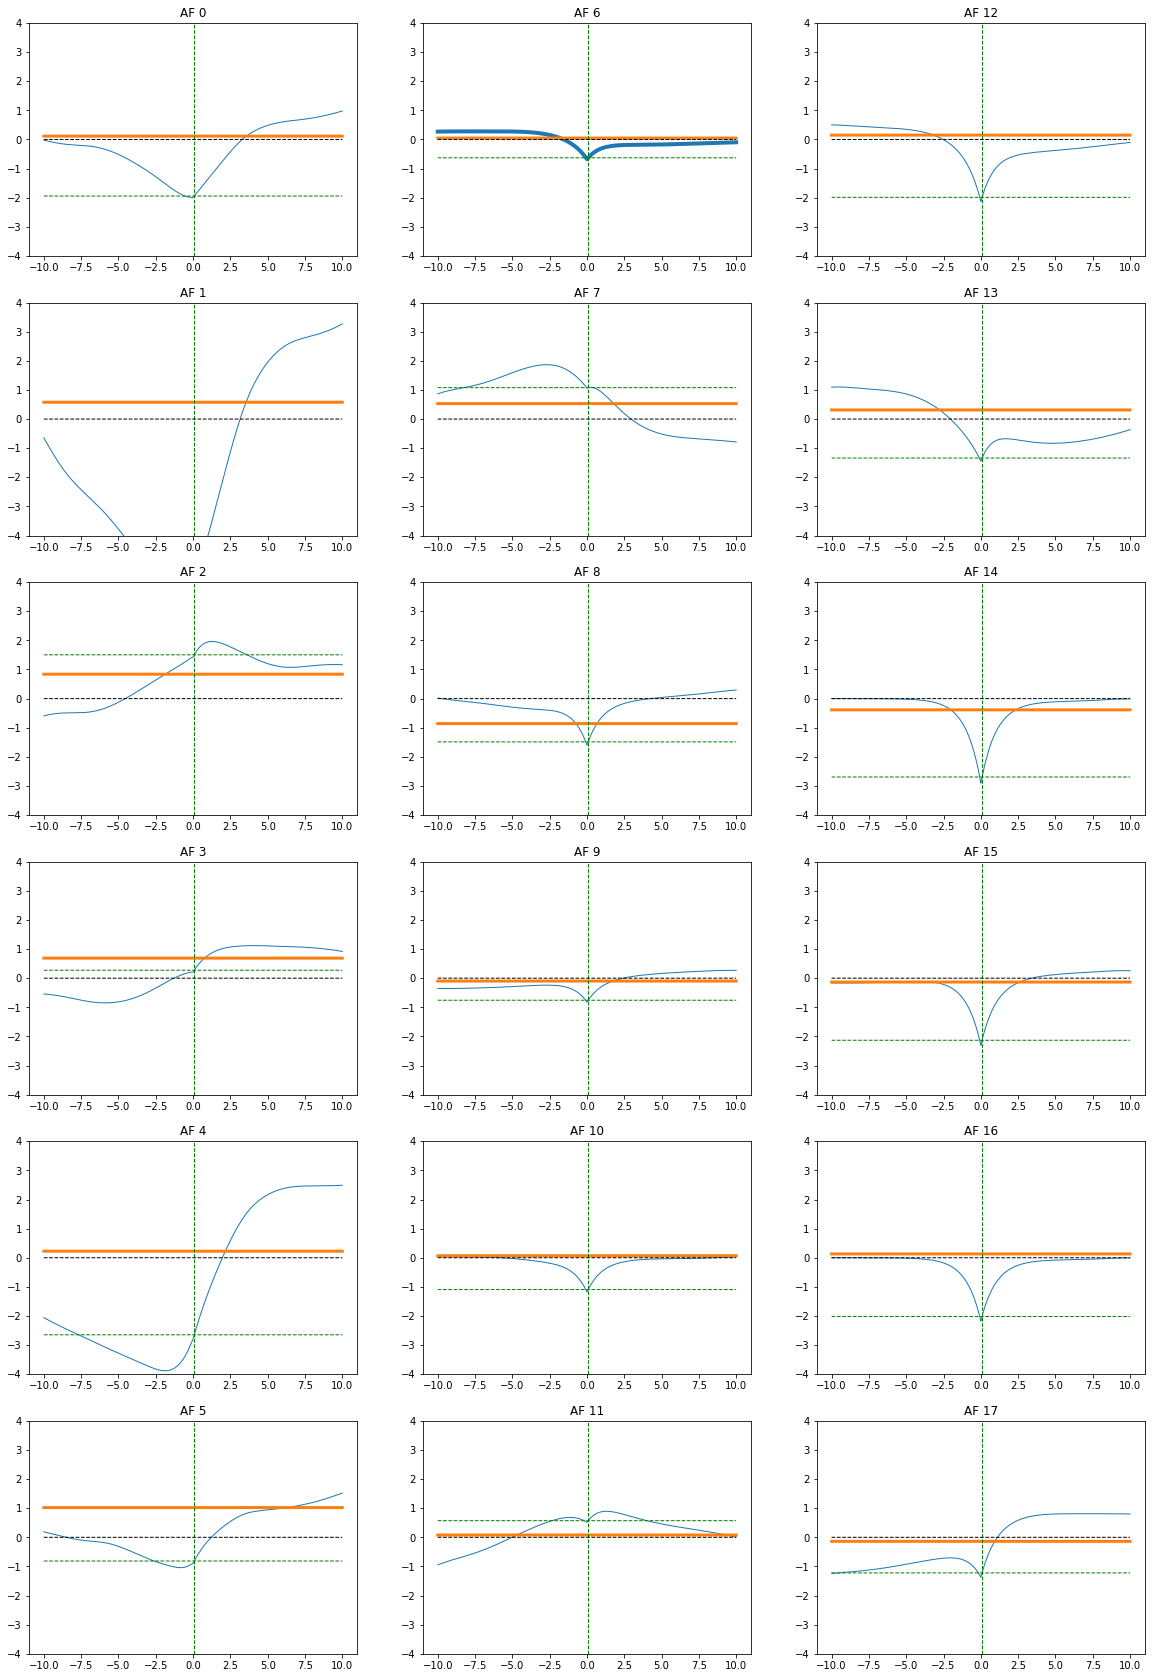

In [10]:
# ANALYSIS OF CORRELATIONS BETWEEN AFFERENT UNITS 
##############################
### NON-NORMALIZED VERSION ###
##############################
# obtaining arm afferents and their derivatives
AFD = data[AF,:20000].transpose()
AFD_diff = np.gradient(AFD, axis=0) / net.min_delay
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(AFD)
axs[0].set_title('arm afferents')
axs[1].plot(AFD_diff)
axs[1].set_title('derivatives for arm afferents')
axs[1].plot(np.zeros(AFD_diff.shape[0]), 'k')

# comparing some signals
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(AFD[:,6], 'b', AFD[:,14], 'r')
axs[1].plot(AFD_diff[:,6], 'b', AFD_diff[:,14], 'r')

# plotting the correlation of one signal against all others
AF__M0_w = [syn.w for syn in net.syns[M[0]] if syn.preID in AF]
corr_fig, corr_axs = plt.subplots(6, 3, figsize=(20,30))
base_idx = 6 # index for positive Ia afferent for muscle 0
mid = int(round(AFD.shape[0]/2.)) # middle index for the signal (where 0 is)
span = min(2000, mid)   # span to plot for the correlation
t = np.linspace(-span*net.min_delay, span*net.min_delay, 2*span)
max_c = 4
min_c = -4
des_val_idx = mid + AF__M_syn['extra_steps']
for col in range(3):
    for row in range(6):
        cur_idx = 6*col+row
        if cur_idx == base_idx: lw = 4
        else: lw = 1
        corr = np.correlate(AFD_diff[:,base_idx], AFD[:,cur_idx], mode='same') # what M0 should be obtaining?
        corr_axs[row,col].plot(t, corr[mid-span:mid+span], linewidth=lw)
        corr_axs[row,col].set_ylim([min_c,max_c])
        corr_axs[row,col].plot(t, 1.*AF__M0_w[cur_idx]*np.ones(len(t)), linewidth=3)
        corr_axs[row,col].plot(t, corr[des_val_idx]*np.ones(len(t)), 'g--', linewidth=1)
        x = t[int(len(t)/2)+AF__M_syn['extra_steps']]
        corr_axs[row,col].plot([x, x], [min_c, max_c], 'g--', linewidth=1)
        corr_axs[row,col].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
        corr_axs[row,col].set_title('AF ' + str(cur_idx))
plt.show()

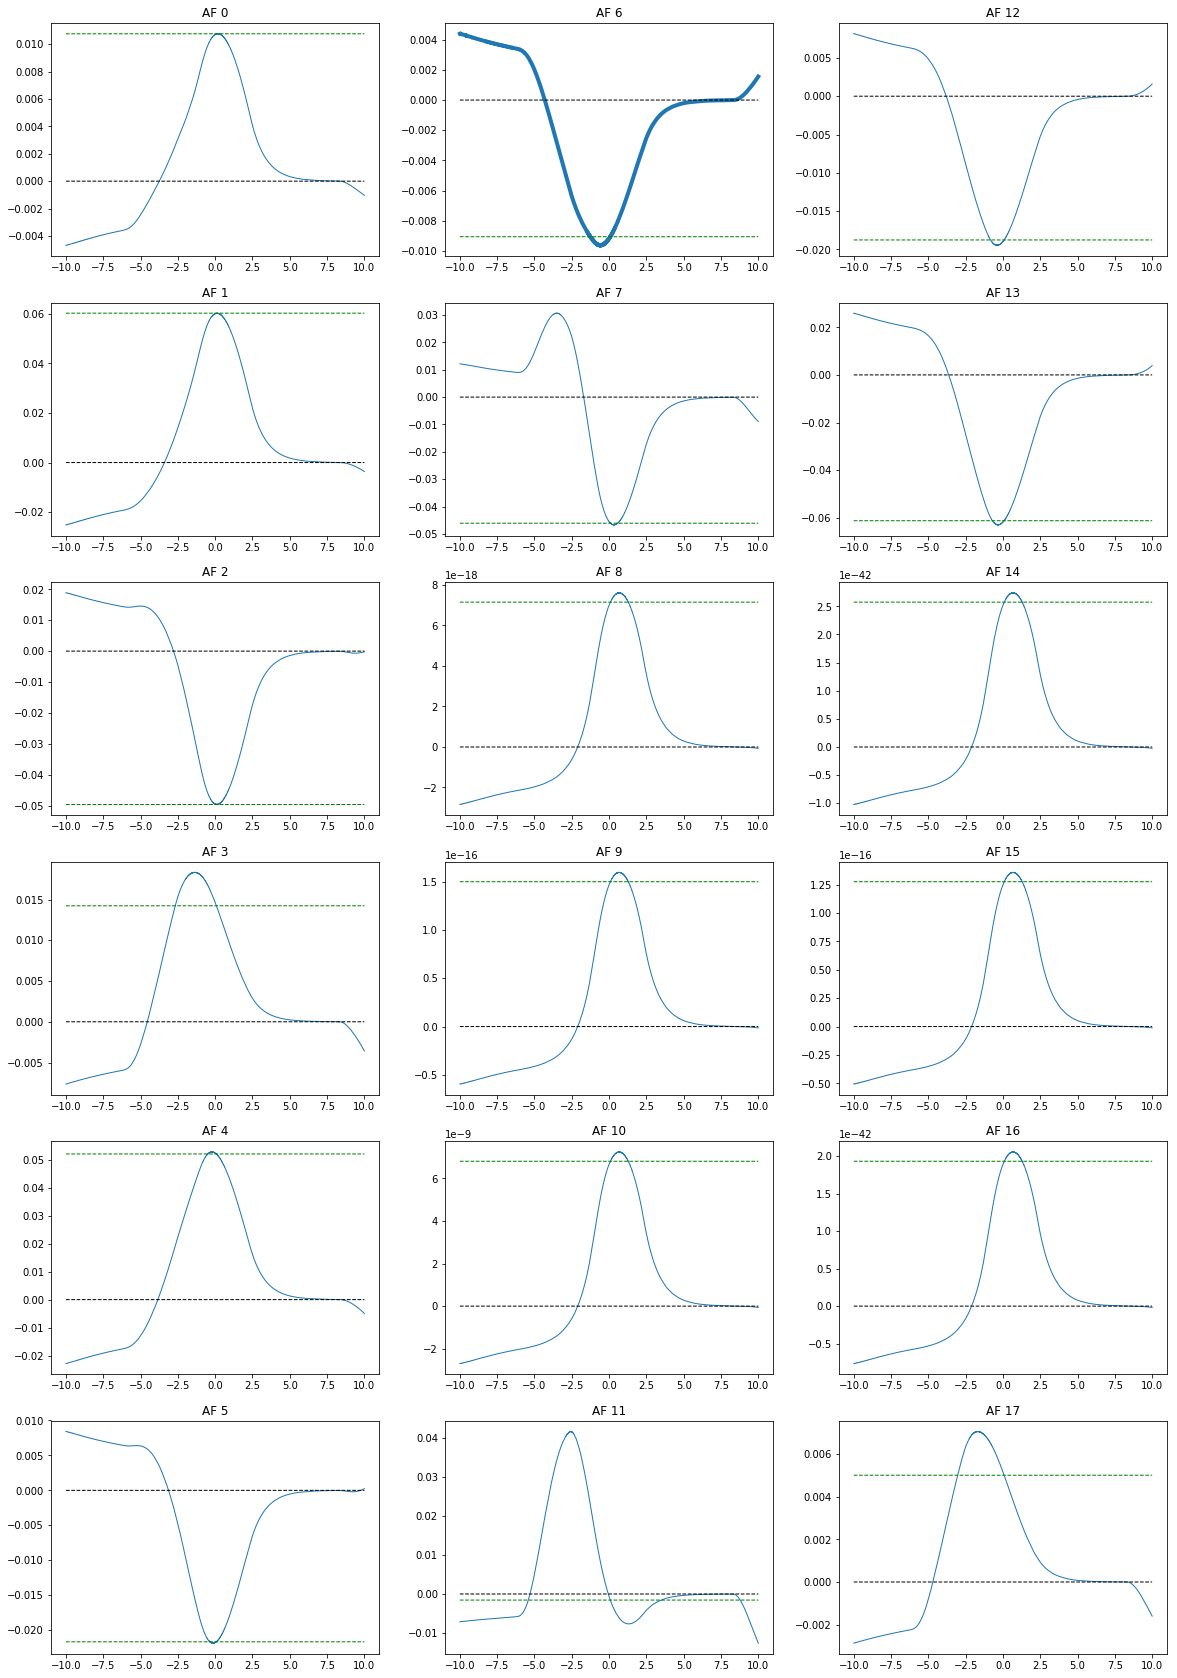

In [11]:
# plotting AF_diff VS AF_diff instead of AF_diff VS AF, to see if 
# the correlations are more informative
corr_fig2, corr_axs2 = plt.subplots(6, 3, figsize=(20,30))
#max_c = .6
#min_c = -.6
hspan = int(round(span/2.))
hlen = int(round(len(AFD_diff[:,0])))
AFD_diff_red = AFD_diff[hlen-hspan:hlen+hspan, :]
for col in range(3):
    for row in range(6):
        cur_idx = 6*col+row
        if cur_idx == base_idx: lw = 4
        else: lw = 1
        corr = np.correlate(AFD_diff[:,base_idx], AFD_diff_red[:,cur_idx], mode='same')
        corr_axs2[row,col].plot(t, corr[mid-span:mid+span], linewidth=lw)
        #corr_axs2[row,col].set_ylim([min_c,max_c])
        #corr_axs2[row,col].plot(t, 1.*AF__M0_w[cur_idx]*np.ones(len(t)), linewidth=3)
        corr_axs2[row,col].plot(t, corr[des_val_idx]*np.ones(len(t)), 'g--', linewidth=1)
        x = t[int(len(t)/2)+AF__M_syn['extra_steps']]
        #corr_axs2[row,col].plot([x, x], [min_c, max_c], 'g--', linewidth=1)
        corr_axs2[row,col].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
        corr_axs2[row,col].set_title('AF ' + str(cur_idx))
plt.show()

In [12]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


In [13]:
len(data[M[0]])

200000

## How to interpret the plots below
**For the first two plot grids**:  
The value at `t=0` is the that comes from using the current `custom_inp_del(2)` values in the rga_diff rule.
Negative `t` values correspond to delay in the M signal, which is what makes most sense in the physical implementation. The value at `t=-x` can be interpreted as the direction of change that the rga_diff learning rule would imply if both `custom_inp_del` and `custom_inp_del2` were increased by `x` time units.


**For the third plot grid**:  
The value at `t=0` is the value of the M-C correlation when C is delayed by `custom_inp_del2`. Values to the left imply increasing the delay in C.

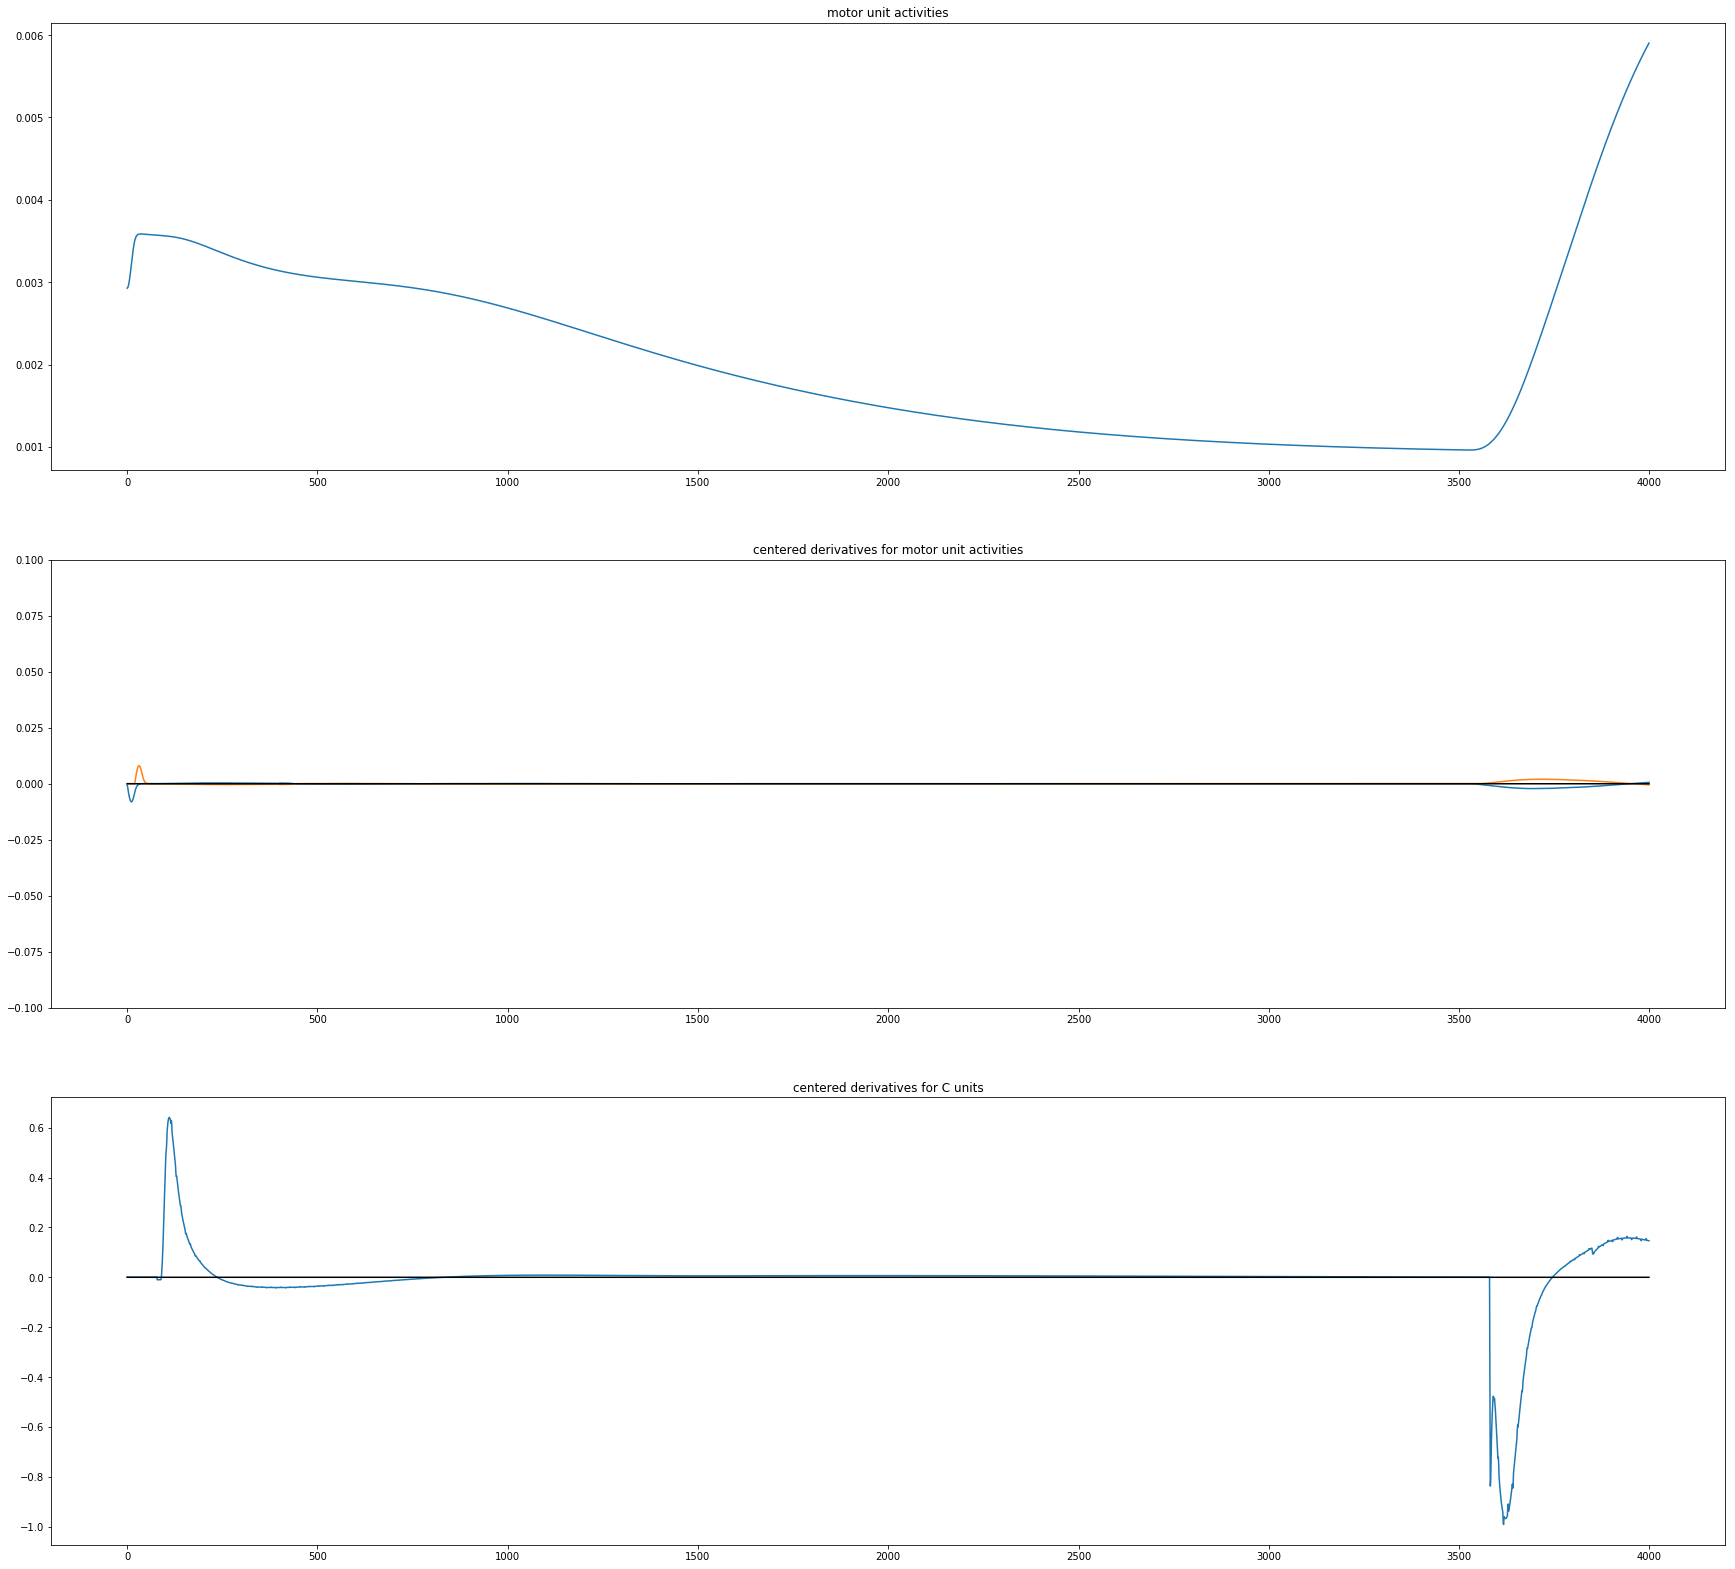

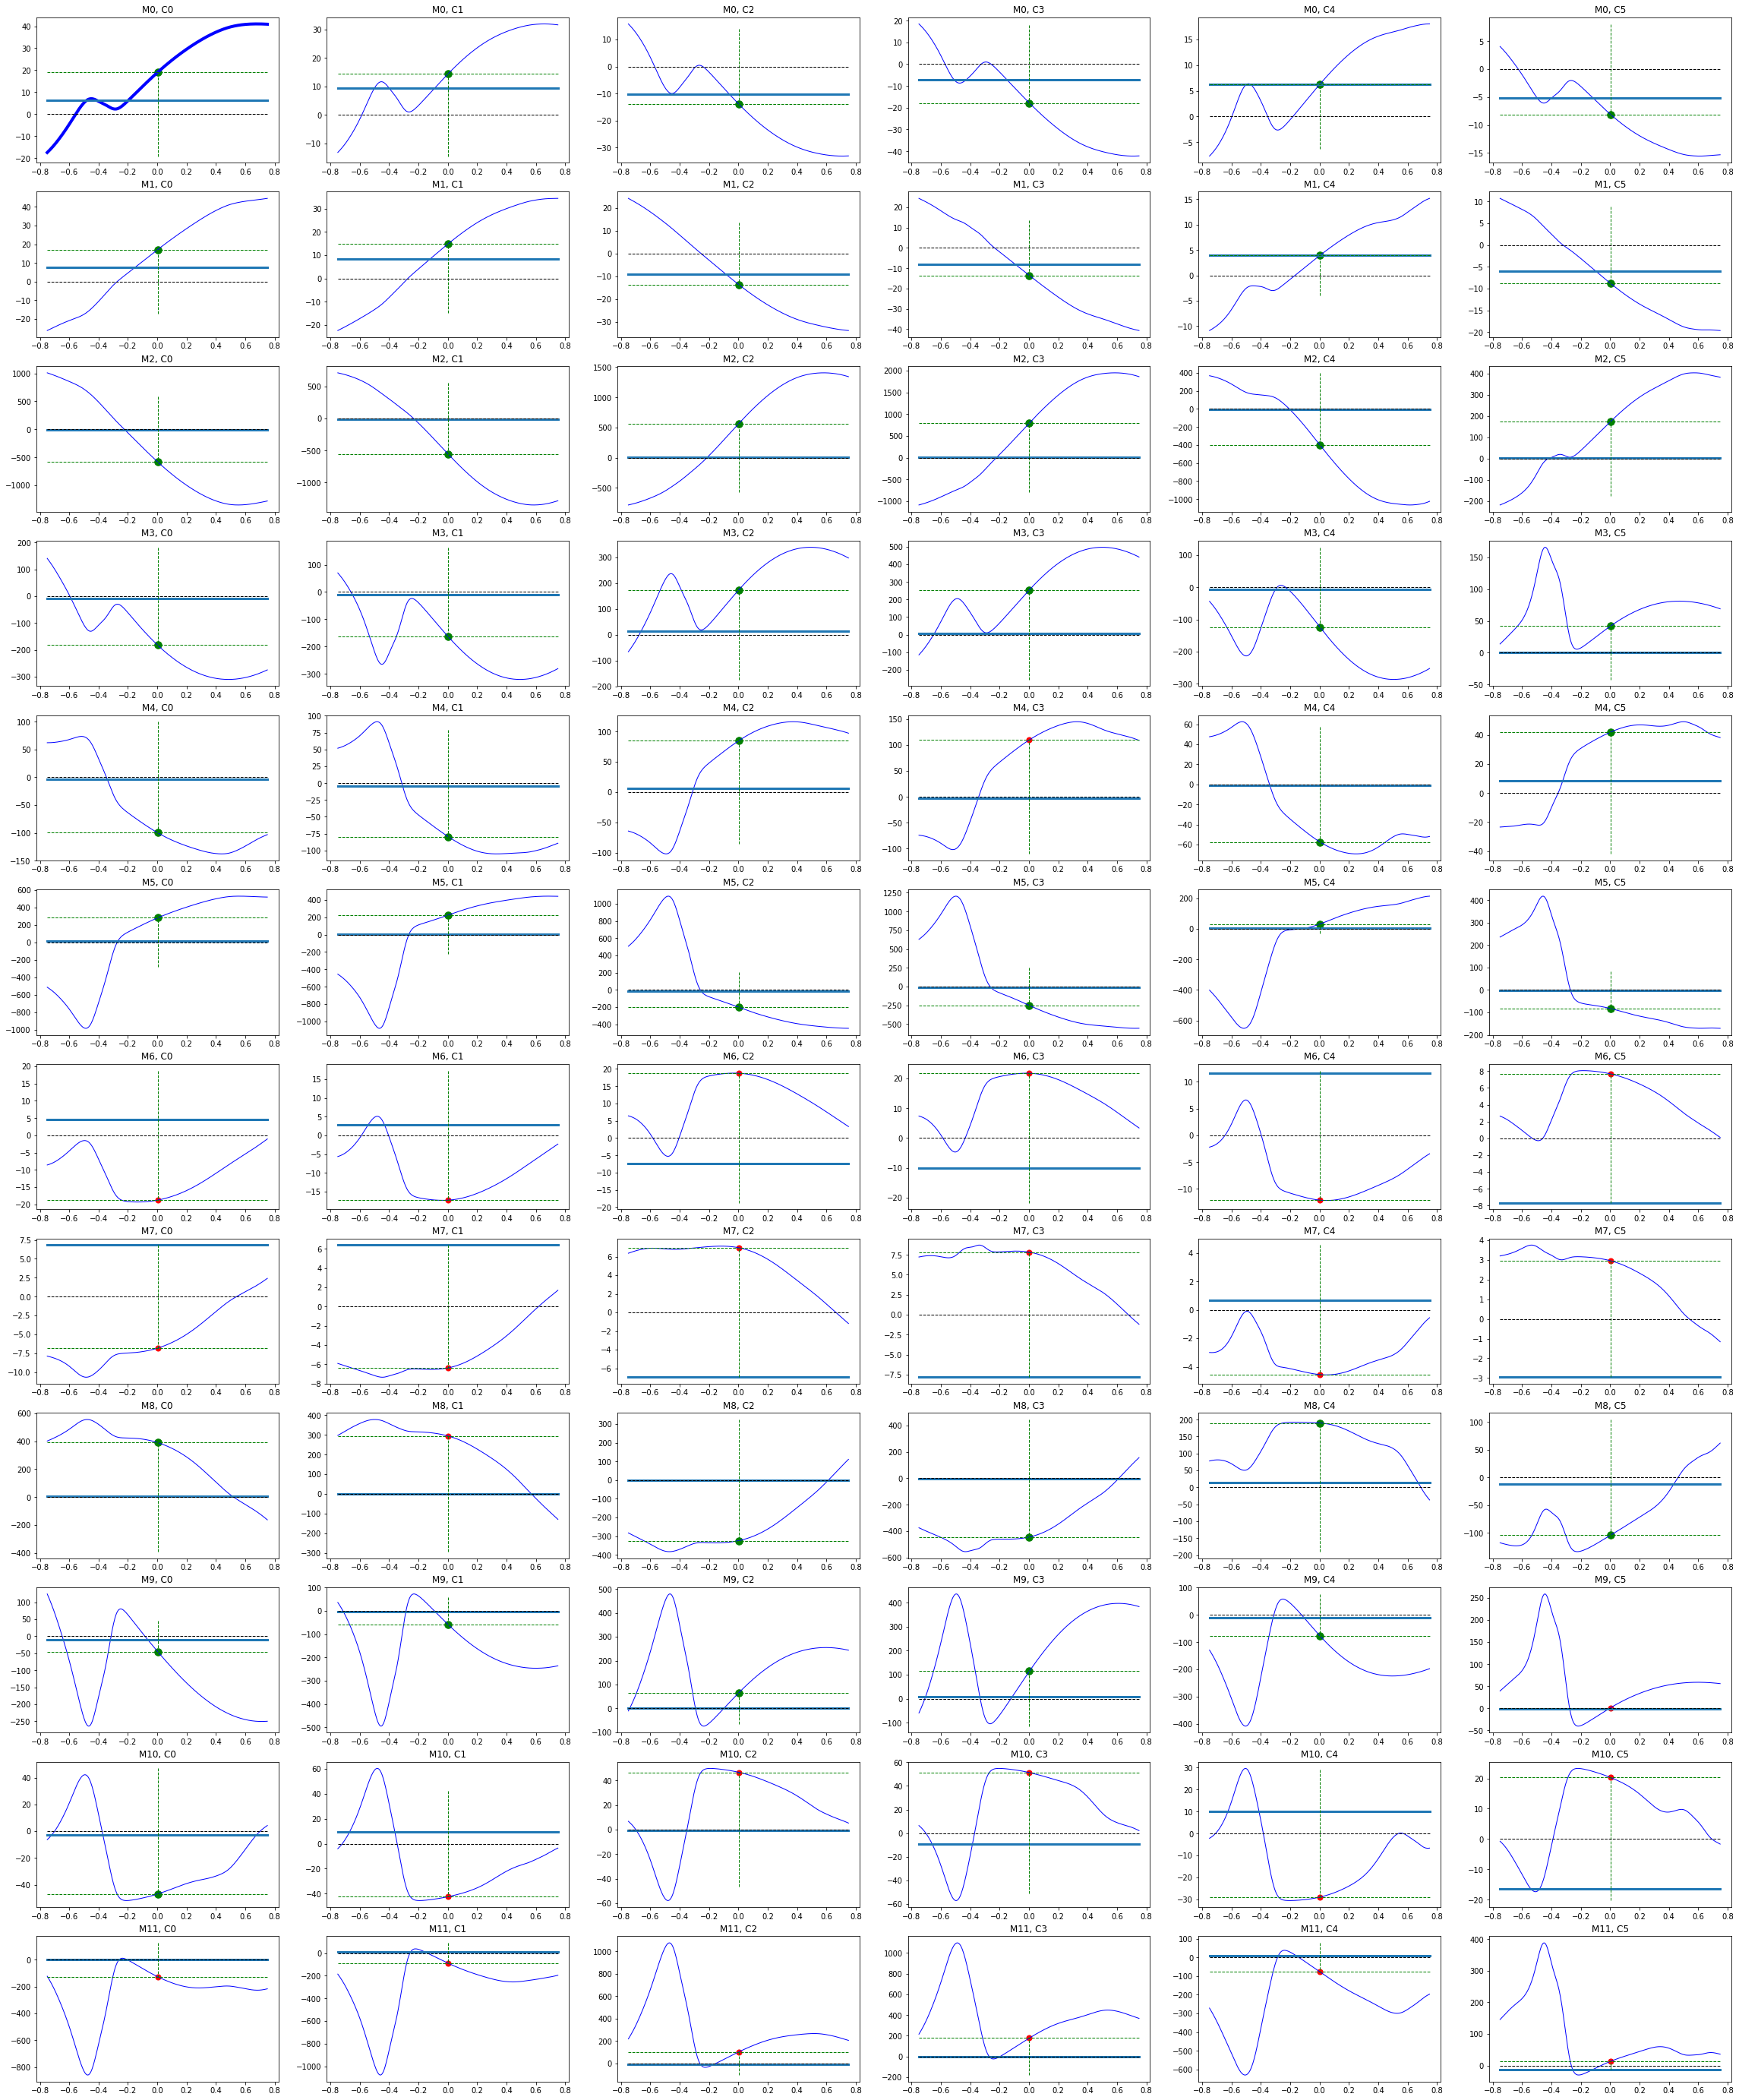

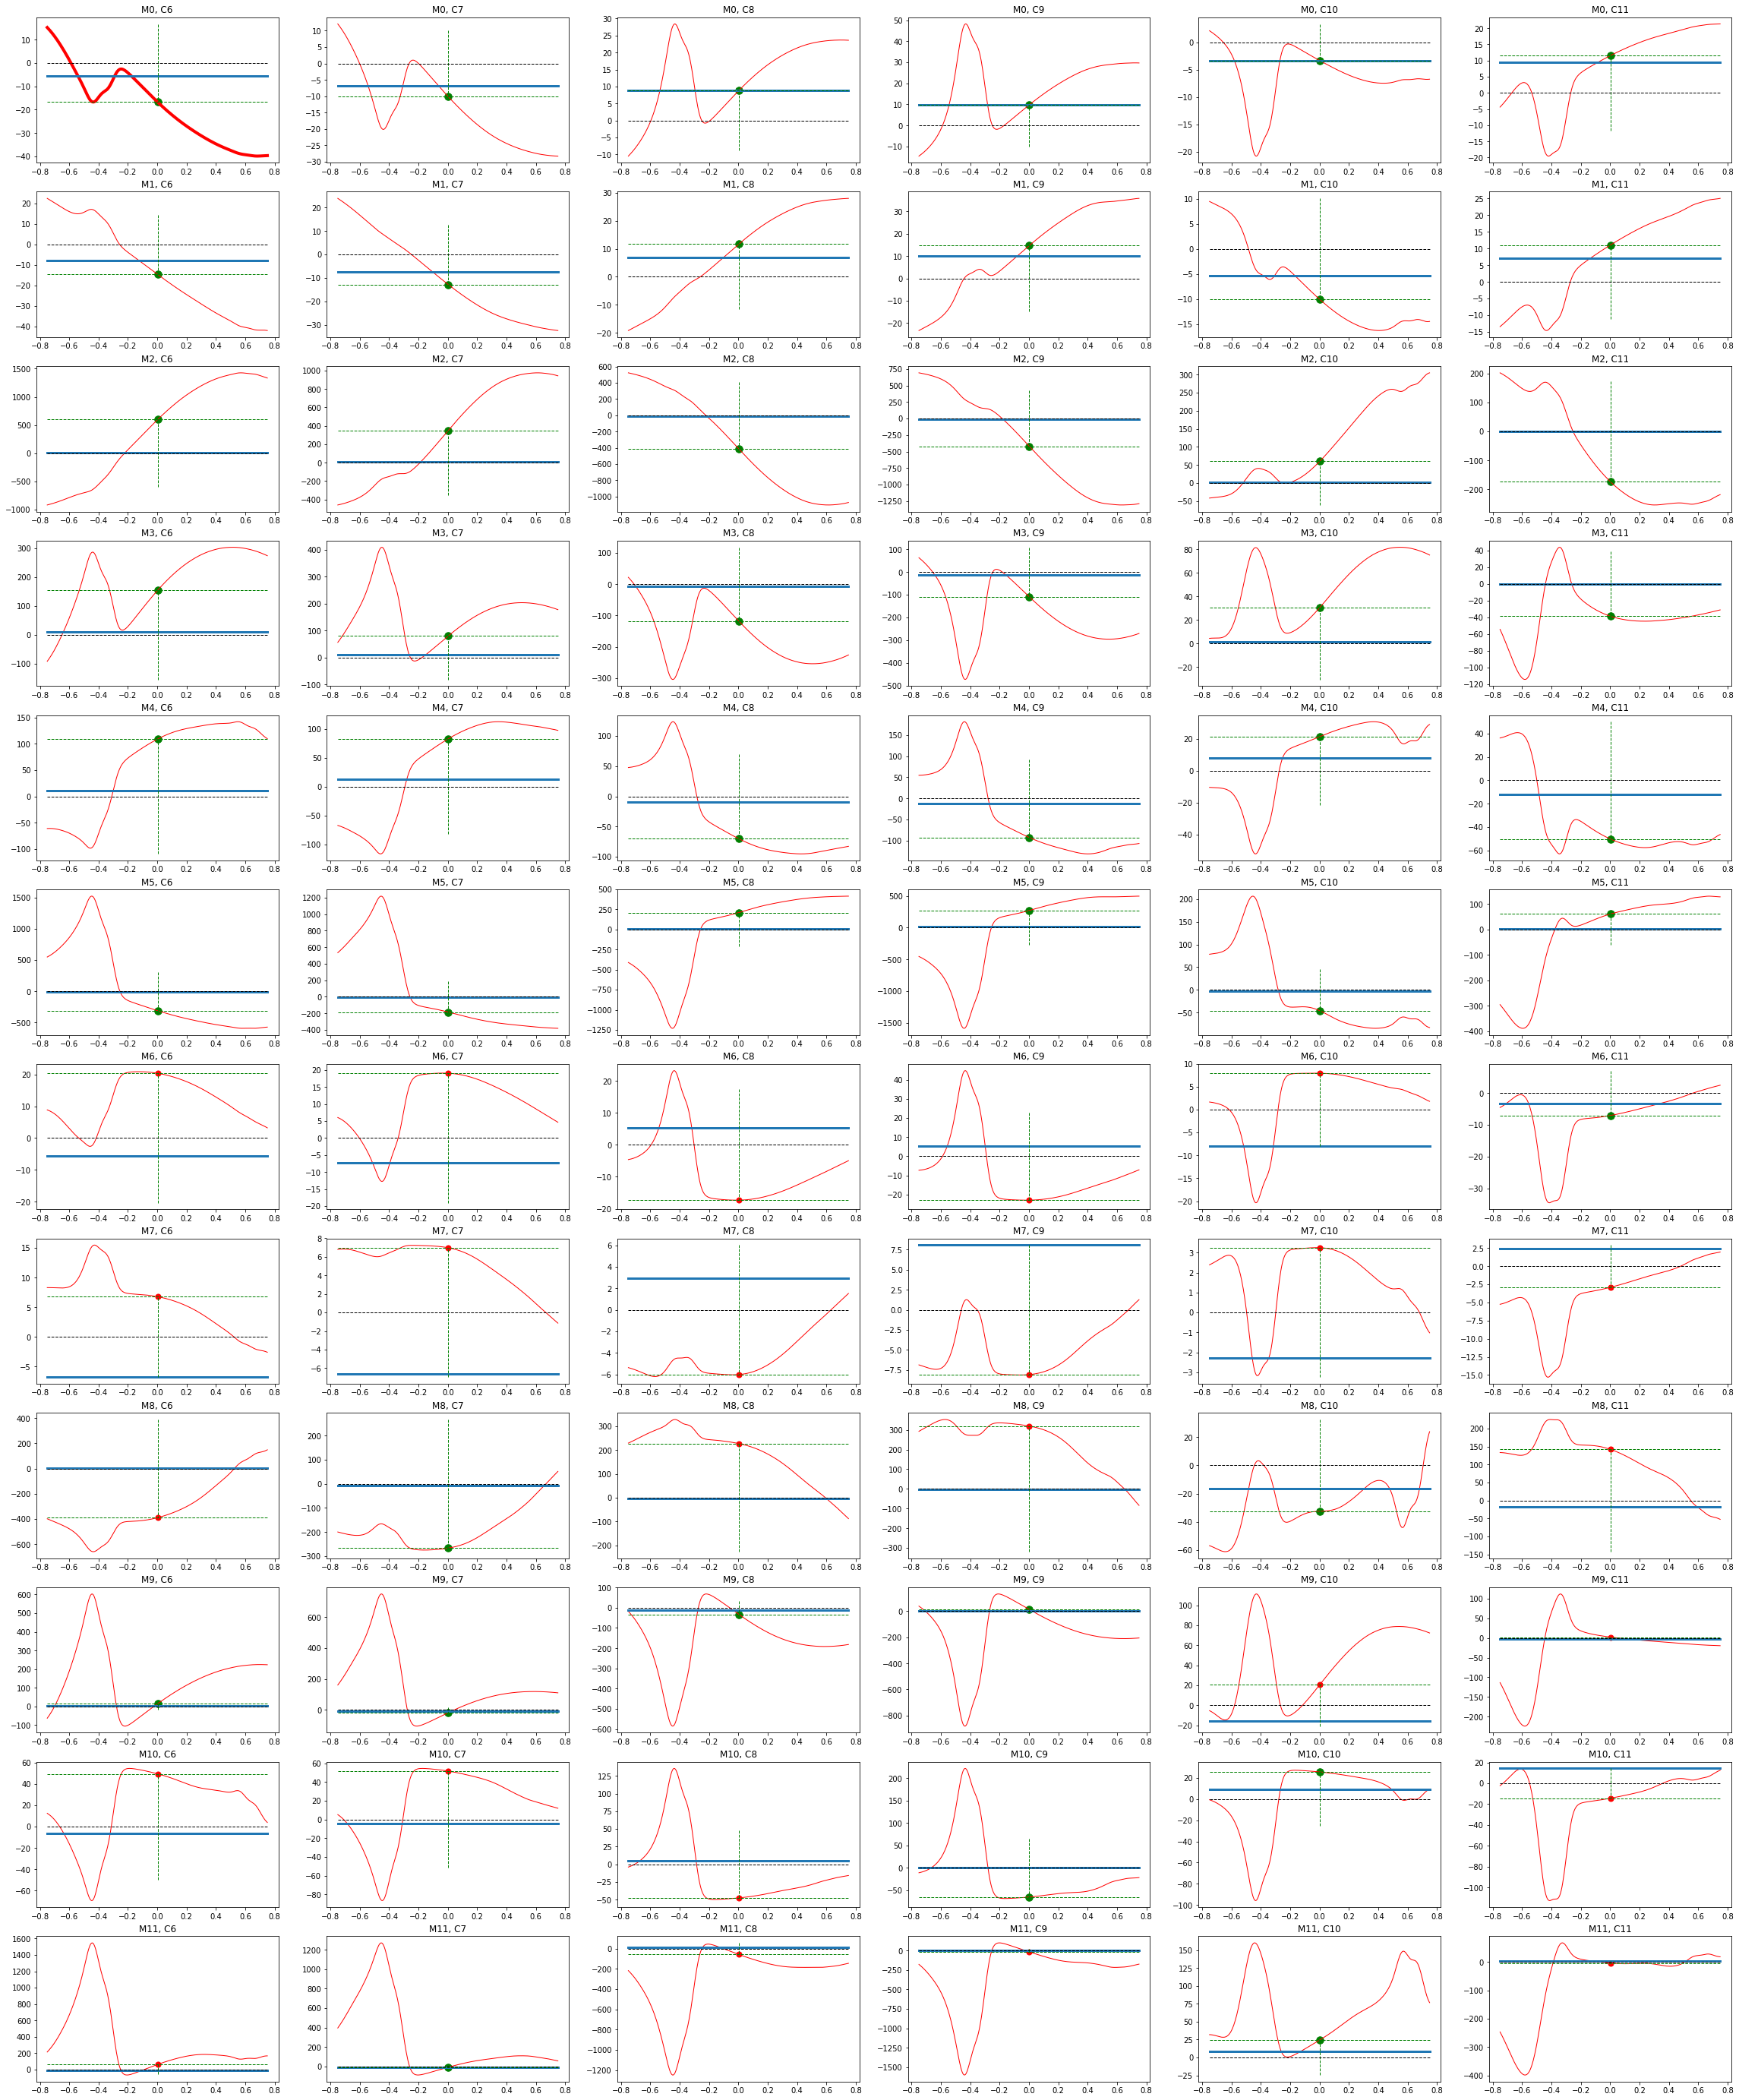

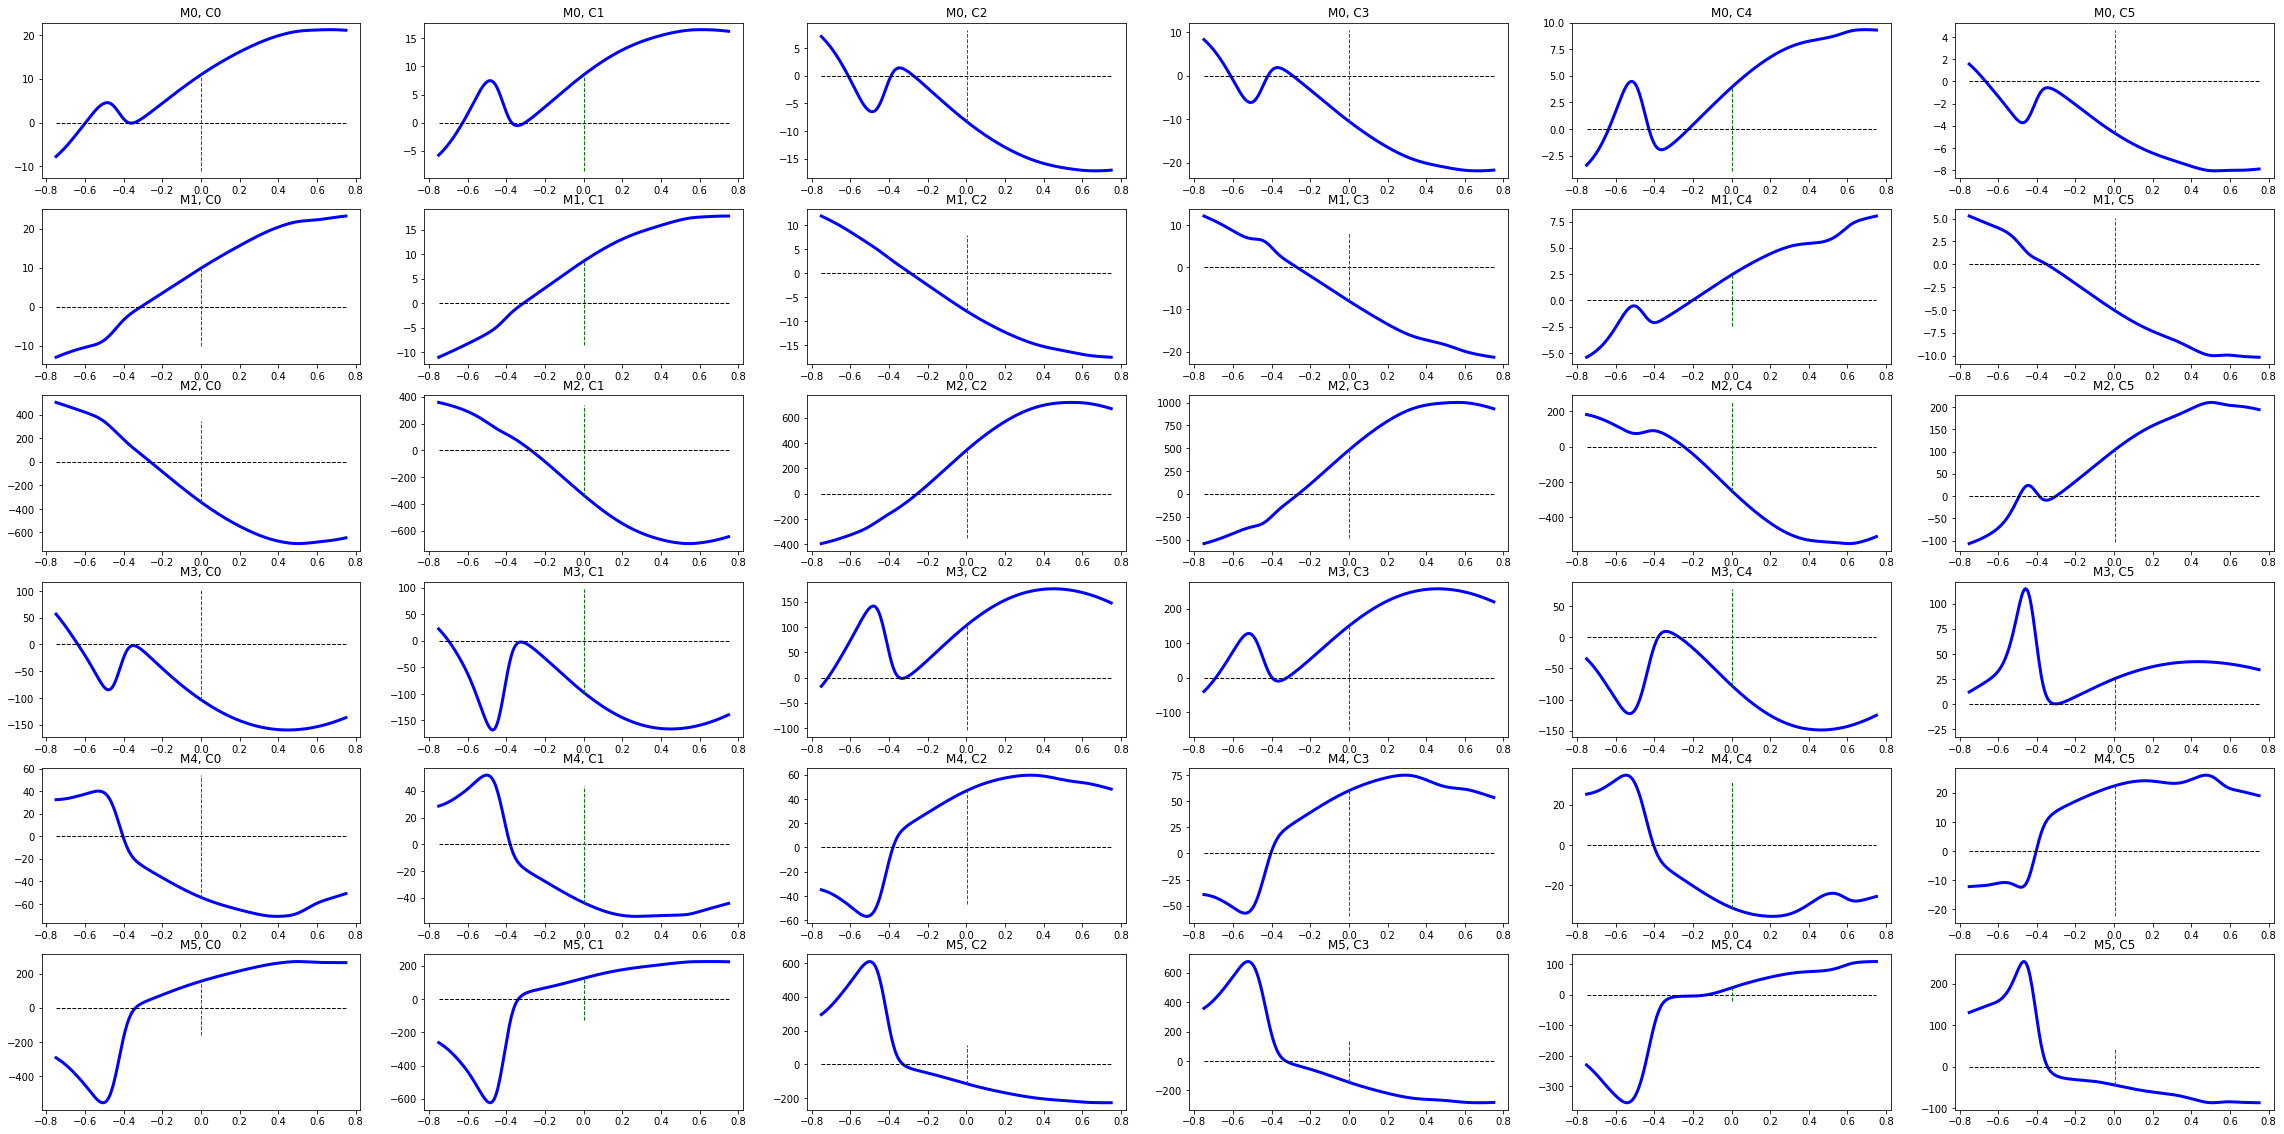

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]]
[9. 7. 8. 7. 8. 7. 7. 9. 7. 8. 9. 7.]
[12. 12. 12. 12. 11. 12.  1.  0.  7.  9.  3.  2.]
0.6458333333333334
normalized M__CE correlation weight matrix:
[[ 0.02395266, 0.02056402, -0.01923938, -0.01763241, 0.01317124, -0.03528357]
, [ 0.02154326, 0.02116807, -0.01885998, -0.01341156, 0.00823251, -0.03828877]
, [-0.73050303, -0.79180674, 0.78361545, 0.78827687, -0.83615449, 0.76178676]
, [-0.22916446, -0.23314295, 0.24039117, 0.2518428, -0.25935524, 0.18308039]
, [-0.12551552, -0.11300211, 0.11747291, 0.10872888, -0.1200368, 0.1

In [16]:
# ANALYSIS OF CORRELATIONS BETWEEN MOTOR UNITS AND C UNITS
# Modified for the rga_diff rule

# obtaining M,C unit activities and their derivatives
full_size = len(data[M[0]])
D_size = 100000 # number of points we will take from the data signals
corr_size = 1000 # number of points in the correlation vector
MD = data[M, -D_size:].transpose() # take the data from the latest points
w_l = 31 # window length for smoothing
for idx in range(len(M)): # smoothing MD
    MD[:,idx] = smooth(MD[:,idx], window_len=w_l)[int(np.floor(w_l/2)):-int(np.floor(w_l/2))]
MD_diff = np.gradient(MD, axis=0) / net.min_delay
MD_diff_roll = np.roll(MD_diff, -CE_params['custom_inp_del']+CE_params['custom_inp_del2'], axis=0) # advancing MD_diff
# Obtaining means over 2 seconds
mean_win = int(2./net_params['min_delay']) # number of points in the window to extract the means
MD_diff_means = np.zeros_like(MD_diff)
MD_diff_roll_means = np.zeros_like(MD_diff_roll)
for idx in range(mean_win,len(MD_diff[:,0])-1):
        MD_diff_means[idx,:] = np.sum(MD_diff_roll[idx-mean_win:idx,:], axis=0)/mean_win
        MD_diff_roll_means[idx,:] = np.sum(MD_diff_roll[idx-mean_win:idx,:], axis=0)/mean_win
MD_diff_center = MD_diff_means - MD_diff # The NEGATIVE of the centered derivative
MD_diff_roll_center = MD_diff_roll - MD_diff_roll_means
MD_diff_center_red = MD_diff_center[:-corr_size,:]
MD_diff_roll_center_red = MD_diff_roll_center[:-corr_size,:] # when it's second in np.correlate

CD = data[CE+CI, -D_size:].transpose()
CD_diff = np.gradient(CD, axis=0) / net.min_delay
CD_diff_roll = np.roll(CD_diff, CE_params['custom_inp_del2'], axis=0)
CD_diff_roll_means = np.zeros_like(CD_diff_roll)
for idx in range(6):
    CD_diff_roll_means[:, idx] = np.mean(np.delete(CD_diff_roll[:,0:6], idx, axis=1), axis=1)
for idx in range(6,12):
    CD_diff_roll_means[:, idx] = np.mean(np.delete(CD_diff_roll[:,6:12], idx-6, axis=1), axis=1)
CD_diff_roll_center = CD_diff_roll - CD_diff_roll_means
#CD_diff_roll_center_red = CD_diff_roll_center[:-corr_size,:]
hlf_cspan = int(round(corr_size/2.))
CD_diff_roll_center_red = CD_diff_roll_center[hlf_cspan:-hlf_cspan,:]

# plots for the signals used in this the analysis
plt_len=4000  # number of points to plot
fig, axs = plt.subplots(3, 1, figsize=(30, 28))
axs[0].plot(MD[0:plt_len,0])
axs[0].set_title('motor unit activities')

axs[1].plot(MD_diff_center[0:plt_len,0])
axs[1].plot(MD_diff_roll_center[0:plt_len,0])
axs[1].plot(np.zeros(plt_len), 'k')
axs[1].set_title('centered derivatives for motor unit activities')
#axs[1].plot(np.zeros(MD_diff_center.shape[0]), 'k')
axs[1].set_ylim([-.1, .1])

axs[2].plot(CD_diff_roll_center[0:plt_len,0])
axs[2].plot(np.zeros(plt_len), 'k')
#axs[2].set_ylim([-2., 2.])
axs[2].set_title('centered derivatives for C units')
#axs[2].plot(np.zeros(CD_diff_center.shape[0]), 'k')

# plotting the expected weights for pairs of M and CE/CI signals
M__CE_w = [[syn.w for syn in net.syns[c] if syn.preID in M] for c in CE]
corr_figE, corr_axsE = plt.subplots(12, 6, figsize=(40,50))

M__CI_w = [[syn.w for syn in net.syns[c] if syn.preID in M] for c in CI]
corr_figI, corr_axsI = plt.subplots(12, 6, figsize=(40,50))

# plotting the differential correlations for pairs of M and CE/CI signals
corr_figX, corr_axsX = plt.subplots(6, 6, figsize=(40,20))

base_idx = 0 # index for positive Ia afferent for muscle 0
plt_span = min(300, corr_size)   # span to plot for the correlation
#t = np.linspace(-plt_span*net.min_delay, plt_span*net.min_delay, 2*plt_span)
                
hlf_pspn = int(round(plt_span/2.))
t = np.linspace(-hlf_pspn*net.min_delay, hlf_pspn*net.min_delay, plt_span)
#pos_t = np.linspace(0., plt_span*net.min_delay, plt_span)
#neg_t = np.linspace(-(plt_span+1)*net.min_delay, -net.min_delay, plt_span)
#all_t = np.concatenate((neg_t,pos_t))
eqs = np.zeros((12,12)) # matrix indicating whether weight and correlation have same sign
corr_w = np.zeros((12,12)) # what the weight should be, according to the correlation
des_val_idx = hlf_cspan # index in the correlation vector where the weight should be...
                        # depends on CD_diff_diff_roll_center_red was reduced

for col in range(12):  # ranges through C units
    if col < 6:
        axes = corr_axsE
        weights = M__CE_w
        color='b'
    else:
        axes = corr_axsI
        weights = M__CI_w
        color='r'
    mcol = col%6
    for row in range(12):  # ranges through M units
        cur_idx = 12*mcol+row
        if cur_idx == base_idx: lw = 4
        else: lw = 1
        # This corresponds to what should be learned with two different single delays
        # In 'corr' MD is not delayed, and CD is delayed by dely2 (CE_params[custom_inp_del2])
        corr = np.correlate(MD_diff_center[:,row], CD_diff_roll_center_red[:,col], mode='valid')
        #corr = np.correlate(CD_diff_roll_center[:,col], MD_diff_center[:,row], mode='valid')
        # In corr MD is additionally delayed by dely2-dely1
        corr2 = np.correlate(MD_diff_roll_center[:,row], CD_diff_roll_center_red[:,col], mode='valid')
        # this corresponds to what should be learned using the "diff" learning rule
        corr_diff = corr - corr2
        
        # plot value of rga_diff learning rule
        axes[row,mcol].plot(t, corr_diff[hlf_cspan-hlf_pspn:hlf_cspan+hlf_pspn], linewidth=lw, color=color)
        
        corr_w[row,col] = corr_diff[des_val_idx]
        acw = abs(corr_w[row,col])
        t_des = t[hlf_pspn]
        axes[row,mcol].plot(t, max(min(10.*weights[mcol][row],acw),-acw)*np.ones(len(t)), linewidth=3)
        axes[row,mcol].plot(t, corr_diff[des_val_idx]*np.ones(len(t)), 'g--', linewidth=1)
        axes[row,mcol].plot([t_des, t_des], [-corr_w[row,col], corr_w[row,col]], 'g--', linewidth=1)
        axes[row,mcol].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
        axes[row,mcol].set_title('M' + str(row) + ', C' + str(col))
        
        if col<6 and row<6:  # plot differential correlation
            # Legacy code:
            #---------------------------------------
            # These are further values of corr when CD rather than MD is further delayed
            # Because the first array is shorter, the arguments will be reversed (see np.convolve documentation);
            # however, the sign of the indexes is not inverted. This means:
            # correlate(MD_diff_center_red,CD_diff_roll_center) == correlate(CD_diff_roll_center,MD_diff_center_red)[::-1]
            #rev_corr = np.correlate(MD_diff_center_red[:,row], CD_diff_roll_center[:,col], mode='valid')
            #corr_axsX[row,col].plot(all_t, np.concatenate((rev_corr[-plt_span:],corr[0:plt_span])), linewidth=3, color='b')
            #---------------------------------------
            corr_axsX[row,col].plot(t, corr[hlf_cspan-hlf_pspn:hlf_cspan+hlf_pspn], linewidth=3, color='b')
            corr_axsX[row,mcol].set_title('M' + str(row) + ', C' + str(col))
            corr_axsX[row,mcol].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
            c0 = abs(corr[des_val_idx])
            corr_axsX[row,mcol].plot([t_des, t_des], [-c0, c0], 'g--', linewidth=1)
        
        # Finding if weights are following the correlations
        scat_s = 50
        scat_c = 'r'
        if np.sign(weights[mcol][row]) == np.sign(corr_diff[des_val_idx]):
            eqs[row,col] = 1.
            scat_s = 90
            scat_c = 'g'
        axes[row,mcol].scatter([t_des], [corr_diff[des_val_idx]], s=scat_s, c=scat_c)
plt.show()

# Regarding whether correlations and weights have the same sign
print(eqs)
print(np.sum(eqs, axis=0))
print(np.sum(eqs, axis=1))
print(sum(eqs.flatten())/(eqs.shape[0]*eqs.shape[1]))
# Regarding desired weights according to correlations
# normalizing columns of corr_w (weights on the same C unit)
n_corr_w = corr_w / np.linalg.norm(corr_w, axis=0)
import re
print('normalized M__CE correlation weight matrix:')
print(re.sub('\[,', '[', re.sub('\ +', ', ', str(n_corr_w[:,:6]))))
print('normalized M__CI correlation weight matrix:')
print(re.sub('\[,', '[', re.sub('\ +', ', ', str(n_corr_w[:,6:]))))

In [26]:
# Doing a nice print of the AF__M weights in order to initialize them
AF__M_w = np.zeros((len(M), len(AF)))
for idx, mid in enumerate(M):
    AF__M_w[idx, :] = np.array([syn.w for syn in net.syns[mid] if syn.preID in AF])
      
import re

stryn = re.sub('\[,', '[', re.sub('\ +', ', ', str(AF__M_w)))
for c,s in enumerate(re.split(', ', stryn)):
    print(s, end=',')
    if (c+1)%36 == 0: print('\n')


[[-0.38003886,-0.57174474,-0.08659624,-0.02726097,-0.63338338,-0.04852808
,0.09221457,0.76606063,-1.0374006,-0.24493658,-0.04622818,0.24847488
,0.02803389,0.08431823,-0.53636385,-0.24993294,0.02708251,-0.22975957
,0.08834969,0.14393123,-0.20350992,-0.11678463,0.13060028,-0.24746656
,-0.27669855,-1.12420401,0.69235702,0.08372352,0.27103383,-0.04525955
,-0.28254806,-0.58457865,0.07606342,0.02527667,-0.24909991,0.02593182]
,

[-0.33744405,-0.49671829,0.25678114,0.18855946,-0.45921406,0.20820334
,0.1037536,0.81465235,-0.91152925,-0.20448079,-0.05985943,0.27130631
,0.05176407,0.13710837,-0.42265425,-0.19406124,0.0312944,-0.18301693
,0.1146151,0.18745973,-0.26992389,-0.1557249,0.14018696,-0.2994495
,-0.23138618,-0.98513953,0.74807737,0.09684271,0.29646397,-0.05792568
,-0.21968559,-0.46098757,0.12885044,0.04706862,-0.19887454,0.02989741]
,

[ 0.27031897,0.40933509,-0.31170966,-0.22475953,0.45240421,-0.28297782
,-0.09356727,-0.72908131,0.99266486,0.22215776,0.05238461,-0.25188886
,-0.04329803,

In [15]:
# checking some connections
print("Connections to motor units")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[AF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to spinal units")
for idx, syn in enumerate(net.syns[CE[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CE, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")

for idx, syn in enumerate(net.syns[CI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CI, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")


print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in AL:
        pre_pop = 'AL'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
print("-------------------------\n")

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

Connections to motor units
0) AF (1) --> M, w=-0.402106, port=0, plant_out=None
1) AF (2) --> M, w=-0.433186, port=0, plant_out=None
2) AF (3) --> M, w=0.252913, port=0, plant_out=None
3) AF (4) --> M, w=-0.029962, port=0, plant_out=None
4) AF (5) --> M, w=-0.950902, port=0, plant_out=None
5) AF (6) --> M, w=0.140115, port=0, plant_out=None
6) AF (7) --> M, w=0.158429, port=0, plant_out=None
7) AF (8) --> M, w=0.676935, port=0, plant_out=None
8) AF (9) --> M, w=-0.542973, port=0, plant_out=None
9) AF (10) --> M, w=-0.237889, port=0, plant_out=None
10) AF (11) --> M, w=-0.257517, port=0, plant_out=None
11) AF (12) --> M, w=0.074272, port=0, plant_out=None
12) AF (13) --> M, w=0.201785, port=0, plant_out=None
13) AF (14) --> M, w=0.408733, port=0, plant_out=None
14) AF (15) --> M, w=-0.588238, port=0, plant_out=None
15) AF (16) --> M, w=-0.370811, port=0, plant_out=None
16) AF (17) --> M, w=0.036592, port=0, plant_out=None
17) AF (18) --> M, w=-0.167821, port=0, plant_out=None
18) AF (19

---

In [12]:
#Animation of the arm and muscles
%matplotlib widget
from numpy import cos, sin
from matplotlib.animation import FuncAnimation

# angles of shoulder and elbow
theta_s = arm_activs[:,0]
theta_e = arm_activs[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
acts = np.array(data[1])
ipx = data[ipx_track]
ipy = data[ipy_track]
ten = arm_activs[:, np.array(range(4,10))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2
# creating the figure and axis
fig = plt.figure(figsize=(8,8))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.grid()
# creating lines and points
line, = ax.plot([], [], 'o-b', lw=2)
points, = ax.plot([], [], '+k')
target, = ax.plot([], [], 'gD')
# preparing a colormap for the tensions
ten_max = max(ten.max(), 1e-5)
ten_min = min(ten.min(), -1e-5)
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
#ten = (ten / 2.) + 0.5 # we'll have only positive tensions
mus_lines = []
#cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
# stuff used to plot the target
strt_idx = int(np.round(times[0]/t_pres)) # initial index in m_idxs

def init():
    line.set_data([], [])
    points.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    ip_x = ipx[:,frame]
    ip_y = ipy[:,frame]
    tens = ten[:, frame]
    line.set_data(coord_x, coord_y)
    points.set_data(ip_x, ip_y)
    for i, ml in enumerate(mus_lines):
        idx = 2*i
        ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
        ml.set_color(cmap(tens[i]))
    
    cur_time = frame*net.min_delay
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    # plotting target
    cur_idx = int(cur_time/t_pres) + strt_idx
    x_coord, y_coord = hand_coords[m_idxs[cur_idx]]
    target.set_data([x_coord], [y_coord])
    
    return line, points, mus_lines #muscle1

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s), 20), init_func=init, blit=True, interval=20)

plt.show()

FigureCanvasNbAgg()

In [10]:
# Cell used to adjust parameters affecting the range of SF values
# corresponding to the various targets when using AFi__SF connections

# In the first cell we calculated the AF output for the 8 targets.
# It is in the AF(e/i)_Ia_II arrays, which are 8x12
# We get the input to SF from AFe_Ia_II and AFi_Ia_II
#AF_Ia_II = AFe__SF_syn['init_w'*AFe_Ia_II + Pi__AF_ws*AFi_Ia_II
# We reduce AF_Ia_II in three ways: maximum, minimum, and mean for all targets
AFe_max = np.max(AFe_Ia_II, axis=0)
AFe_min = np.min(AFe_Ia_II, axis=0)
AFe_mean = np.mean(AFe_Ia_II, axis=0)
AFe_std = np.std(AFe_Ia_II, axis=0)
AFe_spread = AFe_max - AFe_min

AFi_max = np.max(AFi_Ia_II, axis=0)
AFi_min = np.min(AFi_Ia_II, axis=0)
AFi_mean = np.mean(AFi_Ia_II, axis=0)
AFi_std = np.std(AFi_Ia_II, axis=0)
AFi_spread = AFi_max - AFi_min

print("AFe_max")
print(AFe_max)
print("AFe_min")
print(AFe_min)
print("AFe_mean")
print(AFe_mean)
print("AFe_spread")
print(AFe_spread, end="\n\n")

print("AFi_max")
print(AFi_max)
print("AFi_min")
print(AFi_min)
print("AFi_mean")
print(AFi_mean)
print("AFi_spread")
print(AFi_spread, end="\n\n")


# We adjust the SF parameters so the minimum output is around 0.2, and the maximum is
# around 0.9 . This can be roughly achieved if:
# 1) AF__SF weights are inversely proportional to the max
# 2) SF thresholds are set to zero
# 3) The SF slope is such that SF_out(1) = 0.9, or SF_out(-1) = 0.1
#    Doing the algebra, this leads to: slope = log(9)
print("--------------------------------------------------------------")
print("Recommended AFe__SF weights: ", end="\n")
print(1./AFe_max, end="\n\n")
print("Recommended AFi__SF weights: ", end="\n")
print(-1./AFi_max, end="\n\n")
print("Recommended SF thresholds: ")
print(0., end="\n\n")
print("Recommended SF slopes: ")
print(np.log(9.), end="\n\n")

# A different approach is to have the mean afferent value produce an SF output around 0.5,
# and values one standard deviation away produce values of 0.8 or 0.2, respectively.
# This can be achieved by using the summed AFe+AFi signal to produce AF_sum, and: 
# 1) AFe__SF weights are set as w=1/AFsum_std, AFi__SF as w=-1/AFsum_std. 
# 2) Thresholds are set to the mean of AFsum
# 3) Slopes are set so SF_out(1) = 0.8. This works out to:
#    slope = (log(0.8)-log(0.2))/(1 - (mean/std)) = log(4)/(1 - thr)
# This assumes (wrongly) that the std of the combined signal is like the std of the
# individual signals, but let's test it.

AFsum = AFe_Ia_II/AFe_std - AFi_Ia_II/AFi_std
AFsum_mean = np.mean(AFsum, axis=0)
AFsum_std = np.std(AFsum, axis=0)

print("--------------------------------------------------------------")
print("Recommended AFe__SF weights: ", end="\n")
AFe_w = 1./AFsum_std
for w in AFe_w:
    print("{:1.2f}".format(w) + ',', end=' ')
print('\b\b]', end="\n\n")
print("Recommended AFi__SF weights: ", end="\n")
AFi_w = -1./AFsum_std
for w in AFi_w:
    print("{:1.2f}".format(w) + ',', end=' ')
print('\b\b]', end="\n\n")
print("Recommended SF thresholds: ")
thr = AFsum_mean/AFsum_std
for t in thr:
    print("{:1.2f}".format(t) + ',', end=' ')
print('\b\b]', end="\n\n")
print("Recommended SF slopes: ")
slopes = np.log(4.) / (1. - thr)
for s in slopes:
    print("{:1.2f}".format(s) + ',', end=' ')
print('\b\b]', end="\n\n")

AFe_max
[0.06813572 0.10937034 0.09642589 0.0628782  0.1404347  0.13641422
 0.13627144 0.17499254 0.15428143 0.1257564  0.22469552 0.21826275]
AFe_min
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
AFe_mean
[0.01217423 0.02756165 0.0257999  0.01166532 0.03706655 0.03555472
 0.02434846 0.04409864 0.04127984 0.02333065 0.05930648 0.05688756]
AFe_spread
[0.06813572 0.10937034 0.09642589 0.0628782  0.1404347  0.13641422
 0.13627144 0.17499254 0.15428143 0.1257564  0.22469552 0.21826275]

AFi_max
[0.06114656 0.10666394 0.10754845 0.05938368 0.12308305 0.12046989
 0.12229313 0.1706623  0.17207752 0.11876735 0.19693288 0.19275182]
AFi_min
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
AFi_mean
[0.01217423 0.02756165 0.0257999  0.01166532 0.03706655 0.03555472
 0.02434846 0.04409864 0.04127984 0.02333065 0.05930648 0.05688756]
AFi_spread
[0.06114656 0.10666394 0.10754845 0.05938368 0.12308305 0.12046989
 0.12229313 0.1706623  0.17207752 0.11876735 0.19693288 0.19275182]

----------------------------------------

In [16]:
print(net.units[SF[2]].get_act(100.))
print(net.units[SF[2]].f(AFsum_mean[2]))
print(net.units[SF[2]].thresh)
print(AFsum_std[2])
AFsum_mean[2]*AFe_w[2]

0.24700418569811697
0.2690459606386093
0.45
1.7913966081513812


0.028919019574418264

In [17]:
print(AFe_mean[2])
print(AFe_std[2])
AFsum_mean[2]

0.0666774420907807
0.054190978330383444


0.7798566699301002

In [8]:
Ia_II_avgsA = np.array([net.units[u].lpf_slow_sc_inp_sum for u in AF[6:18]])
print(Ia_II_avgsA)
Ia_II_avgsB = np.array([0.09, 0.09, 0.13, 0.11, 0.09, 0.12, 0.25, 0.21, 0.26, 0.29, 0.20, 0.26])
print(Ia_II_avgsB)
Ia_II_avgsC = np.mean(Ia_II_ss, axis=0)
print(Ia_II_avgsC)
print(np.dot(Ia_II_avgsA,Ia_II_avgsB)/(np.linalg.norm(Ia_II_avgsA)*np.linalg.norm(Ia_II_avgsB)))
print(np.dot(Ia_II_avgsA,Ia_II_avgsC)/(np.linalg.norm(Ia_II_avgsA)*np.linalg.norm(Ia_II_avgsC)))
print(np.dot(Ia_II_avgsC,Ia_II_avgsB)/(np.linalg.norm(Ia_II_avgsB)*np.linalg.norm(Ia_II_avgsC)))

[ 0.03572641 -0.11275161  0.3236406   0.15607441  0.09024566  0.12856274
  0.14913816 -0.1160542   0.57687243  0.38147186  0.19651629  0.2629931 ]
[0.09 0.09 0.13 0.11 0.09 0.12 0.25 0.21 0.26 0.29 0.2  0.26]
[0.08715754 0.02936164 0.19141712 0.11720725 0.12518394 0.09618831
 0.24185258 0.10962046 0.3631884  0.30195198 0.25462661 0.21420055]
0.7811641244411759
0.8990873548412431
0.9633522090190368


In [10]:
Recommended AFe__SF weights: 
0.57, 0.57, 0.57, 0.57, 0.55, 0.55, 0.57, 0.57, 0.57, 0.57, 0.55, 0.55]

Recommended AFi__SF weights: 
-0.57, -0.57, -0.57, -0.57, -0.55, -0.55, -0.57, -0.57, -0.57, -0.57, -0.55, -0.55]

Recommended SF thresholds: 
-0.08, -0.39, 0.45, 0.12, 0.09, -0.09, -0.10, -0.41, 0.48, 0.10, 0.08, -0.11]

Recommended SF slopes: 
1.28, 1.00, 2.51, 1.58, 1.52, 1.27, 1.26, 0.98, 2.65, 1.54, 1.51, 1.25]





# extracting afferent means
Ia_means = np.zeros(6)
II_means = np.zeros(6)
Ib_means = np.zeros(6)
for m in range(6):
    Ia_means[m] = np.mean(arm_activs[:,28+m])
    II_means[m] = np.mean(arm_activs[:,34+m])
    Ib_means[m] = np.mean(arm_activs[:,22+m])
print(Ia_means)
print(II_means)
print(Ib_means)

[ 0.02917022 -0.10707194  0.31677038  0.16684086  0.04881124  0.16651311]
[ 0.12624358 -0.10620177  0.56145306  0.40102076  0.13122682  0.32795123]
[0.11930733 0.28711425 0.27609925 0.12103699 0.25637622 0.22016711]


shoulder angle: 1.072829, shoulder vel: 1.985227
AFe_data:
[1.91381091e-61 4.16203686e-56 8.55434659e-64 1.88155553e-67
 1.40761068e-63 2.23631052e-65 1.03682529e-69 5.23871446e-04
 2.81482607e-13 1.79996245e-03 3.04779572e-65 6.39793856e-03
 1.68270901e-68 5.07606125e-74 5.82519475e-10 3.44709827e-03
 7.69403082e-62 1.00027511e-02]
AFi_data:
[1.30503042e-02 2.99751052e-02 3.82573191e-03 1.10813549e-02
 1.74730642e-02 1.83664617e-02 9.51762397e-04 2.65098877e-08
 1.80285877e-03 4.64538547e-69 6.68208786e-03 1.68891560e-64
 3.13576613e-03 2.35376956e-04 2.16275062e-03 3.67995168e-67
 9.93329207e-03 3.60740001e-61]


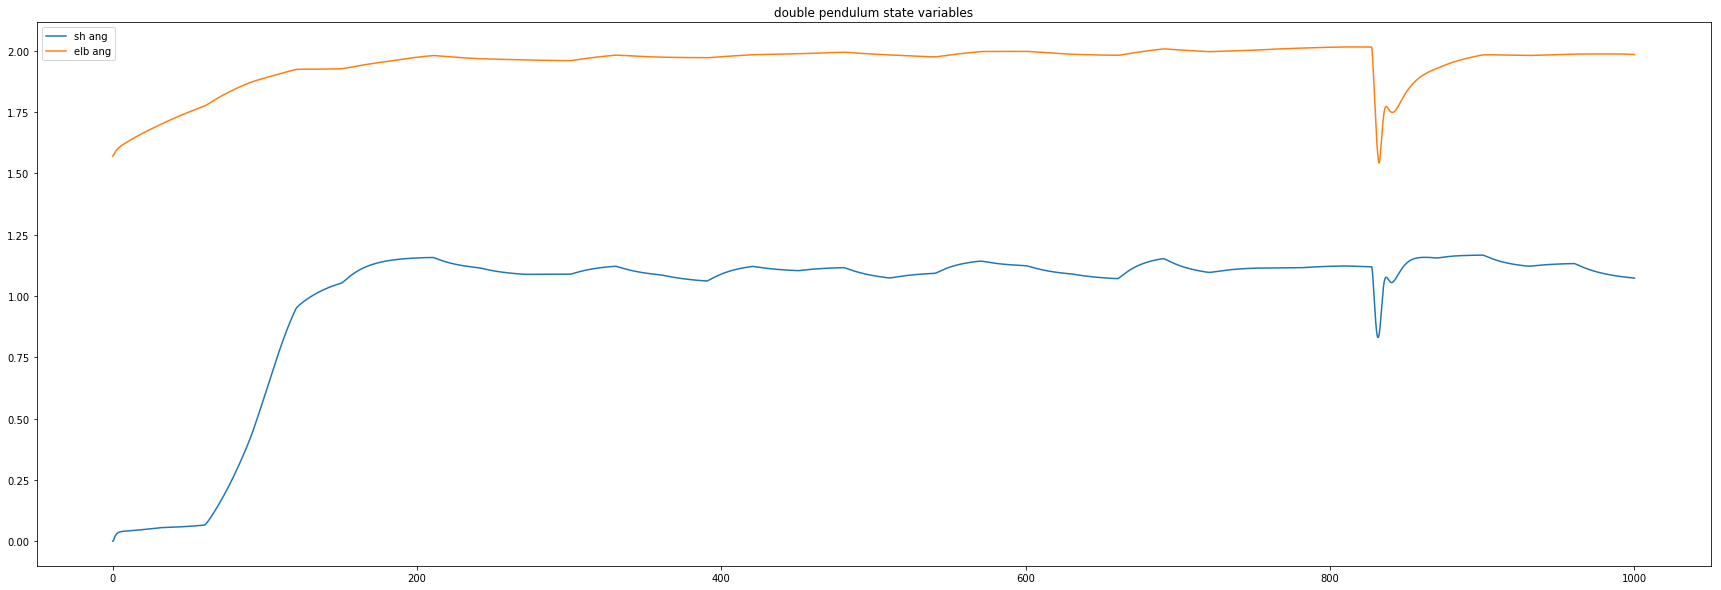

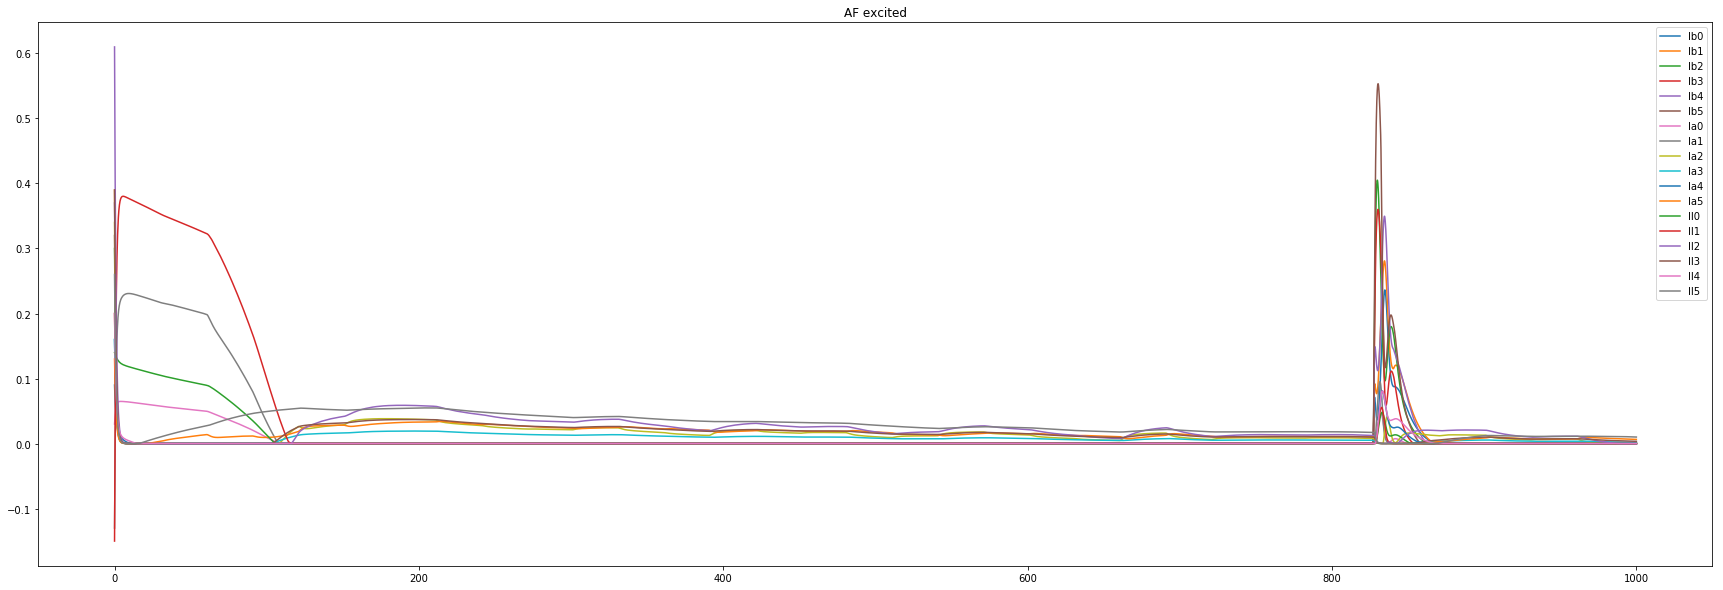

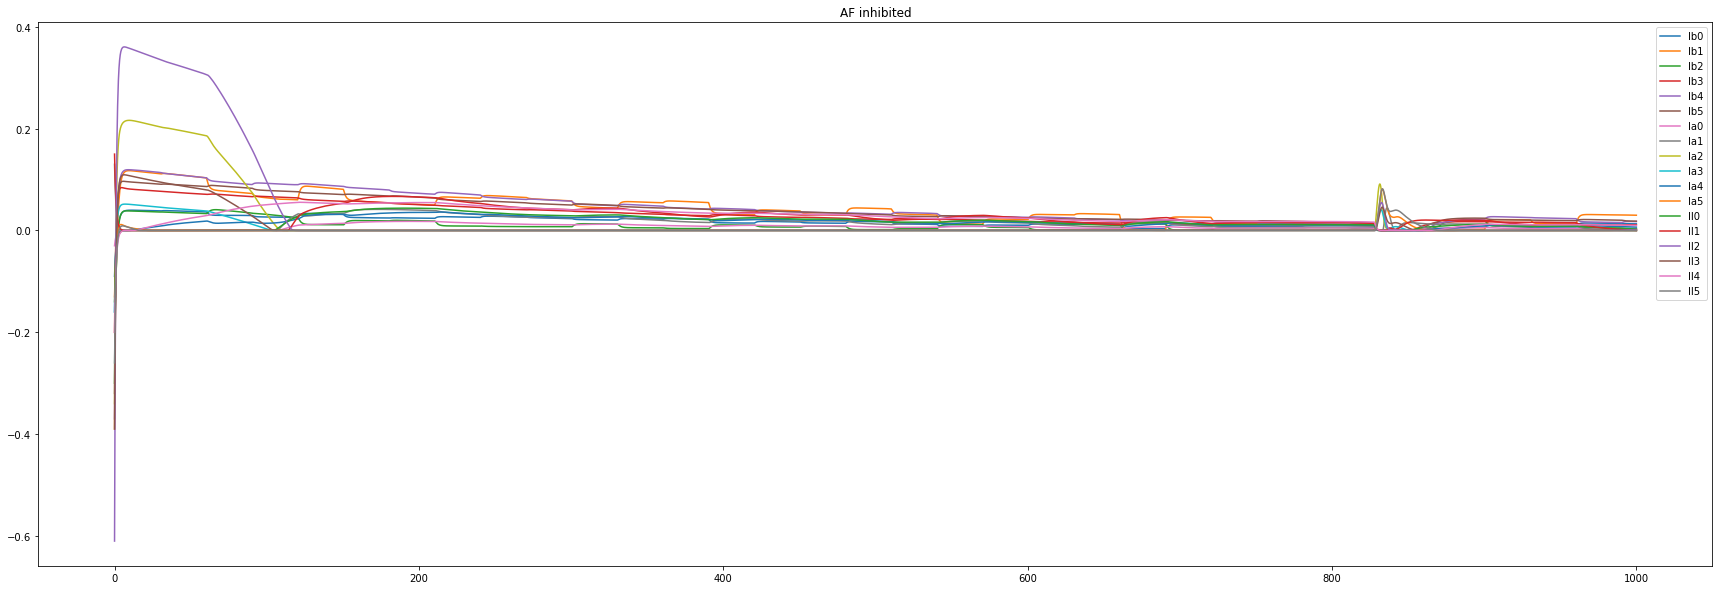

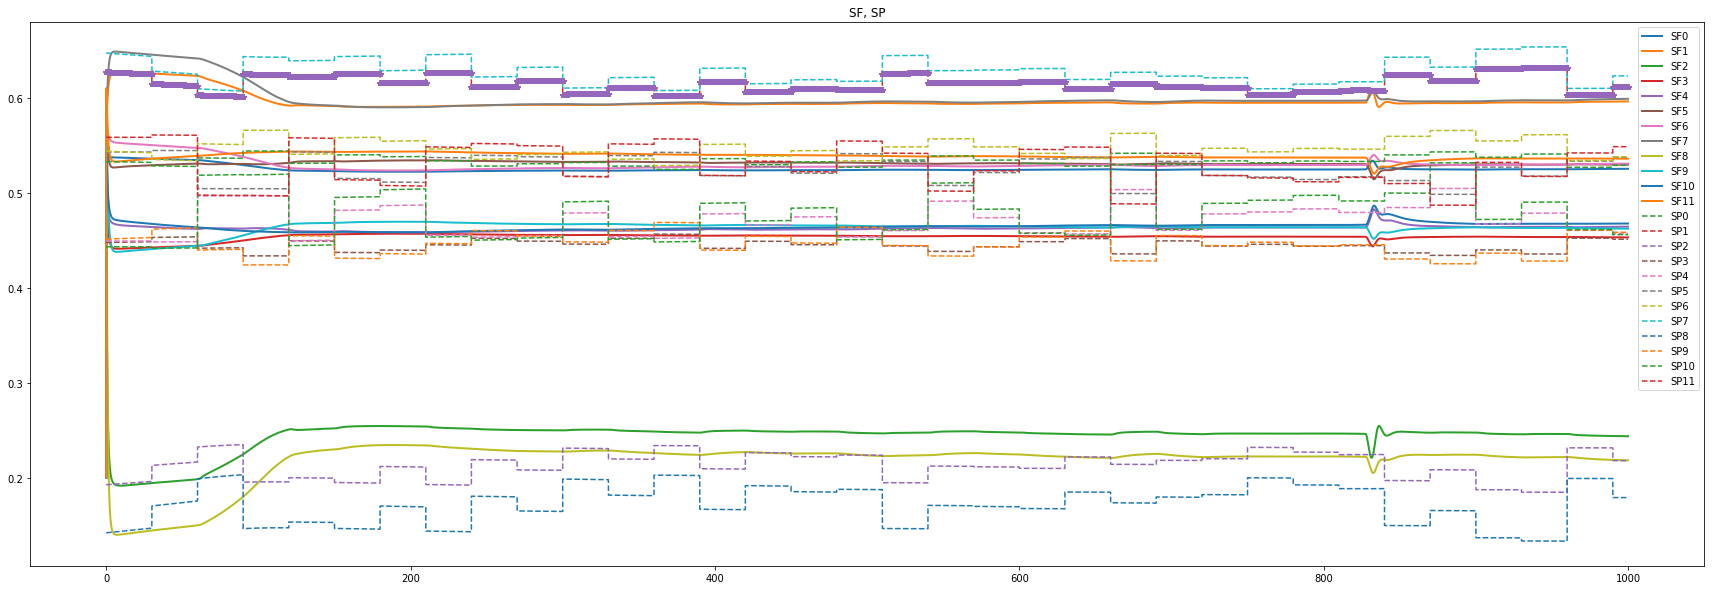

SF = 
[0.52540417 0.59635418 0.24377834 0.45314356 0.46446271 0.52965805
 0.53089685 0.59908758 0.21835878 0.46232872 0.46778154 0.53603233]
SP = 
[0.52904329 0.61181536 0.21802558 0.45120545 0.45719119 0.53762838
 0.5380722  0.62329453 0.17917727 0.45854449 0.45608217 0.54867454]


In [11]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[P][:,0:4:2]
plt.plot(times, P_state)
#plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.legend(['sh ang', 'elb ang',])
plt.title('double pendulum state variables')
print("shoulder angle: %f, shoulder vel: %f" % (P_state[-1,0],P_state[-1,1]))

# AF plus
AFe_fig = plt.figure(figsize=fs)
AFe_data = np.array(data[AF[0:18]])
plt.plot(times, AFe_data.transpose())
AF_legends = ['Ib' + str(i) for i in range(6)] + \
             ['Ia' + str(i) for i in range(6)] + \
             ['II' + str(i) for i in range(6)]
plt.legend(AF_legends)
plt.title('AF excited')
print('AFe_data:')
print(AFe_data[:,-1])

# AF minus
AFi_fig = plt.figure(figsize=fs)
AFi_data = np.array(data[AF[18:36]])
plt.plot(times, AFi_data.transpose())
AF_legends = ['Ib' + str(i) for i in range(6)] + \
             ['Ia' + str(i) for i in range(6)] + \
             ['II' + str(i) for i in range(6)]
plt.legend(AF_legends)
plt.title('AF inhibited')
print('AFi_data:')
print(AFi_data[:,-1])

# SF, SP
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), linewidth=2)
plt.plot(times, SP_data.transpose(), '--')
plt.plot(times, SP_data[1,:], '*')
SF_legends = ['SF'+str(i) for i in range(len(SF))]
SP_legends = ['SP'+str(i) for i in range(len(SP))]
plt.legend(SF_legends+SP_legends)
plt.title('SF, SP')
plt.show()
print('SF = ')
print(SF_data[:,-1])
print('SP = ')
print(SP_data[:,-1])

In [10]:
AF_avgs

array([0.24, 0.1 , 0.64, 0.31, 0.43, 0.2 , 0.24, 0.11, 0.43, 0.29, 0.3 ,
       0.17])

In [71]:
# removing feedback to compare with Fink et al.
for uid in CE+CI:
    syn_list = net.syns[uid]
    for syn in syn_list:
        if syn.preID in AF:
            #syn.w = 0.
            syn.alpha = 1.
            syn.normalize = False